# Forecasting Model

The purpose of this notebook is to formulate a forecasting model which we will use to predict future median_sale_prices using the cleaned State_analysis table in our MySQL database. This is considered part of the **MODEL** step in the Green Cloud Model used to layout the Data Science process. Although linear regression is a powerful tool we could use to formulate predictions, many of our features are dependent on one another and time plays the most significant role based on our available features. Therefore, using a forecasting model is may be more useful for predicting median sale prices in the housing market since we can utilize a transformation of our date variable: $t$, or the time points.

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pymysql
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn.linear_model as linear
import statsmodels.api as sm
import patsy
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from tabulate import tabulate
from copy import deepcopy

sns.set(style="darkgrid")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

<a id="0"></a>
## Notebook Contents

1. [Retrieve Data from MySQL](#1)
2. [Level](#2)
3. [Simple Exponential Smoothing](#3)
4. [Holt's Trend Corrected Smoothing](#4)
5. [Autocorrelations](#5a)
6. [Holt's-Winters](#5)

<a id="1"></a>

### Retrieve Data from MySQL

[Back to Contents](#0)

In [4]:
conn = pymysql.connect(
    host= 'MySQL_1',
    port=3306,
    user="Sarah",
    passwd='password',
    db="db",
    charset='utf8mb4')

In [5]:
curs = conn.cursor()

In [6]:
# State table in pandas
curs.execute("SHOW columns FROM State_analysis")
state_analysis_headers = [column[0] for column in curs.fetchall()]

curs.execute("SELECT * FROM State_analysis \
              ORDER BY period_begin ASC")
state = pd.DataFrame(curs.fetchall(), columns=state_analysis_headers)

In addition to retrieving the data, we learned during EDA that it's best to look at our data points as sub-groups if we want to factor in property type for any time series analysis. One property type option is "All residential", which essentially averages all the data from each property type. We can either treat the time periods for each state and property type as an individual time series, or opt to use only "All residential" if we do not want 5 different time series sets for each state. 

In [7]:
state_grouped = state.groupby(['state_code', "property_type"])

state_keys = list(state_grouped.groups.keys())

<a id="2"></a>

### Level

[Back to Contents](#0)

The most basic method for forecasting is setting a static *level*, which is often the mean of all time series values. In addition to the level, we must factor in potential error, so the forecast model takes the form:

$forecast_{t} = level_{t-1} + \epsilon$

We will use the "All Residential" to get the mean sale price for each state, but we will plot the level against all 4-5 property types available. Let's try generating the means for the same six states we looked at in EDA and plotting the time series data with the level's:

In [8]:
# Find the mean sale price for each state based on "All residential" as the level
AK_mean = state_grouped.get_group(state_keys[0]).median_sale_price.mean()
CA_mean = state_grouped.get_group(state_keys[19]).median_sale_price.mean()
NY_mean = state_grouped.get_group(state_keys[159]).median_sale_price.mean()
FL_mean = state_grouped.get_group(state_keys[44]).median_sale_price.mean()
TX_mean = state_grouped.get_group(state_keys[204]).median_sale_price.mean()
DC_mean = state_grouped.get_group(state_keys[34]).median_sale_price.mean()


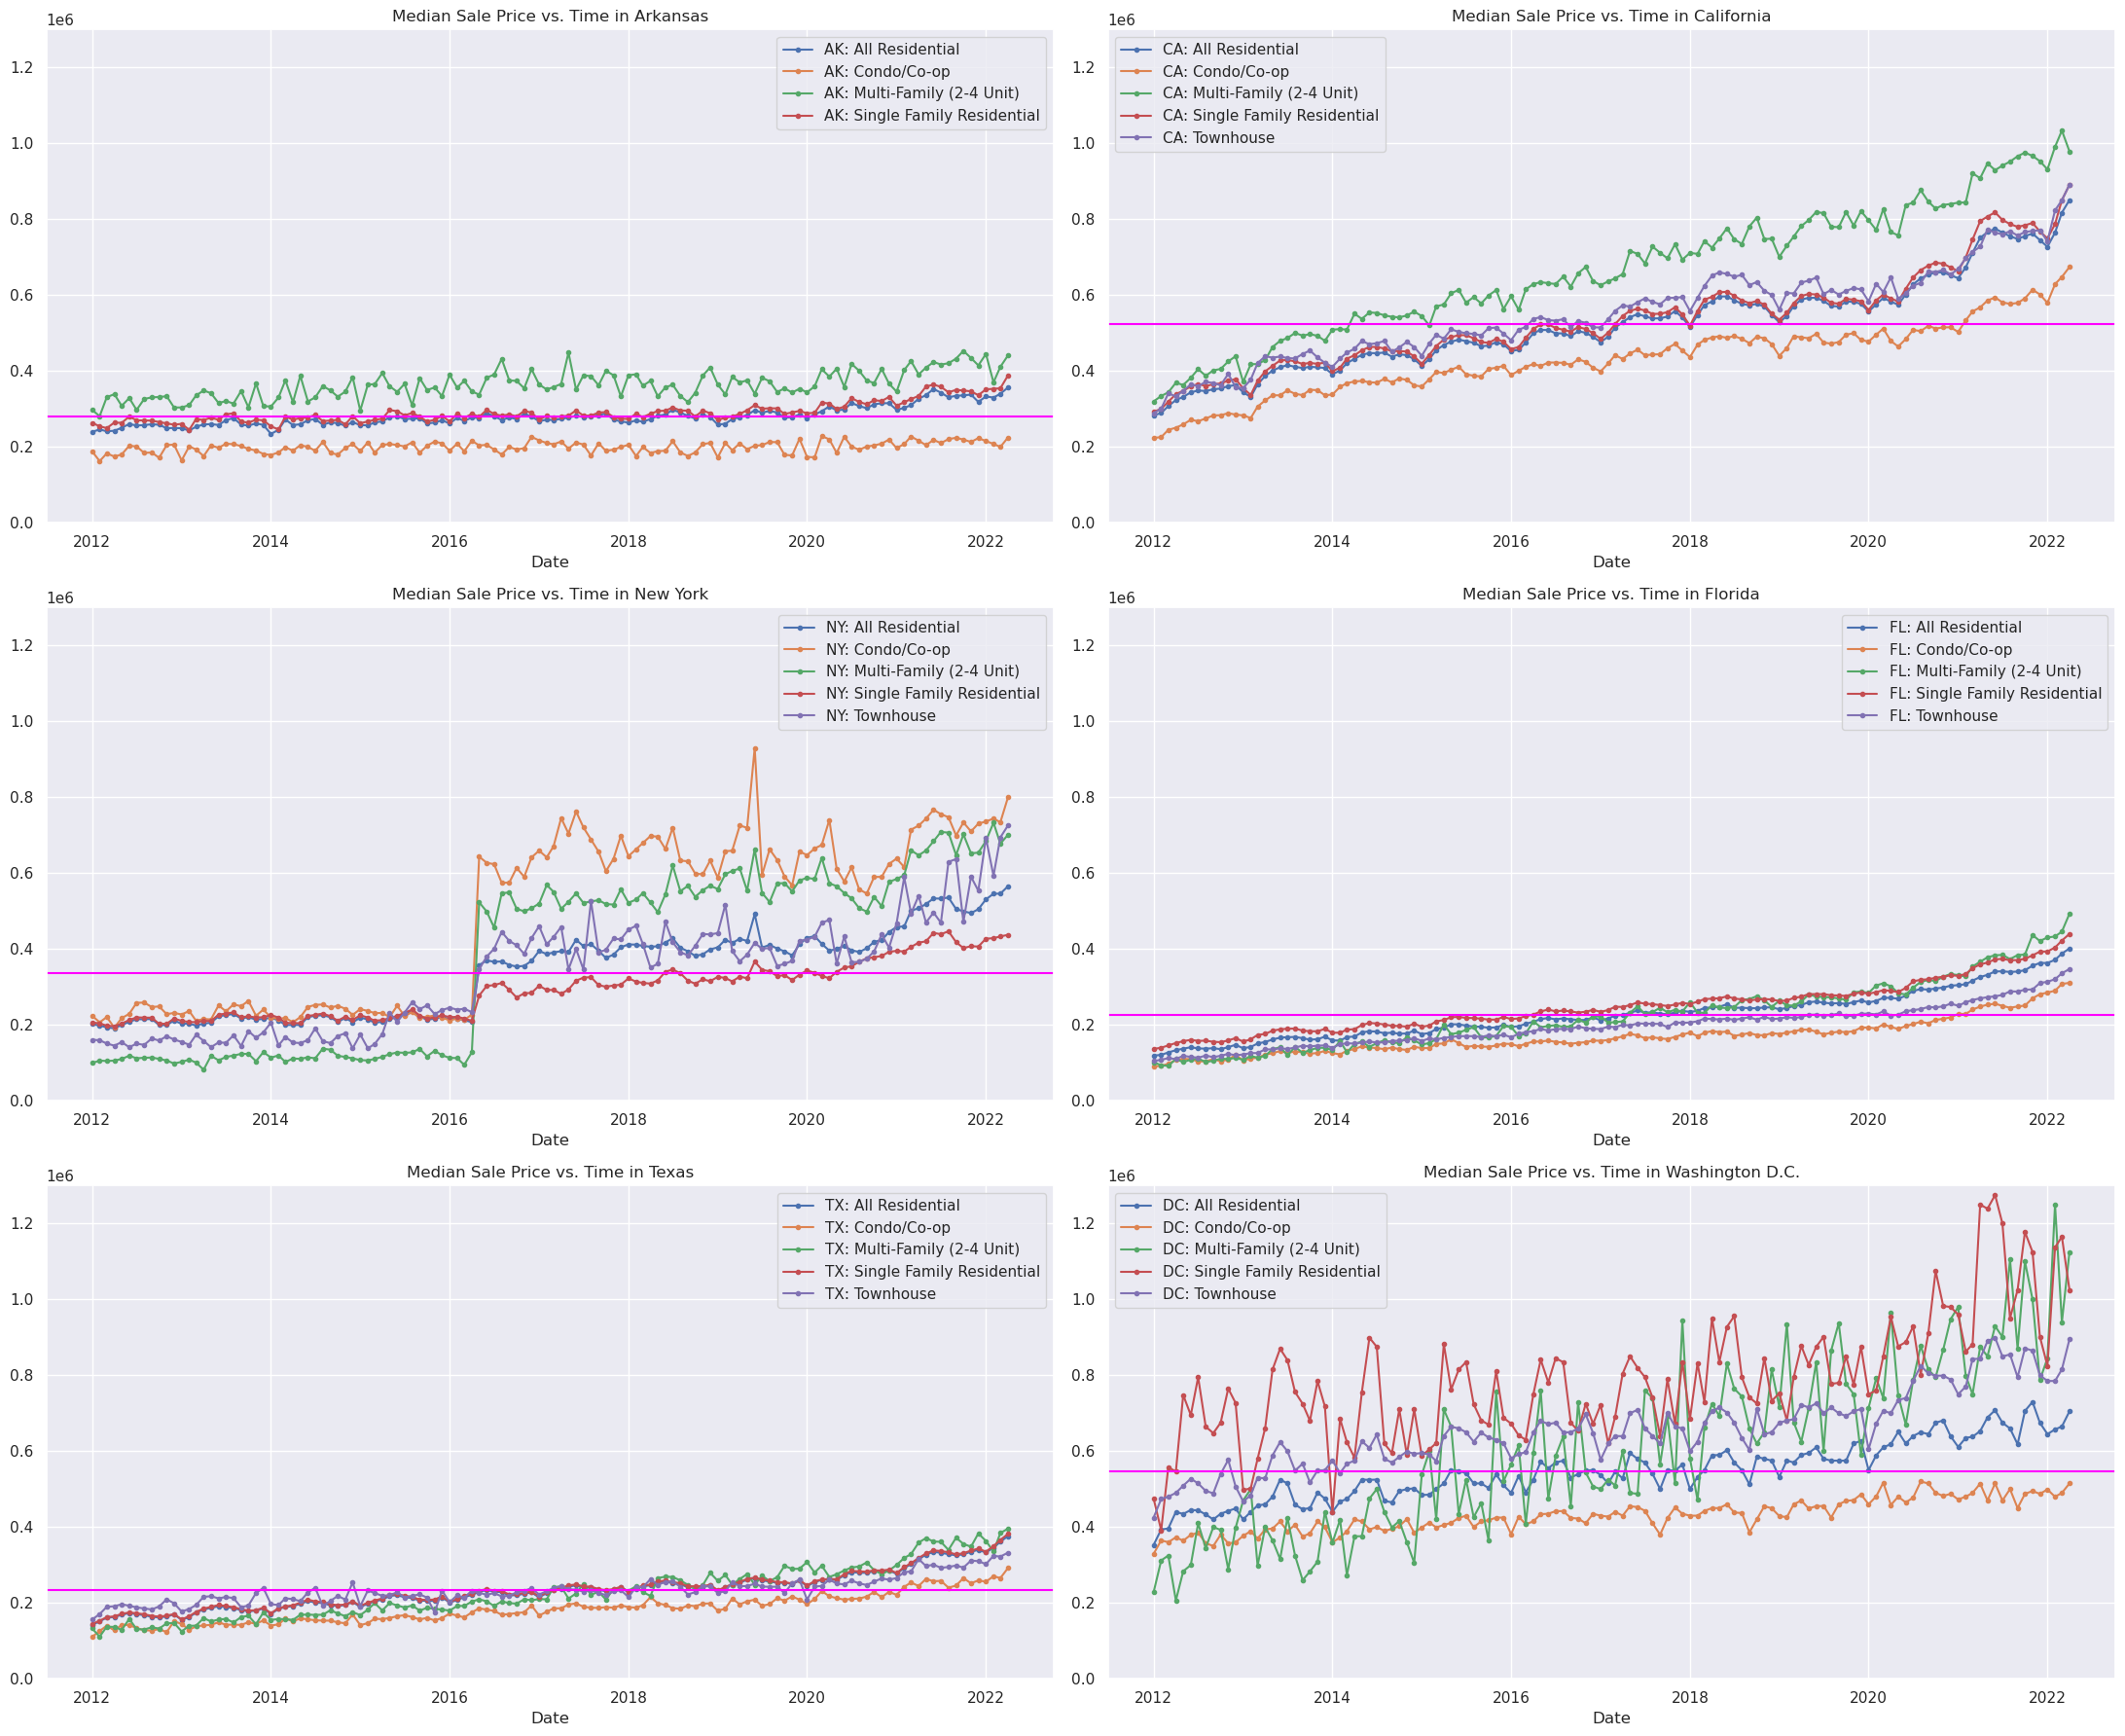

In [9]:
figure = plt.figure(figsize=(22, 18))

# Arkansas : Townhouse data not available 
axes = figure.add_subplot(3, 2, 1)
legend_ = []

for i in range(0, 4):
    df = state_grouped.get_group(state_keys[i])
    legend_.append(f"{state_keys[i][0]}: {state_keys[i][1]}")
    axes.plot(df.period_begin, df.median_sale_price, marker=".")
    
axes.axhline(y=AK_mean, c="magenta")
axes.set_ylim(0, 1300000)
axes.legend(legend_)
axes.set_title("Median Sale Price vs. Time in Arkansas")
axes.set_xlabel("Date")

# California
axes = figure.add_subplot(3, 2, 2)
legend_ = []

for i in range(19, 24):
    df = state_grouped.get_group(state_keys[i])
    legend_.append(f"{state_keys[i][0]}: {state_keys[i][1]}")
    axes.plot(df.period_begin, df.median_sale_price, marker=".")

axes.axhline(y=CA_mean, c="magenta")
axes.set_ylim(0, 1300000)
axes.legend(legend_)
axes.set_title("Median Sale Price vs. Time in California")
axes.set_xlabel("Date")

# New York
axes = figure.add_subplot(3, 2, 3)
legend_ = []

for i in range(159, 164):
    df = state_grouped.get_group(state_keys[i])
    legend_.append(f"{state_keys[i][0]}: {state_keys[i][1]}")
    axes.plot(df.period_begin, df.median_sale_price, marker=".")

axes.axhline(y=NY_mean, c="magenta")
axes.set_ylim(0, 1300000)
axes.legend(legend_)
axes.set_title("Median Sale Price vs. Time in New York")
axes.set_xlabel("Date")

# Florida
axes = figure.add_subplot(3, 2, 4)
legend_ = []

for i in range(44, 49):
    df = state_grouped.get_group(state_keys[i])
    legend_.append(f"{state_keys[i][0]}: {state_keys[i][1]}")
    axes.plot(df.period_begin, df.median_sale_price, marker=".")

axes.axhline(y=FL_mean, c="magenta")
axes.set_ylim(0, 1300000)
axes.legend(legend_)
axes.set_title("Median Sale Price vs. Time in Florida")
axes.set_xlabel("Date")

# Texas
axes = figure.add_subplot(3, 2, 5)
legend_ = []

for i in range(204, 209):
    df = state_grouped.get_group(state_keys[i])
    legend_.append(f"{state_keys[i][0]}: {state_keys[i][1]}")
    axes.plot(df.period_begin, df.median_sale_price, marker=".")

axes.axhline(y=TX_mean, c="magenta")
axes.set_ylim(0, 1300000)
axes.legend(legend_)
axes.set_title("Median Sale Price vs. Time in Texas")
axes.set_xlabel("Date")

# Washington D.C.
axes = figure.add_subplot(3, 2, 6)
legend_ = []

for i in range(34, 39):
    df = state_grouped.get_group(state_keys[i])
    legend_.append(f"{state_keys[i][0]}: {state_keys[i][1]}")
    axes.plot(df.period_begin, df.median_sale_price, marker=".")

axes.axhline(y=DC_mean, c="magenta")
axes.set_ylim(0, 1300000)
axes.legend(legend_)
axes.set_title("Median Sale Price vs. Time in Washington D.C.")
axes.set_xlabel("Date")

plt.tight_layout()
plt.show()

Based on the results for six of our states/locations, using level as a forecasting model may not be ideal. In most cases, level overestimates early time points and underestimates more recent time points. Therefore, the trend is likely to continue if we want to predict the next time point using level; we will likely underestimate. For some states, the degree of error is greater (i.e. California, New York, D.C) and is a further reason why we should look into less simplistic methods for forecasting.

<a id="3"></a>

### Simple Exponential Smoothing 

[Back to Contents](#0)

Since we need to emphasize more recent data points, rather than equally factoring in old data points from 2012 with data points from 2022, simple exponential smoothing is a potential option for estimating the level. The level is estimated as follows:

$level_{t} = level_{t-1} + \alpha (x_{t-1} - level_{t-1})$

We will need to determine the initial level, $level_{0}$ and the $\alpha$. Since our data is a bit on the nosy side, we will try ***averaging the first third of values*** to find $level_{0}$. In addition, we will work with the same initial 6 states, which will require 4-5 time series sets for each. Therefore, we need to find $level_{0}$ for each state and each property type.

As you can imagine, this will get very tedious to do for each state and property type (for each time series). Instead, we can generate a function and test a handful of time series data sets to see how Simple exponential smoothing performs:

In [10]:
def SES(alpha=0.5, state=str):
    ind = []
    result = []

    for item in state_keys:
        if item[0] == state:
            ind.append([state_keys.index(item), item[1]]) 
            

    for index in ind:
        date_ = state_grouped.get_group(state_keys[index[0]]).period_begin
        date = date_.reset_index(drop=True)

        series_ = state_grouped.get_group(state_keys[index[0]]).median_sale_price
        series = series_.reset_index(drop=True)

        n = int(np.ceil((1/3) * len(series)))
        level = series[0:n].mean()
        ses = [level]

        for i in range(1, len(series)):
            level = level + alpha * (series[i-1] - level)
            ses.append(level)
        error = ses-series
        result.append([index[1], date, series, ses, error]) 

    return result

In [11]:
AK_ses = SES(state='AK')
CA_ses = SES(state='CA')
NY_ses = SES(state='NY')
TX_ses = SES(state='TX')
FL_ses = SES(state='FL')
DC_ses = SES(state='DC')

The function returns the property type evaluated, the raw median sale price data, the simple exponential smoothing data, and the forecast error. Let's start with Arkansas and plot the raw data vs ses data, in addition to the error, for each property type:

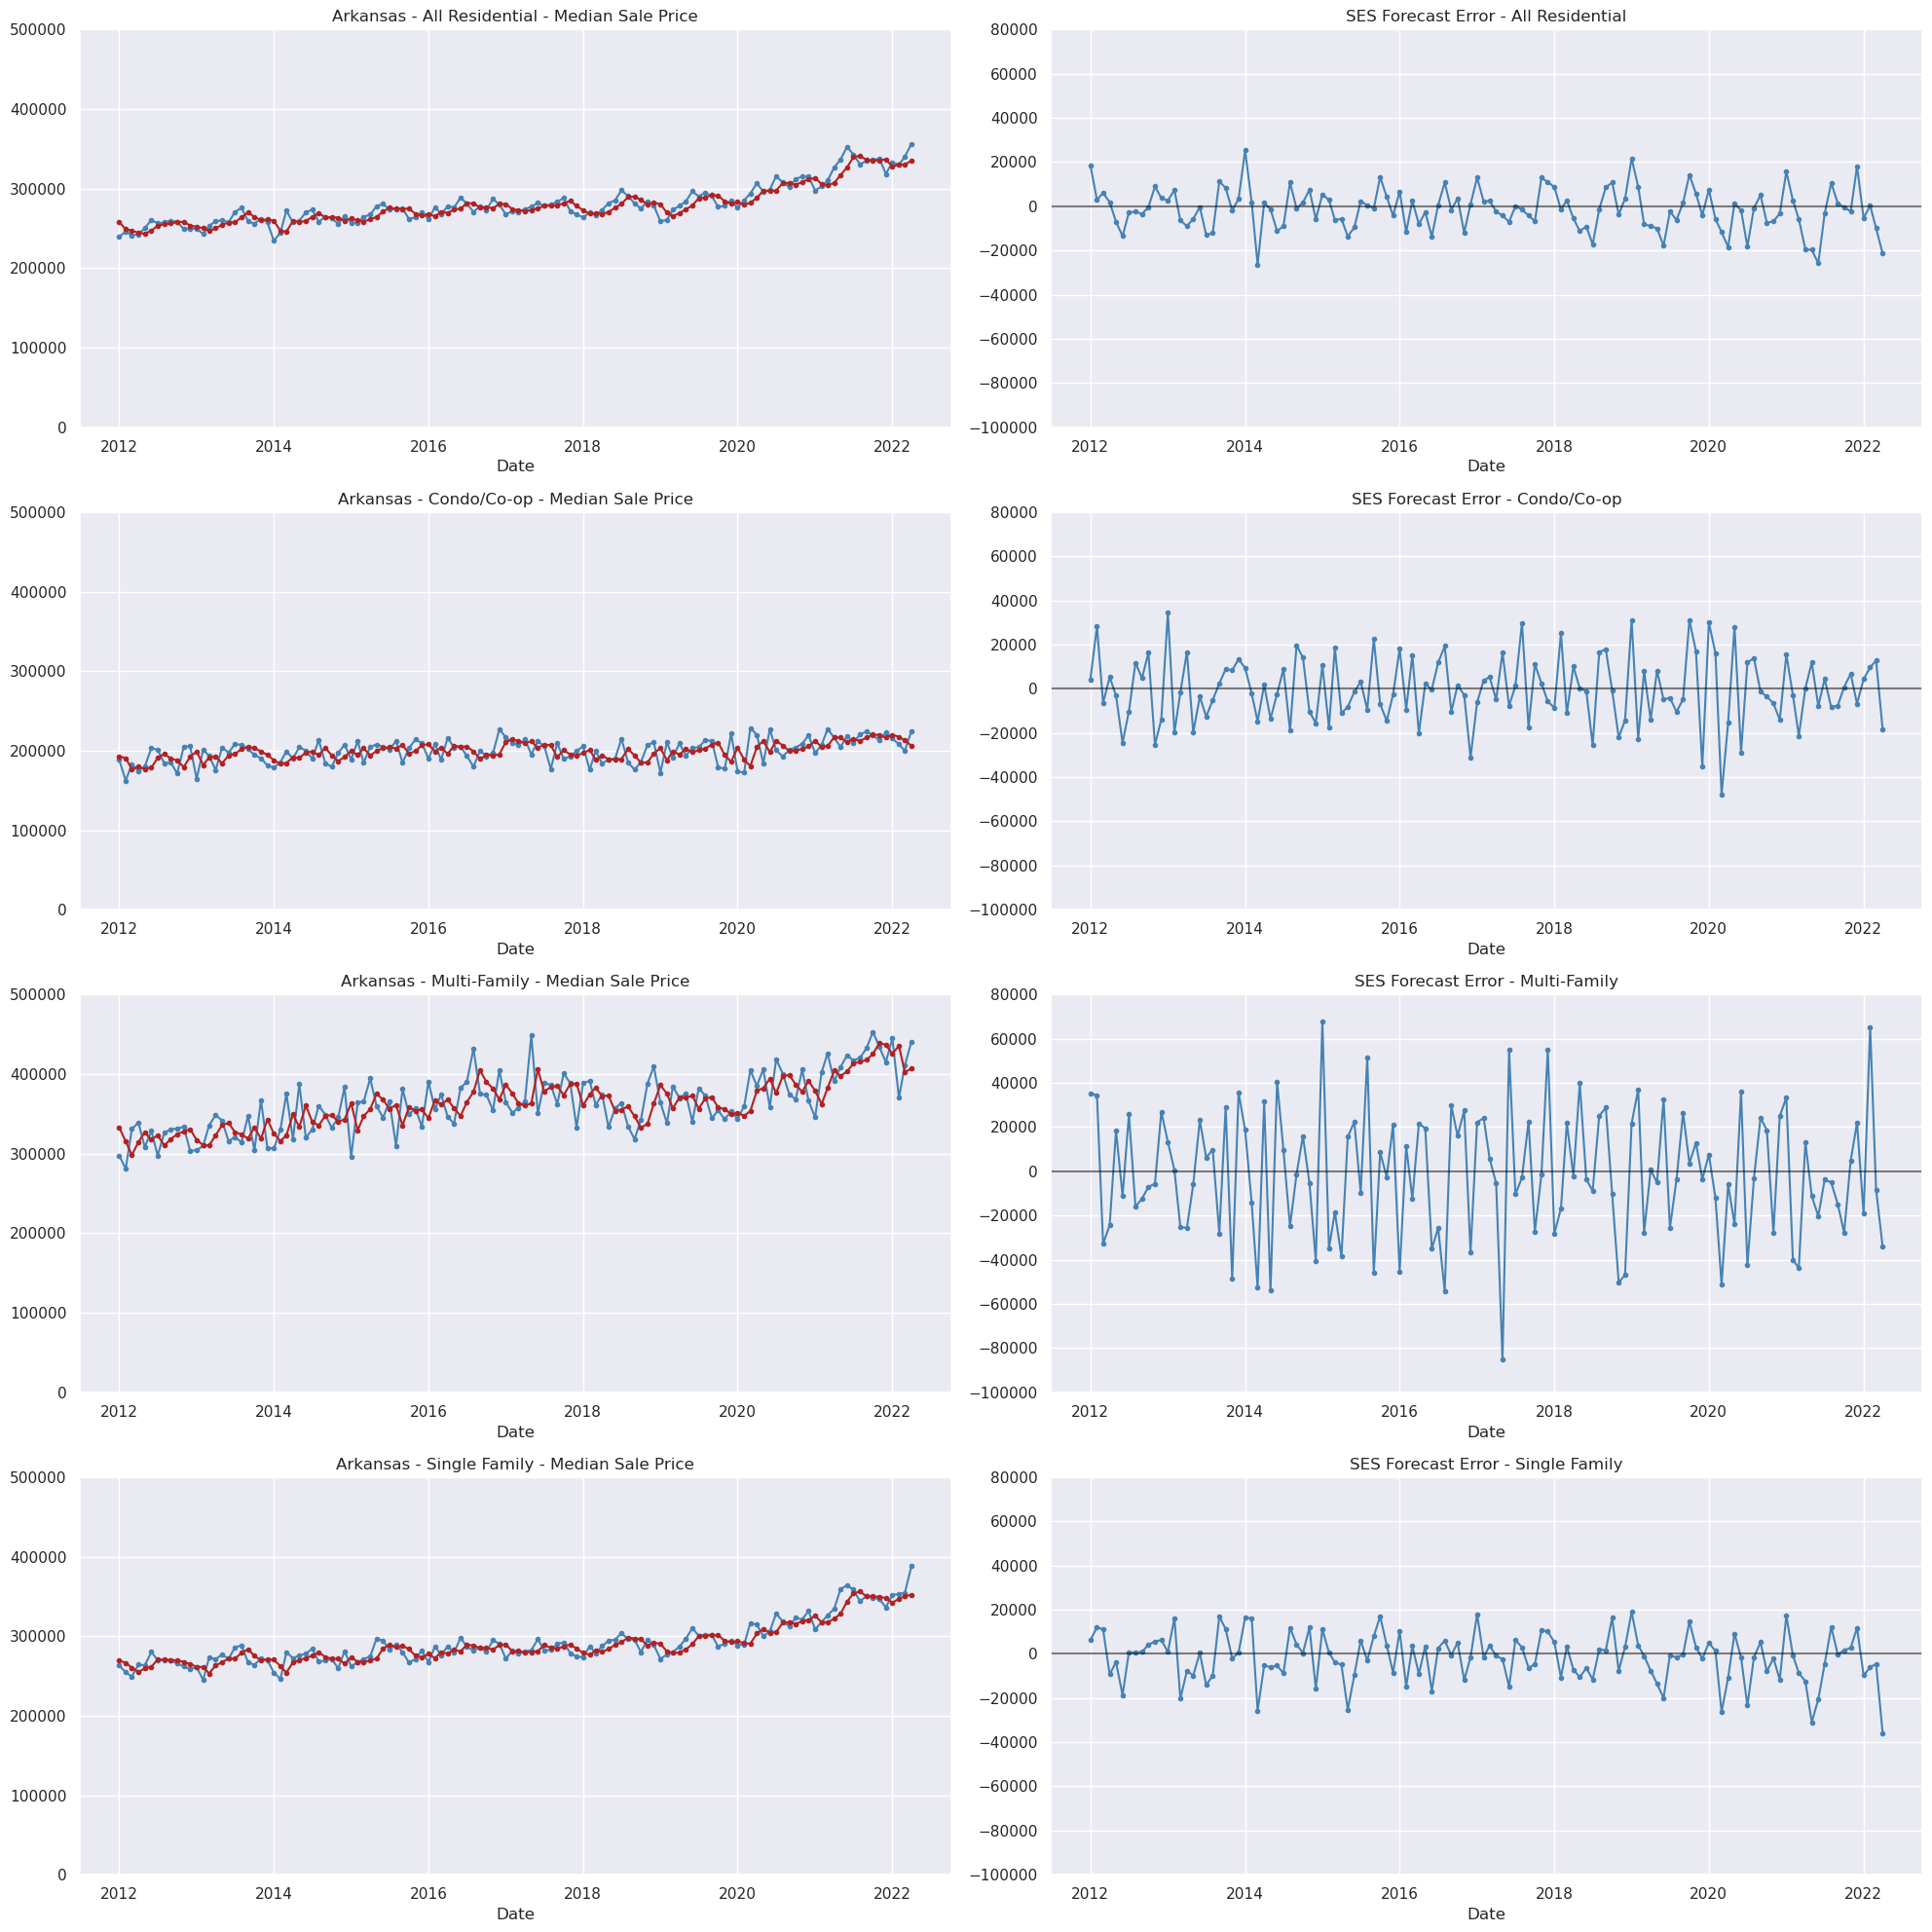

In [12]:
figure = plt.figure(figsize=(20, 20))

axes = figure.add_subplot(4, 2, 1)

axes.plot( AK_ses[0][1], AK_ses[0][2], color="steelblue", marker=".")
axes.plot( AK_ses[0][1], AK_ses[0][3], color="firebrick", marker=".")
axes.set_title( "Arkansas - All Residential - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 500000)

axes = figure.add_subplot(4, 2, 2)

axes.plot( AK_ses[0][1], AK_ses[0][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - All Residential")
axes.set_xlabel('Date')
axes.set_ylim(-100000, 80000)

axes = figure.add_subplot(4, 2, 3)

axes.plot( AK_ses[1][1], AK_ses[1][2], color="steelblue", marker=".")
axes.plot( AK_ses[1][1], AK_ses[1][3], color="firebrick", marker=".")
axes.set_title( "Arkansas - Condo/Co-op - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 500000)

axes = figure.add_subplot(4, 2, 4)

axes.plot( AK_ses[1][1], AK_ses[1][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Condo/Co-op")
axes.set_xlabel('Date')
axes.set_ylim(-100000, 80000)

axes = figure.add_subplot(4, 2, 5)

axes.plot( AK_ses[2][1], AK_ses[2][2], color="steelblue", marker=".")
axes.plot( AK_ses[2][1], AK_ses[2][3], color="firebrick", marker=".")
axes.set_title( "Arkansas - Multi-Family - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 500000)

axes = figure.add_subplot(4, 2, 6)

axes.plot( AK_ses[2][1], AK_ses[2][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Multi-Family")
axes.set_xlabel('Date')
axes.set_ylim(-100000, 80000)

axes = figure.add_subplot(4, 2, 7)

axes.plot( AK_ses[3][1], AK_ses[3][2], color="steelblue", marker=".")
axes.plot( AK_ses[3][1], AK_ses[3][3], color="firebrick", marker=".")
axes.set_title( "Arkansas - Single Family - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 500000)

axes = figure.add_subplot(4, 2, 8)

axes.plot( AK_ses[3][1], AK_ses[3][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Single Family")
axes.set_xlabel('Date')
axes.set_ylim(-100000, 80000)

plt.tight_layout()
plt.show()

For comparison sake, I set all of the axes limits to the same ranges. The red line's appear to be slightly shifted, "weakened" versions of the raw time series data. In addition, we see the greatest forecast error with Multi-Family homes, possibly due to the larger range of possible values over time. Keep in mind that there are 124 time points for each series, so if we want to predict the 125th point, or "2022-05-01", we need to use the 124th point. Let's try predicting the median sale price for the next time point:

In [13]:
# [  [Index, Property type], date, series, ses, error]
# [0[ 0,        1],            1,     2,     3,     4]

def ses_predict(data, alpha=0.5):
    num_property = len(data)  # number of properties to evaluate
    predict = []
    point_ind = len(data[0][1]) - 1 #the last time point index

    for i in range(0, num_property):
        property = data[i][0]
        past = data[i][2][point_ind]  # last median_sale_price at the last time point index
        result = data[i][3][point_ind] + alpha * (data[i][2][point_ind] - data[i][3][point_ind])
        predict.append([property, past, result])
    return predict

In [14]:
AK_predict = pd.DataFrame(ses_predict(AK_ses), columns=["property type", "2022-04-01", "(SES) 2022-05-01"])

AK_predict

property type  2022-04-01  (SES) 2022-05-01
0            All Residential   356500.00         345817.07
1                Condo/Co-op   224700.00         215512.61
2    Multi-Family (2-4 Unit)   441000.00         423942.04
3  Single Family Residential   388100.00         370180.29

Although the predicted median sale prices for the next month are in reasonable ranges, they are all lower than the previous month which does not seem probable for all property types. In addition, Simple exponential smoothing will predict the same value for every following time point, so we are very limited with this model. Let's continue with California:

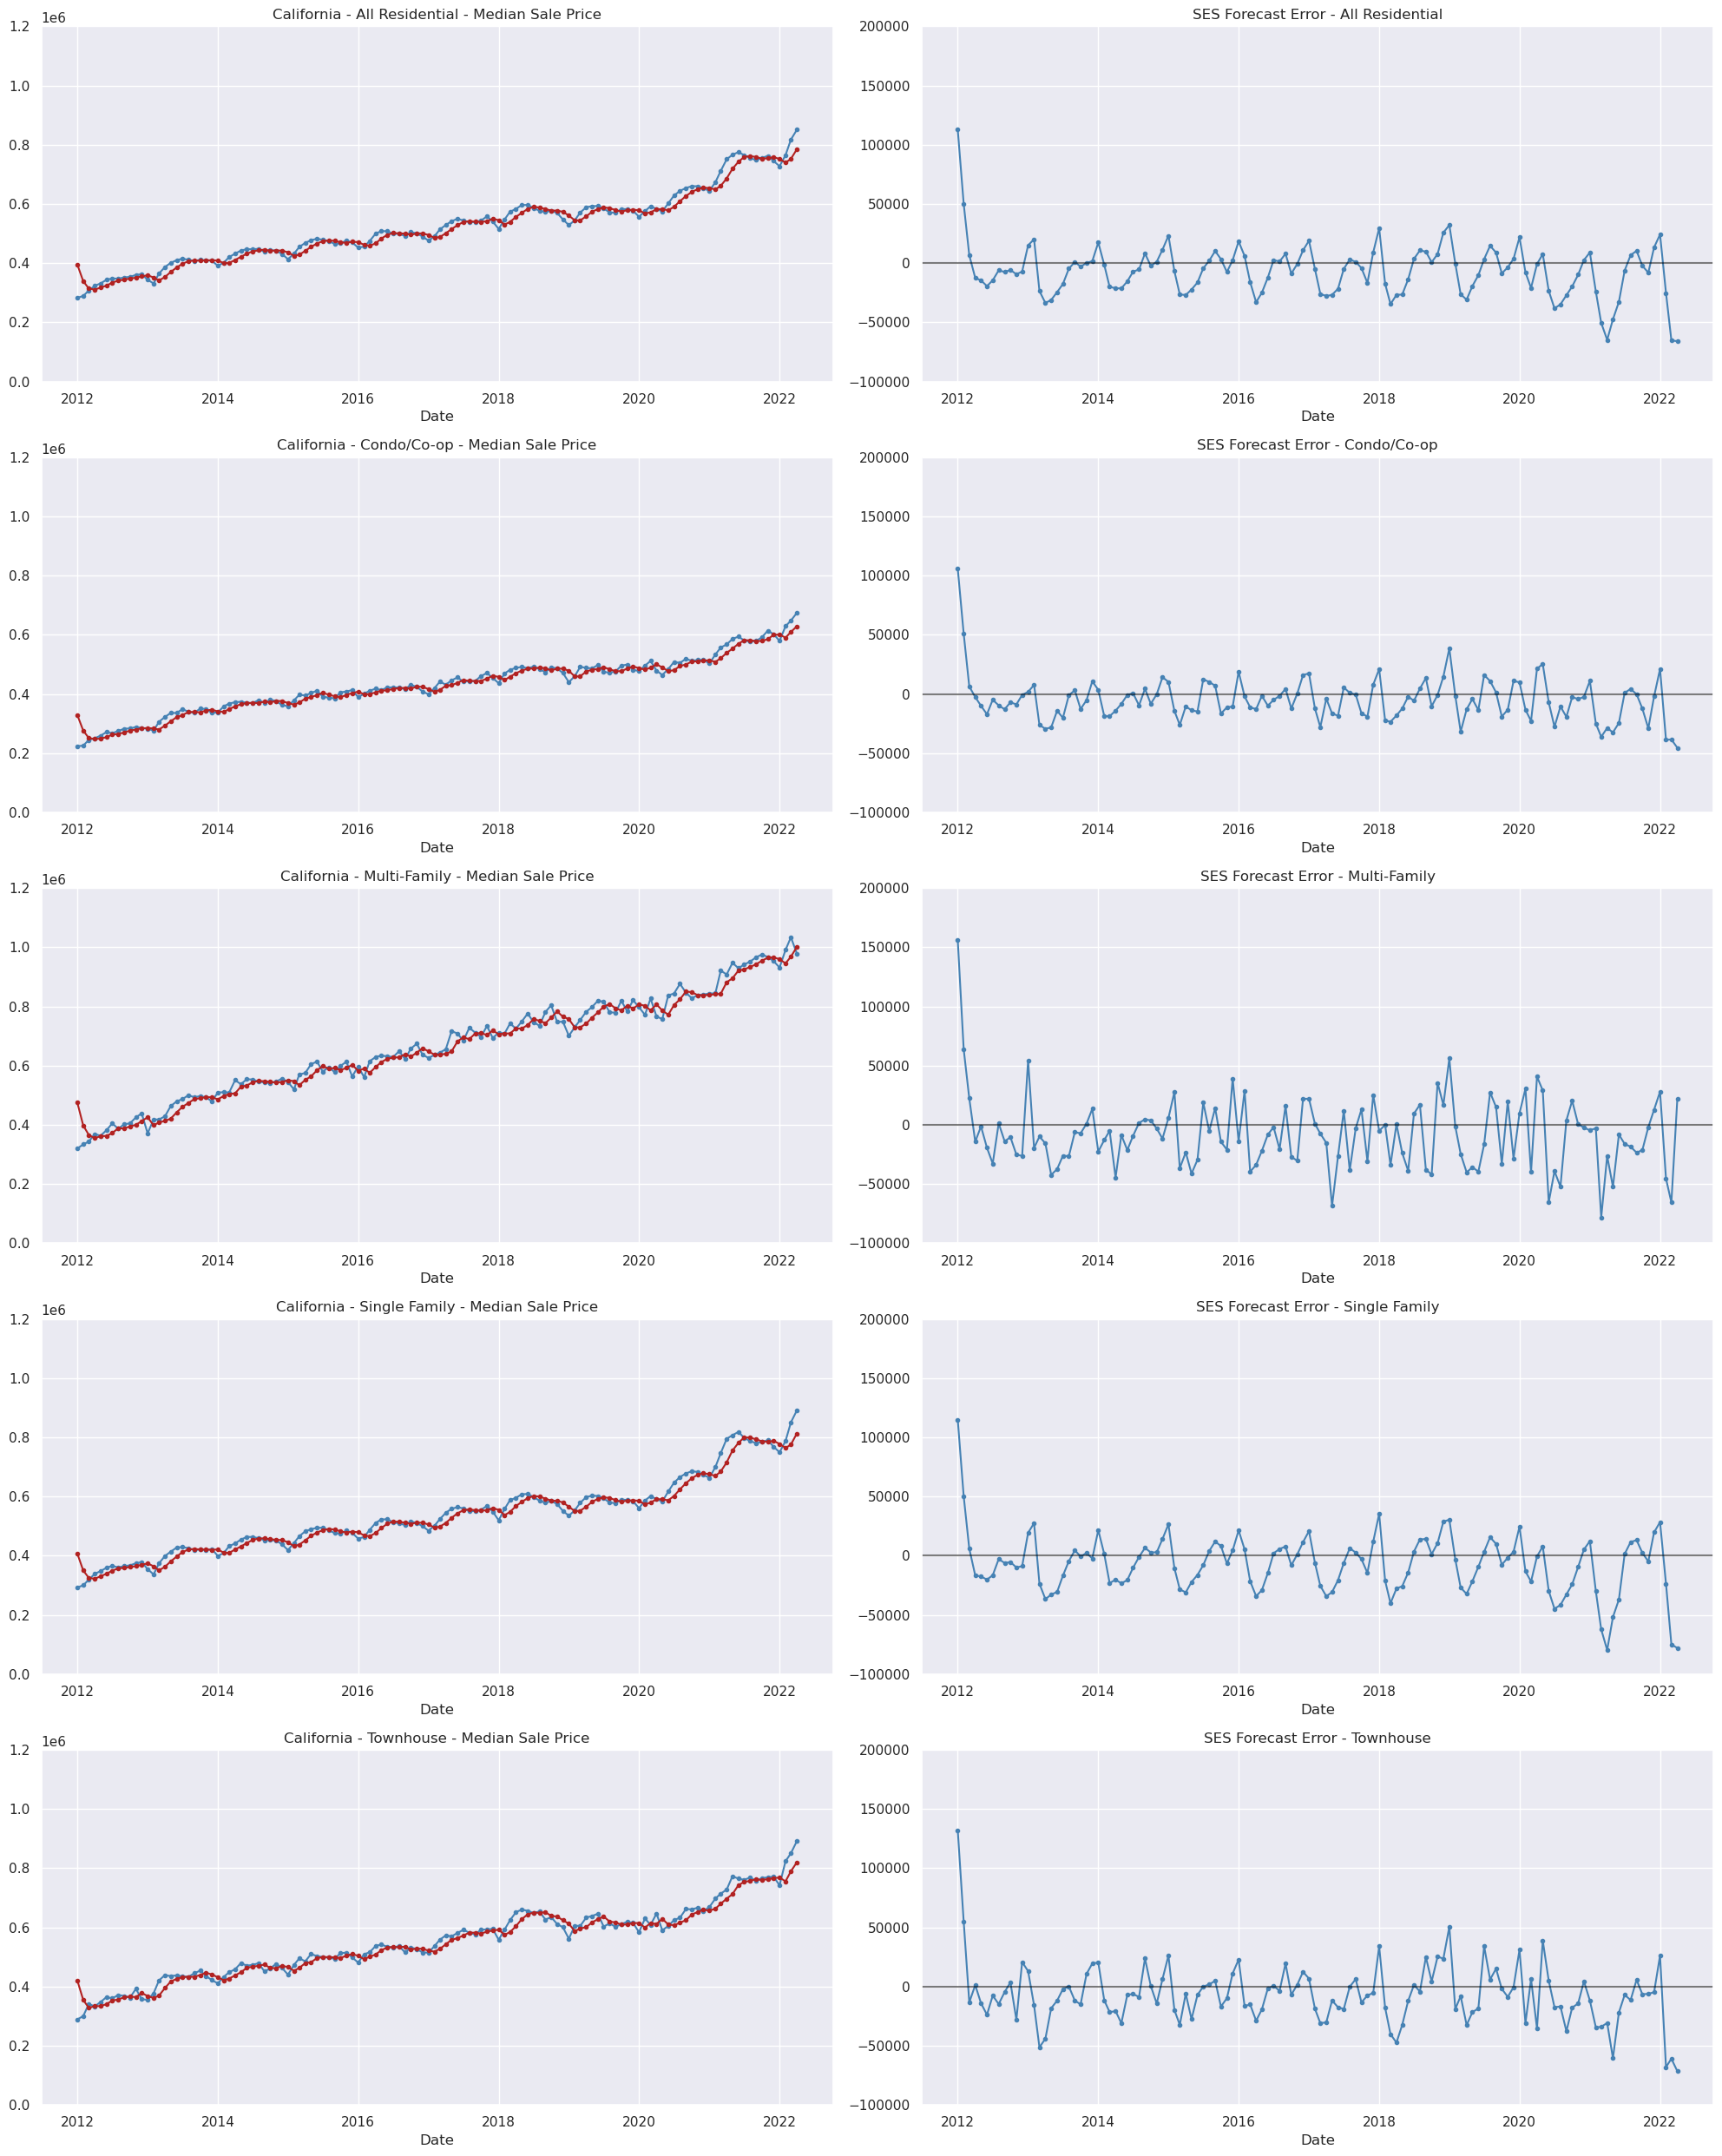

In [15]:
figure = plt.figure(figsize=(20, 25))

axes = figure.add_subplot(5, 2, 1)

axes.plot( CA_ses[0][1], CA_ses[0][2], color="steelblue", marker=".")
axes.plot( CA_ses[0][1], CA_ses[0][3], color="firebrick", marker=".")
axes.set_title( "California - All Residential - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1200000)

axes = figure.add_subplot(5, 2, 2)

axes.plot( CA_ses[0][1], CA_ses[0][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - All Residential")
axes.set_xlabel('Date')
axes.set_ylim(-100000, 200000)

axes = figure.add_subplot(5, 2, 3)

axes.plot( CA_ses[1][1], CA_ses[1][2], color="steelblue", marker=".")
axes.plot( CA_ses[1][1], CA_ses[1][3], color="firebrick", marker=".")
axes.set_title( "California - Condo/Co-op - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1200000)

axes = figure.add_subplot(5, 2, 4)

axes.plot( CA_ses[1][1], CA_ses[1][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Condo/Co-op")
axes.set_xlabel('Date')
axes.set_ylim(-100000, 200000)

axes = figure.add_subplot(5, 2, 5)

axes.plot( CA_ses[2][1], CA_ses[2][2], color="steelblue", marker=".")
axes.plot( CA_ses[2][1], CA_ses[2][3], color="firebrick", marker=".")
axes.set_title( "California - Multi-Family - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1200000)

axes = figure.add_subplot(5, 2, 6)

axes.plot( CA_ses[2][1], CA_ses[2][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Multi-Family")
axes.set_xlabel('Date')
axes.set_ylim(-100000, 200000)

axes = figure.add_subplot(5, 2, 7)

axes.plot( CA_ses[3][1], CA_ses[3][2], color="steelblue", marker=".")
axes.plot( CA_ses[3][1], CA_ses[3][3], color="firebrick", marker=".")
axes.set_title( "California - Single Family - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1200000)

axes = figure.add_subplot(5, 2, 8)

axes.plot( CA_ses[3][1], CA_ses[3][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Single Family")
axes.set_xlabel('Date')
axes.set_ylim(-100000, 200000)

axes = figure.add_subplot(5, 2, 9)

axes.plot( CA_ses[4][1], CA_ses[4][2], color="steelblue", marker=".")
axes.plot( CA_ses[4][1], CA_ses[4][3], color="firebrick", marker=".")
axes.set_title( "California - Townhouse - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1200000)

axes = figure.add_subplot(5, 2, 10)

axes.plot( CA_ses[4][1], CA_ses[4][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Townhouse")
axes.set_xlabel('Date')
axes.set_ylim(-100000, 200000)

plt.tight_layout()
plt.show()

We can note that the error is somewhat high for all property types at certain time points. We seem to have greater error in the very early and more recent time points. For most property types, the SES model underestimates the sale price which explains the lower prediction values. Overall, this forecast model may not be ideal for time series data that increases substantially over time or has evidence of seasonality (which we will remedy later on). Let's try formulating the prediction:

In [16]:
CA_predict = pd.DataFrame(ses_predict(CA_ses), columns=["property type", "2022-04-01", "(SES) 2022-05-01"])

CA_predict

property type  2022-04-01  (SES) 2022-05-01
0            All Residential   850700.00         817753.11
1                Condo/Co-op   674200.00         651510.34
2    Multi-Family (2-4 Unit)   978800.00         989875.70
3  Single Family Residential   890900.00         851936.62
4                  Townhouse   891300.00         855576.21

For all property types, except Multi-Family, we are likely underestimating future values again with this forecast model. Interestingly, Multi-Family homes in California have a higher predicted sale price than the last known raw value, which seems very probable. Since we know simple exponential smoothing results in a shifted and weakened time series, the variation in California's sale prices could be resulting in this higher predicted value. Specifically, the median sale price for California's Multi-Family homes has a dip in mid-2022 after a higher price point in early 2022. We can move on to New York as follows:

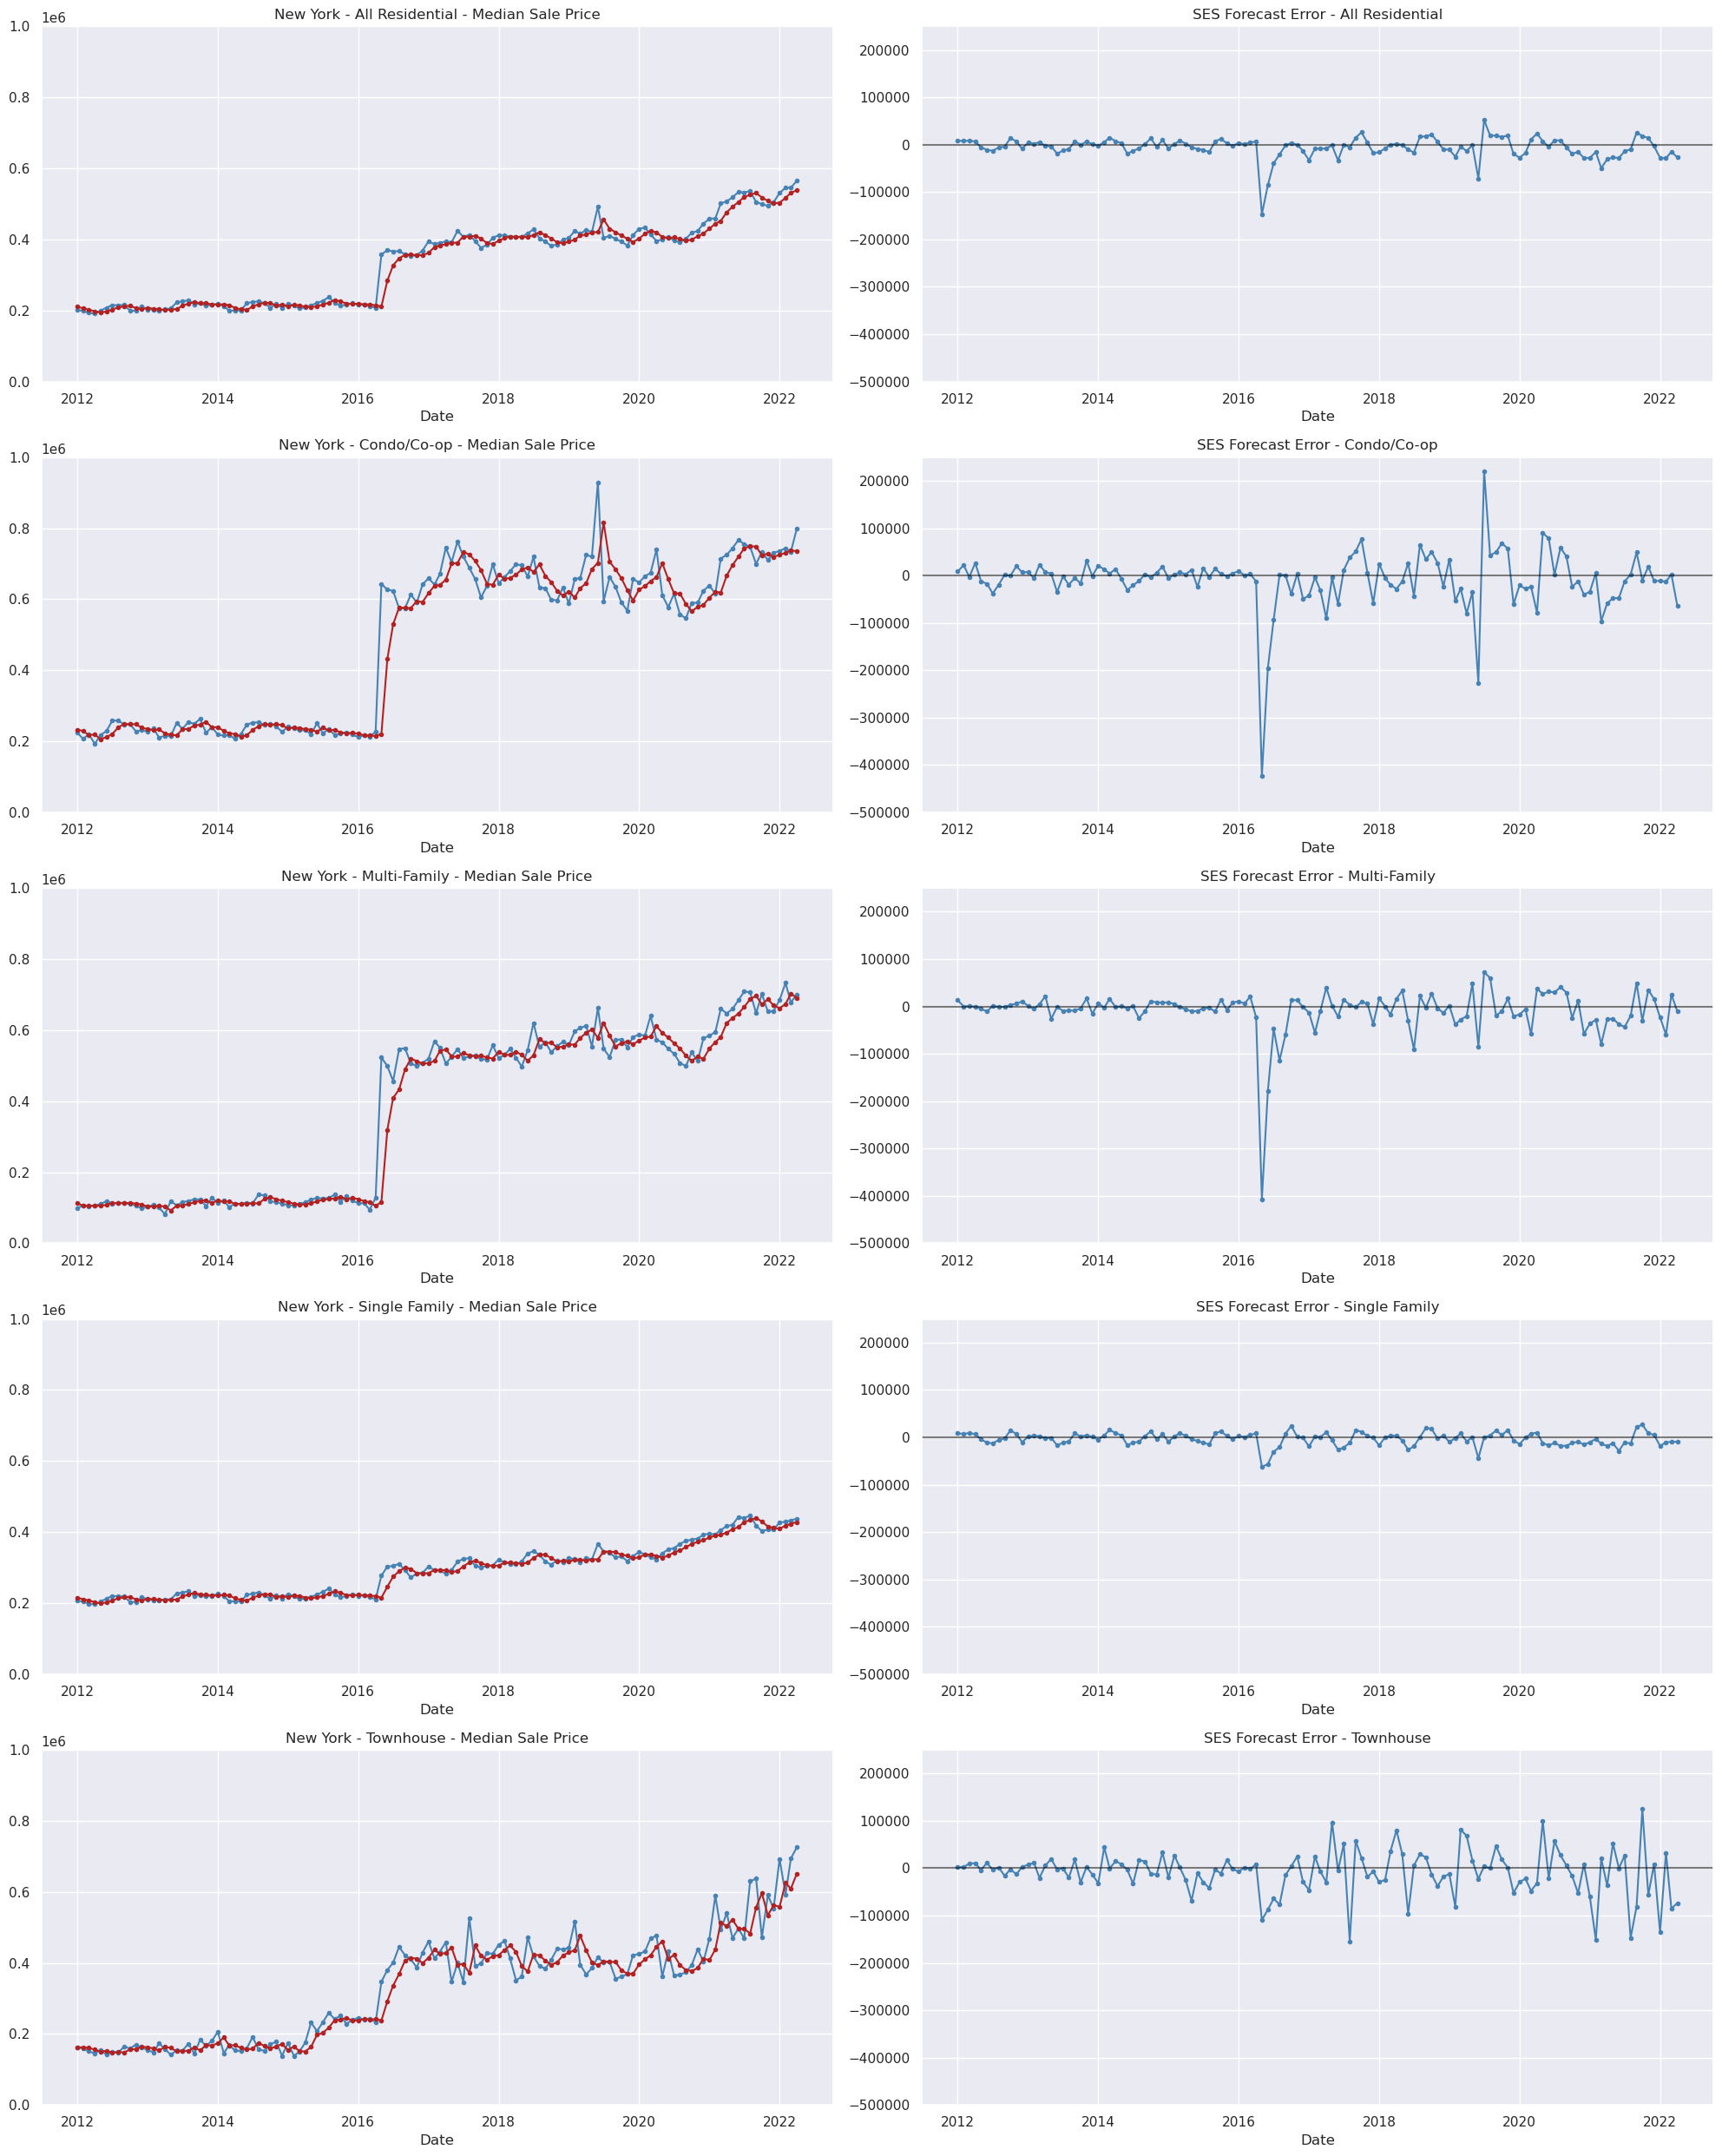

In [17]:
figure = plt.figure(figsize=(20, 25))

axes = figure.add_subplot(5, 2, 1)

axes.plot( NY_ses[0][1], NY_ses[0][2], color="steelblue", marker=".")
axes.plot( NY_ses[0][1], NY_ses[0][3], color="firebrick", marker=".")
axes.set_title( "New York - All Residential - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1000000)

axes = figure.add_subplot(5, 2, 2)

axes.plot( NY_ses[0][1], NY_ses[0][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - All Residential")
axes.set_xlabel('Date')
axes.set_ylim(-500000, 250000)

axes = figure.add_subplot(5, 2, 3)

axes.plot( NY_ses[1][1], NY_ses[1][2], color="steelblue", marker=".")
axes.plot( NY_ses[1][1], NY_ses[1][3], color="firebrick", marker=".")
axes.set_title( "New York - Condo/Co-op - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1000000)

axes = figure.add_subplot(5, 2, 4)

axes.plot( NY_ses[1][1], NY_ses[1][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Condo/Co-op")
axes.set_xlabel('Date')
axes.set_ylim(-500000, 250000)

axes = figure.add_subplot(5, 2, 5)

axes.plot( NY_ses[2][1], NY_ses[2][2], color="steelblue", marker=".")
axes.plot( NY_ses[2][1], NY_ses[2][3], color="firebrick", marker=".")
axes.set_title( "New York - Multi-Family - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1000000)

axes = figure.add_subplot(5, 2, 6)

axes.plot( NY_ses[2][1], NY_ses[2][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Multi-Family")
axes.set_xlabel('Date')
axes.set_ylim(-500000, 250000)

axes = figure.add_subplot(5, 2, 7)

axes.plot( NY_ses[3][1], NY_ses[3][2], color="steelblue", marker=".")
axes.plot( NY_ses[3][1], NY_ses[3][3], color="firebrick", marker=".")
axes.set_title( "New York - Single Family - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1000000)

axes = figure.add_subplot(5, 2, 8)

axes.plot( NY_ses[3][1], NY_ses[3][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Single Family")
axes.set_xlabel('Date')
axes.set_ylim(-500000, 250000)

axes = figure.add_subplot(5, 2, 9)

axes.plot( NY_ses[4][1], NY_ses[4][2], color="steelblue", marker=".")
axes.plot( NY_ses[4][1], NY_ses[4][3], color="firebrick", marker=".")
axes.set_title( "New York - Townhouse - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1000000)

axes = figure.add_subplot(5, 2, 10)

axes.plot( NY_ses[4][1], NY_ses[4][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Townhouse")
axes.set_xlabel('Date')
axes.set_ylim(-500000, 250000)

plt.tight_layout()
plt.show()

New York has greater variation in the median sale price over the last decade compared to other states; as a result, the error for several property types is relatively high which is due to the high variation in median sale prices in New York over time. New York's time series data may benefit from a more complex forecast model. We can try predicting the next median sale price's for the following month:

In [18]:
NY_predict = pd.DataFrame(ses_predict(NY_ses), columns=["property type", "2022-04-01", "(SES) 2022-05-01"])
NY_predict

property type  2022-04-01  (SES) 2022-05-01
0            All Residential   565300.00         552003.29
1                Condo/Co-op   799600.00         767634.22
2    Multi-Family (2-4 Unit)   700900.00         695673.31
3  Single Family Residential   437400.00         432849.34
4                  Townhouse   725600.00         688630.13

Although we see the same issue where the predicted values for the following month are lower than we may expect, New York's predictions are closer to the previous months values. In addition, we cannot know for sure that property values would not have decreased the following month, although it is unexpected. Overall, the simple exponential smoothing prediction will not hold true for very long, even if it is accurate for the 05/01/2022, since we know there is an apparent *upward* trend and SES forecast model will predict the same value for all future dates without additional "actual" data. Let's continue with Texas:

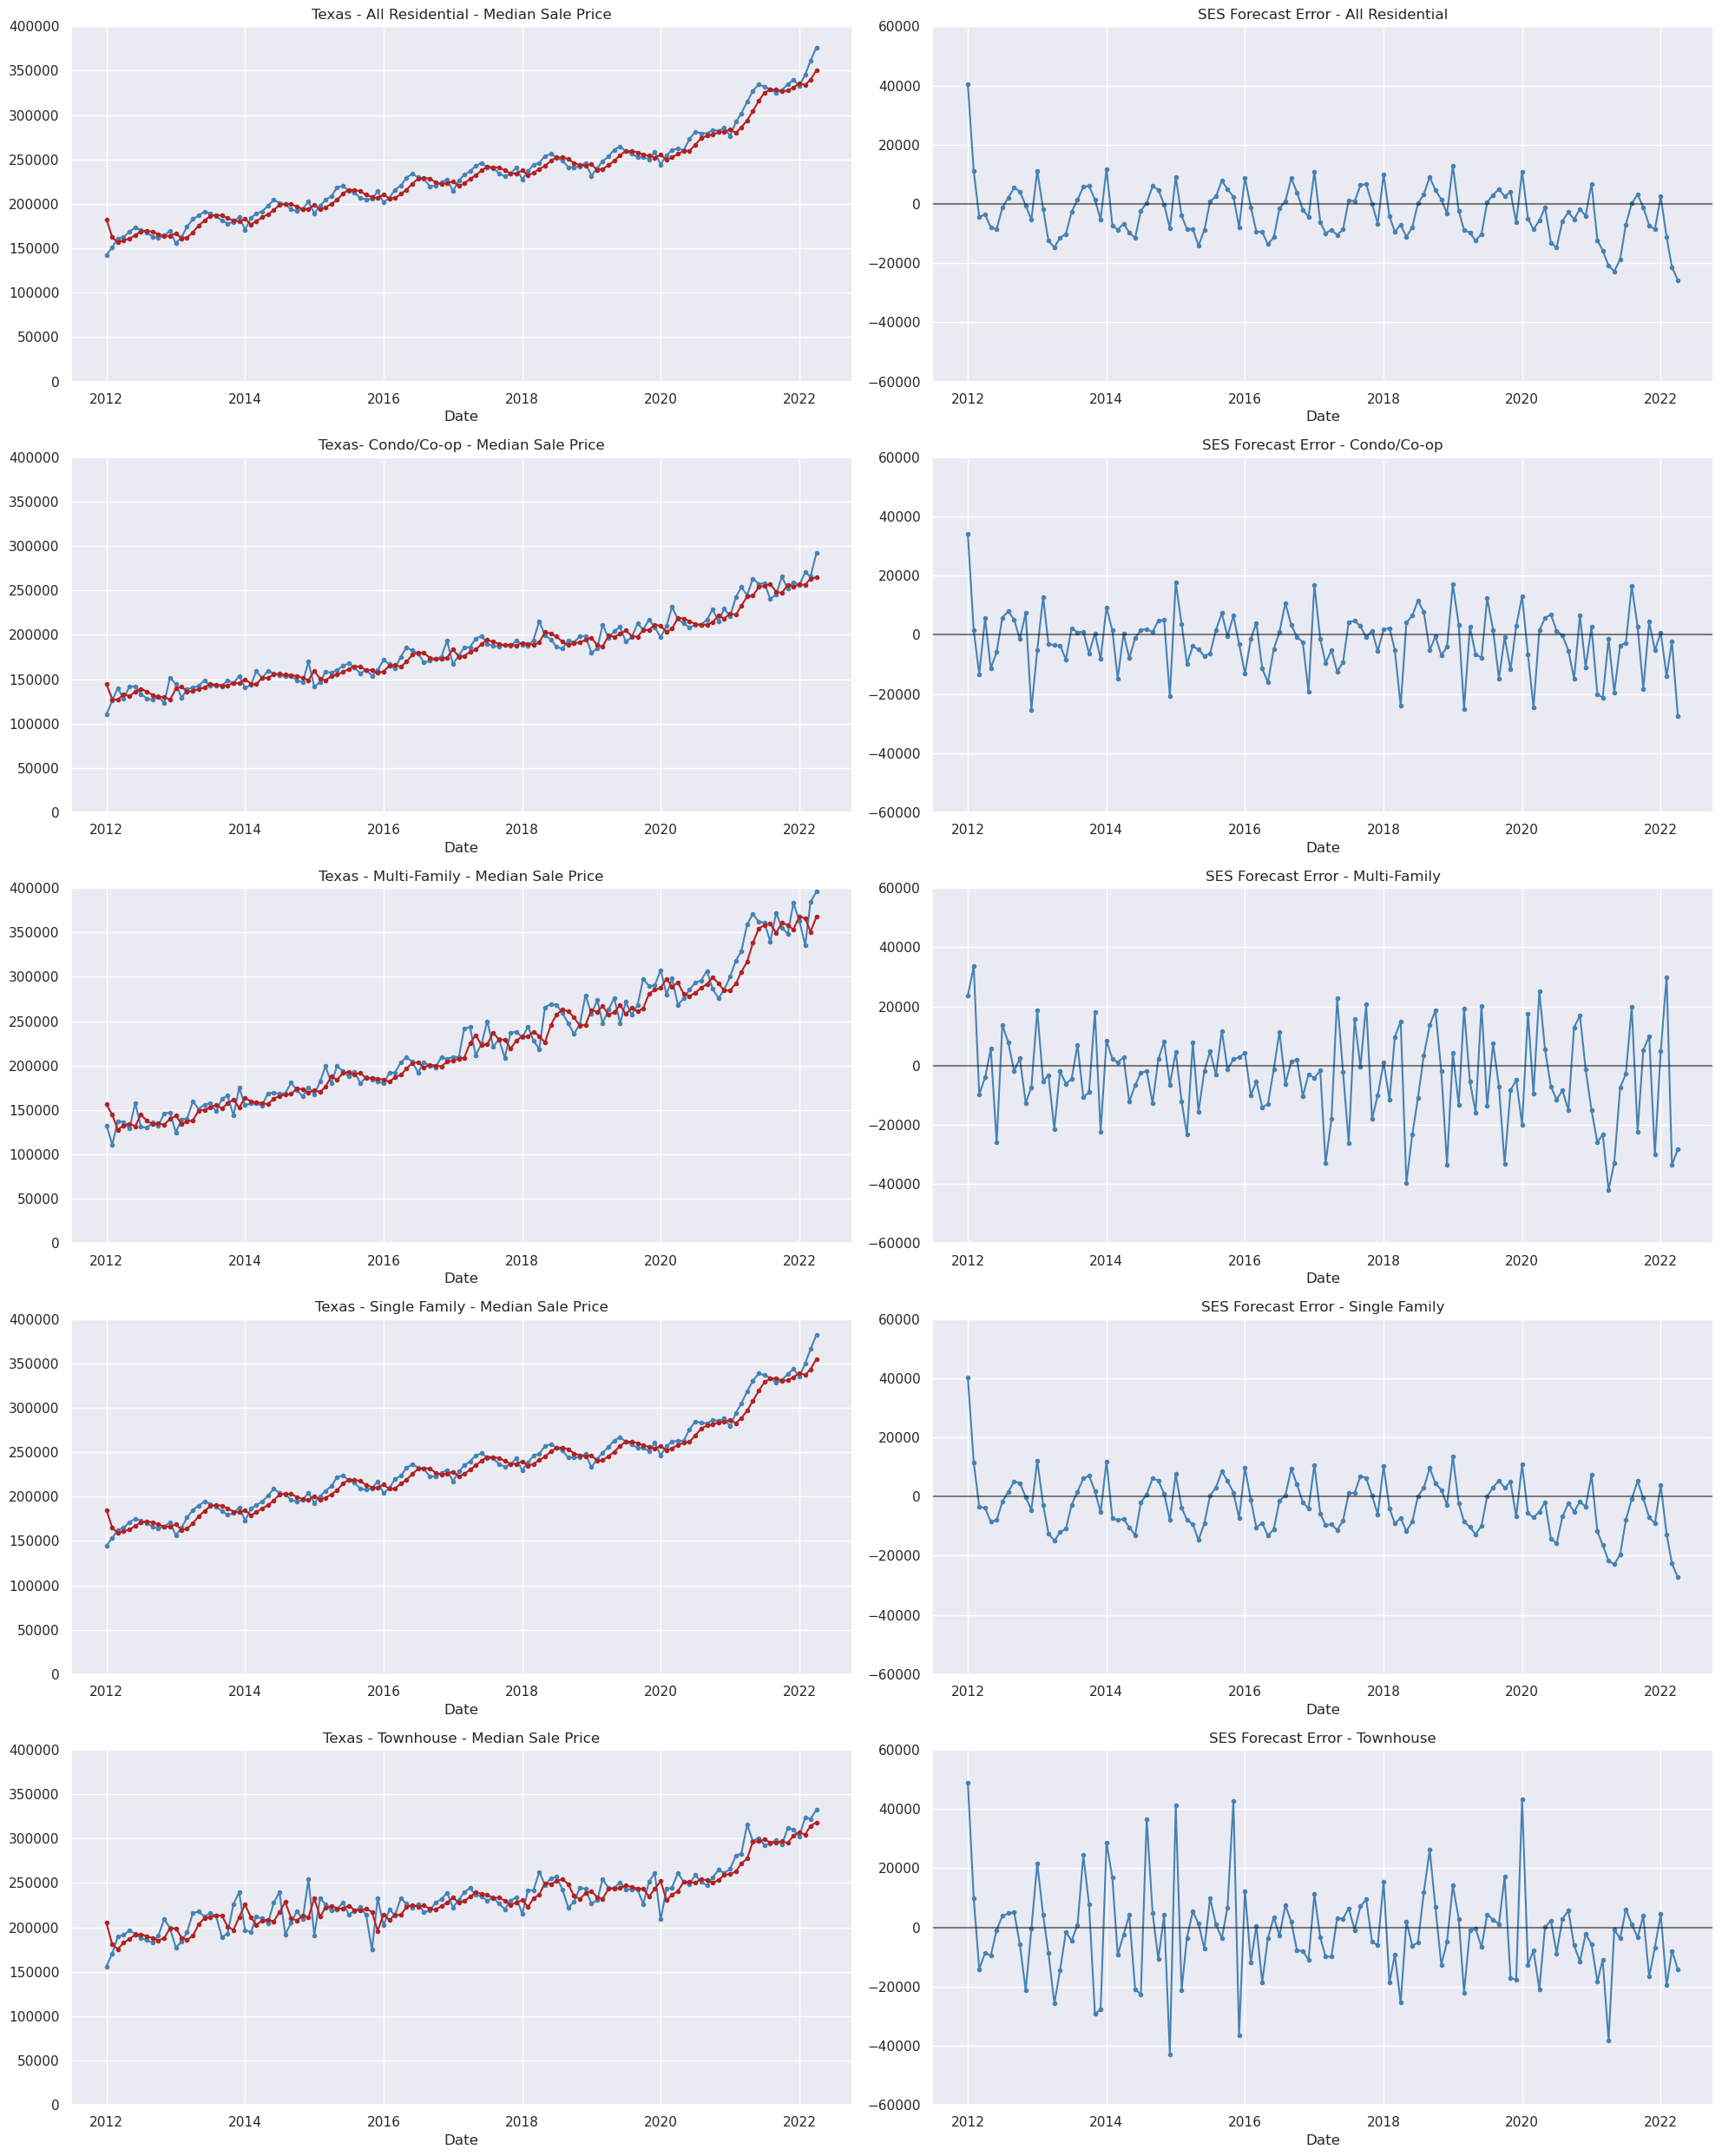

In [19]:
figure = plt.figure(figsize=(20, 25))

axes = figure.add_subplot(5, 2, 1)

axes.plot( TX_ses[0][1], TX_ses[0][2], color="steelblue", marker=".")
axes.plot( TX_ses[0][1], TX_ses[0][3], color="firebrick", marker=".")
axes.set_title( "Texas - All Residential - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 400000)

axes = figure.add_subplot(5, 2, 2)

axes.plot( TX_ses[0][1], TX_ses[0][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - All Residential")
axes.set_xlabel('Date')
axes.set_ylim(-60000, 60000)

axes = figure.add_subplot(5, 2, 3)

axes.plot( TX_ses[1][1], TX_ses[1][2], color="steelblue", marker=".")
axes.plot( TX_ses[1][1], TX_ses[1][3], color="firebrick", marker=".")
axes.set_title( "Texas- Condo/Co-op - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 400000)

axes = figure.add_subplot(5, 2, 4)

axes.plot( TX_ses[1][1], TX_ses[1][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Condo/Co-op")
axes.set_xlabel('Date')
axes.set_ylim(-60000, 60000)

axes = figure.add_subplot(5, 2, 5)

axes.plot( TX_ses[2][1], TX_ses[2][2], color="steelblue", marker=".")
axes.plot( TX_ses[2][1], TX_ses[2][3], color="firebrick", marker=".")
axes.set_title( "Texas - Multi-Family - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 400000)

axes = figure.add_subplot(5, 2, 6)

axes.plot( TX_ses[2][1], TX_ses[2][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Multi-Family")
axes.set_xlabel('Date')
axes.set_ylim(-60000, 60000)

axes = figure.add_subplot(5, 2, 7)

axes.plot( TX_ses[3][1], TX_ses[3][2], color="steelblue", marker=".")
axes.plot( TX_ses[3][1], TX_ses[3][3], color="firebrick", marker=".")
axes.set_title( "Texas - Single Family - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 400000)

axes = figure.add_subplot(5, 2, 8)

axes.plot( TX_ses[3][1], TX_ses[3][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Single Family")
axes.set_xlabel('Date')
axes.set_ylim(-60000, 60000)

axes = figure.add_subplot(5, 2, 9)

axes.plot( TX_ses[4][1], TX_ses[4][2], color="steelblue", marker=".")
axes.plot( TX_ses[4][1], TX_ses[4][3], color="firebrick", marker=".")
axes.set_title( "Texas - Townhouse - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 400000)

axes = figure.add_subplot(5, 2, 10)

axes.plot( TX_ses[4][1], TX_ses[4][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Townhouse")
axes.set_xlabel('Date')
axes.set_ylim(-60000, 60000)

plt.tight_layout()
plt.show()

When we look at the forecast errors for Texas for each property type, they are much lower than the errors we saw with New York which exceeded $+/-$ 10,000 at many points. Although simple exponential smoothing was able to fit the data more efficiently, we will still face the same issue where SES underestimates future values. We can predict the next median sale price as follows:

In [20]:
TX_predict = pd.DataFrame(ses_predict(TX_ses), columns=["property type", "2022-04-01", "(SES) 2022-05-01"])

TX_predict

property type  2022-04-01  (SES) 2022-05-01
0            All Residential   376200.00         363368.82
1                Condo/Co-op   291900.00         278196.70
2    Multi-Family (2-4 Unit)   395800.00         381643.75
3  Single Family Residential   381900.00         368285.95
4                  Townhouse   332400.00         325327.07

The predictions follow a similar pattern as the previous states; predicted values for median sale price are lower than the last time point which may not be accurate given the *upward* trend seen in the housing market. Other than this fact, the states all seem to behave similarly when applying this model. We can continue with Florida:

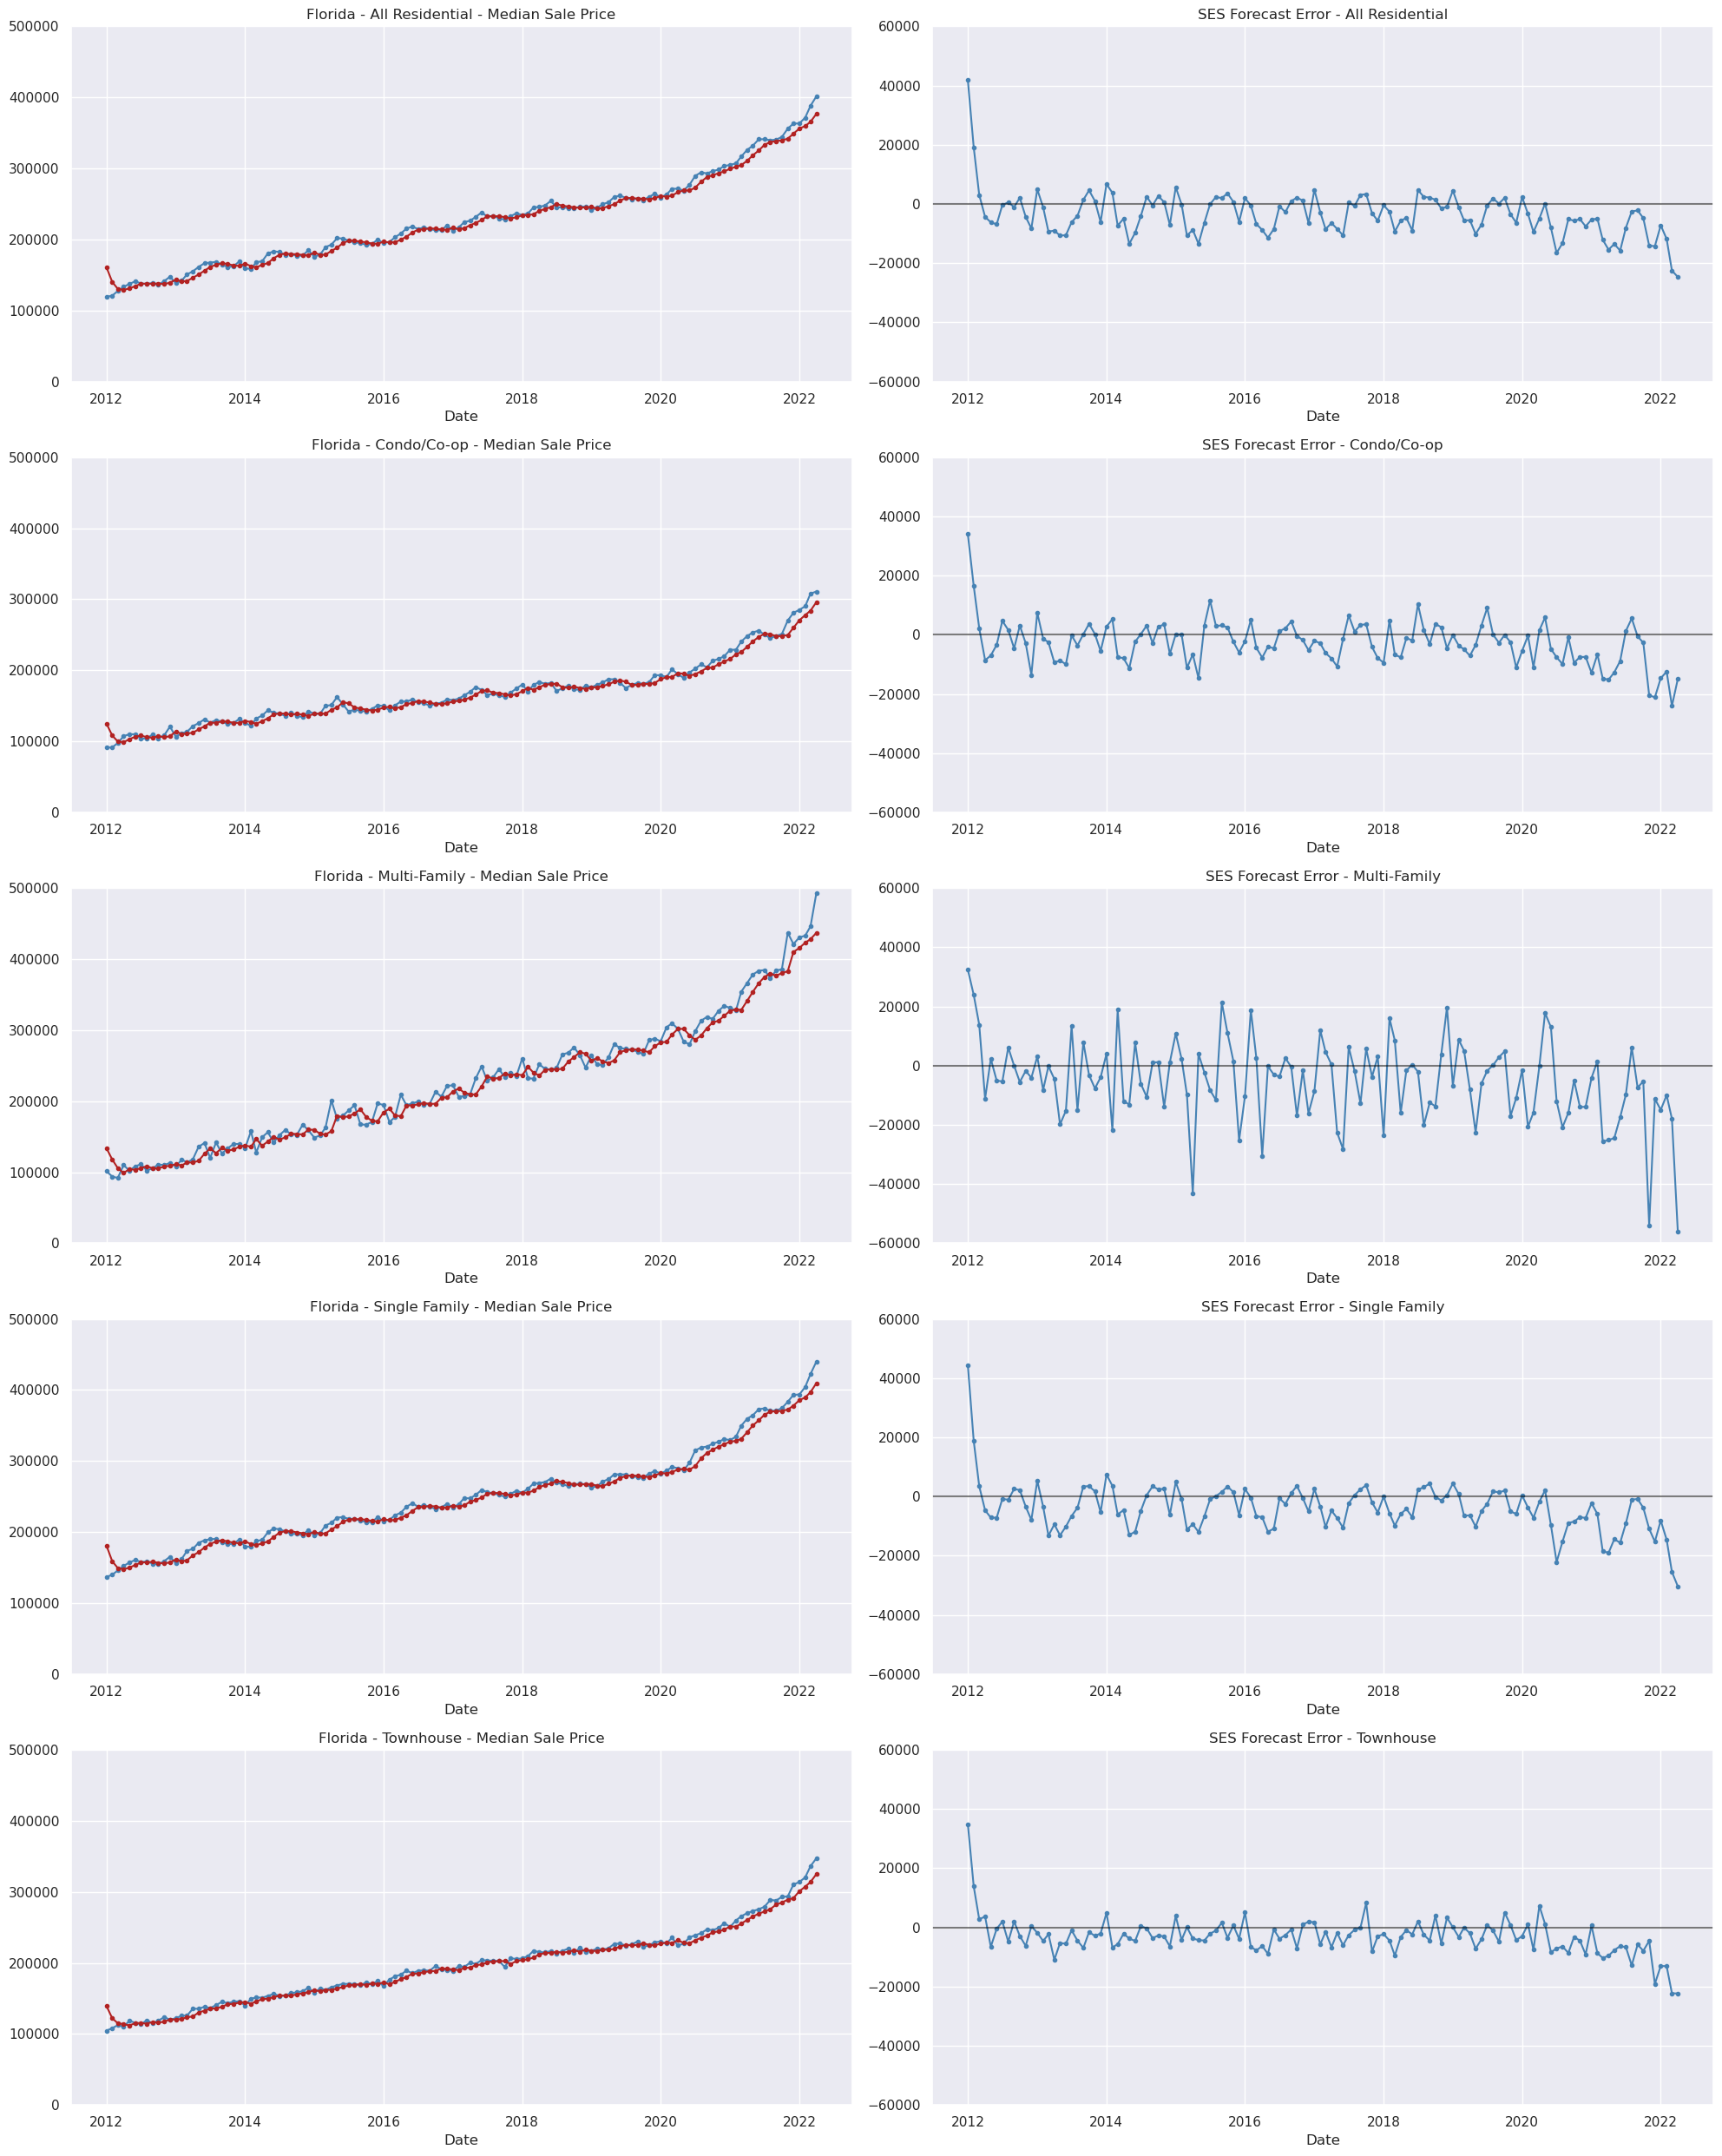

In [21]:
figure = plt.figure(figsize=(20, 25))

axes = figure.add_subplot(5, 2, 1)

axes.plot( FL_ses[0][1], FL_ses[0][2], color="steelblue", marker=".")
axes.plot( FL_ses[0][1], FL_ses[0][3], color="firebrick", marker=".")
axes.set_title( "Florida - All Residential - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 500000)

axes = figure.add_subplot(5, 2, 2)

axes.plot( FL_ses[0][1], FL_ses[0][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - All Residential")
axes.set_xlabel('Date')
axes.set_ylim(-60000, 60000)

axes = figure.add_subplot(5, 2, 3)

axes.plot( FL_ses[1][1], FL_ses[1][2], color="steelblue", marker=".")
axes.plot( FL_ses[1][1], FL_ses[1][3], color="firebrick", marker=".")
axes.set_title( "Florida - Condo/Co-op - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 500000)

axes = figure.add_subplot(5, 2, 4)

axes.plot( FL_ses[1][1], FL_ses[1][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Condo/Co-op")
axes.set_xlabel('Date')
axes.set_ylim(-60000, 60000)

axes = figure.add_subplot(5, 2, 5)

axes.plot( FL_ses[2][1], FL_ses[2][2], color="steelblue", marker=".")
axes.plot( FL_ses[2][1], FL_ses[2][3], color="firebrick", marker=".")
axes.set_title( "Florida - Multi-Family - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 500000)

axes = figure.add_subplot(5, 2, 6)

axes.plot( FL_ses[2][1], FL_ses[2][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Multi-Family")
axes.set_xlabel('Date')
axes.set_ylim(-60000, 60000)

axes = figure.add_subplot(5, 2, 7)

axes.plot( FL_ses[3][1], FL_ses[3][2], color="steelblue", marker=".")
axes.plot( FL_ses[3][1], FL_ses[3][3], color="firebrick", marker=".")
axes.set_title( "Florida - Single Family - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 500000)

axes = figure.add_subplot(5, 2, 8)

axes.plot( FL_ses[3][1], FL_ses[3][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Single Family")
axes.set_xlabel('Date')
axes.set_ylim(-60000, 60000)

axes = figure.add_subplot(5, 2, 9)

axes.plot( FL_ses[4][1], FL_ses[4][2], color="steelblue", marker=".")
axes.plot( FL_ses[4][1], FL_ses[4][3], color="firebrick", marker=".")
axes.set_title( "Florida - Townhouse - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 500000)

axes = figure.add_subplot(5, 2, 10)

axes.plot( FL_ses[4][1], FL_ses[4][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Townhouse")
axes.set_xlabel('Date')
axes.set_ylim(-60000, 60000)

plt.tight_layout()
plt.show()

Like California, Florida has a similar pattern in the forecast errors. The early and recent time points have greater error which could be due to the nature of the upward trend in median sale prices over time. As stated previously, SES is not very efficient for time series data with an upward trend. Let's formulate the prediction for the next month:

In [22]:
FL_predict = pd.DataFrame(ses_predict(FL_ses), columns=["property type", "2022-04-01", "(SES) 2022-05-01"])

FL_predict

property type  2022-04-01  (SES) 2022-05-01
0            All Residential   401500.00         389173.56
1                Condo/Co-op   310900.00         303446.37
2    Multi-Family (2-4 Unit)   493100.00         465055.45
3  Single Family Residential   439900.00         424729.59
4                  Townhouse   347300.00         336135.09


As seen previously, the forecast model predicts values lower than the last actual time point due to the shifted nature of the SES forecast data. These predictions will be important for comparison sake when we begin generating different forecasting models for the same data. Finally, we can look at Washington D.C.:

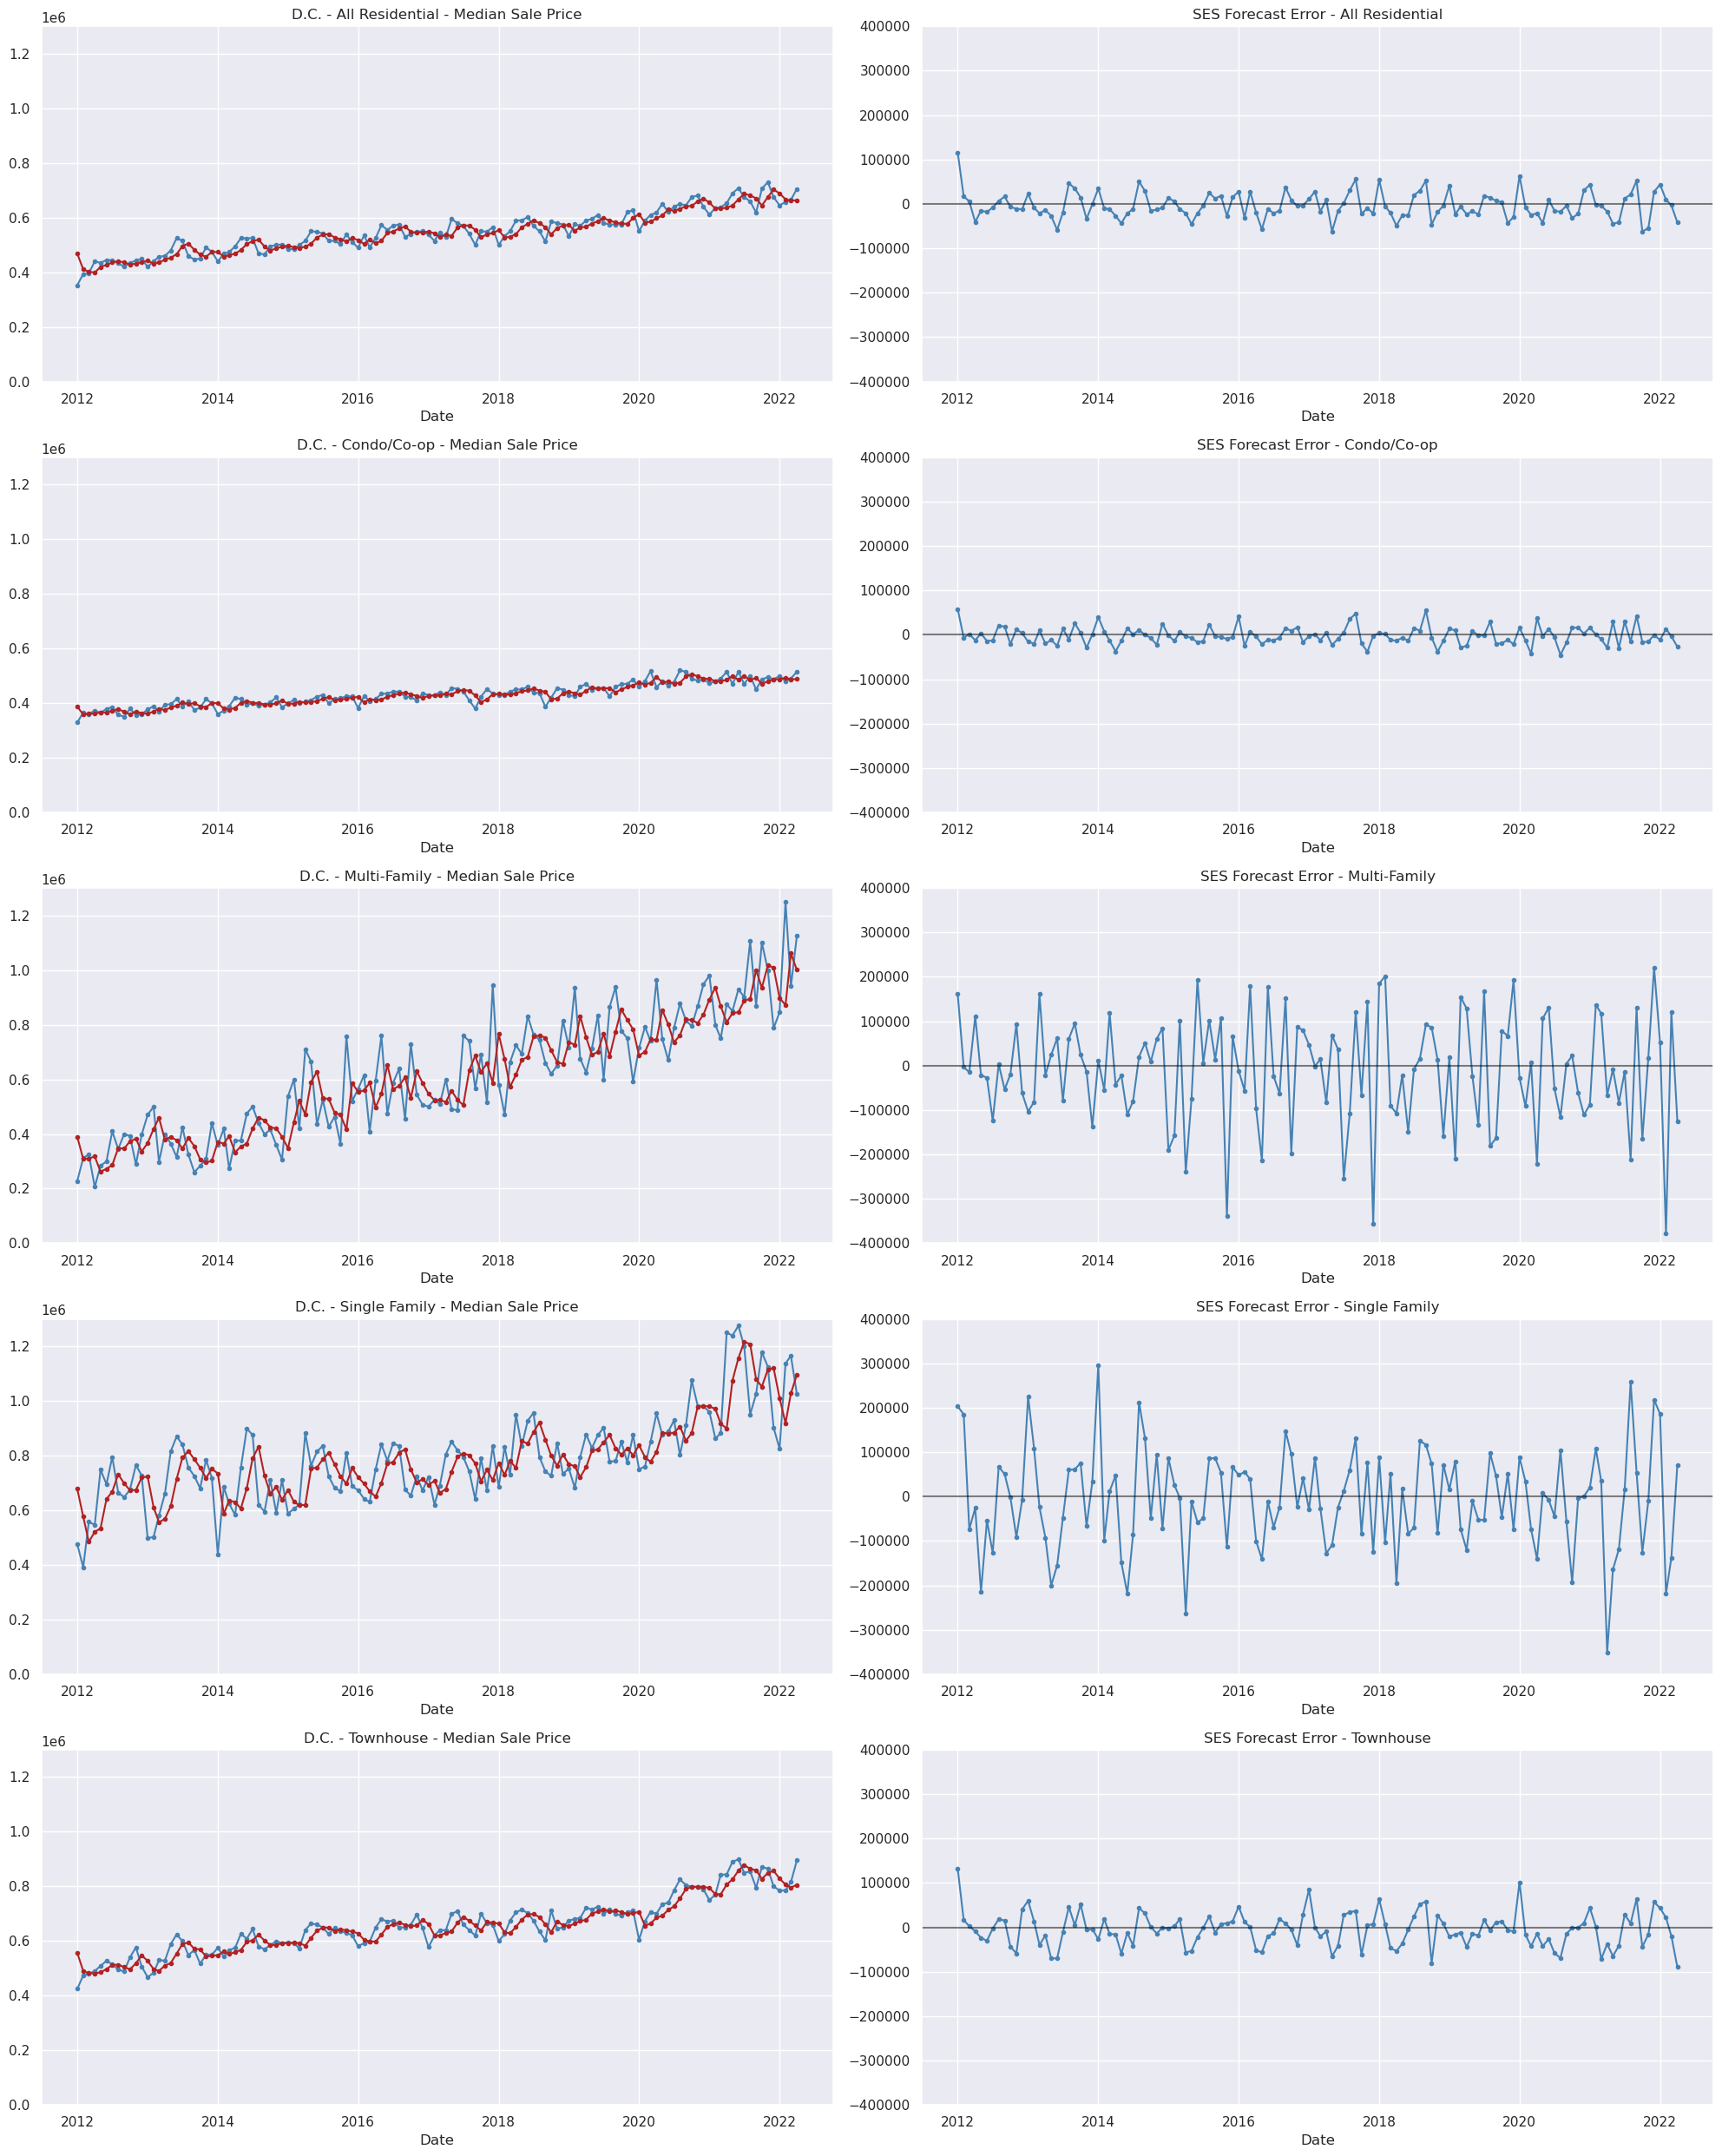

In [23]:
figure = plt.figure(figsize=(20, 25))

axes = figure.add_subplot(5, 2, 1)

axes.plot( DC_ses[0][1], DC_ses[0][2], color="steelblue", marker=".")
axes.plot( DC_ses[0][1], DC_ses[0][3], color="firebrick", marker=".")
axes.set_title( "D.C. - All Residential - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1300000)

axes = figure.add_subplot(5, 2, 2)

axes.plot( DC_ses[0][1], DC_ses[0][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - All Residential")
axes.set_xlabel('Date')
axes.set_ylim(-400000, 400000)

axes = figure.add_subplot(5, 2, 3)

axes.plot( DC_ses[1][1], DC_ses[1][2], color="steelblue", marker=".")
axes.plot( DC_ses[1][1], DC_ses[1][3], color="firebrick", marker=".")
axes.set_title( "D.C. - Condo/Co-op - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1300000)

axes = figure.add_subplot(5, 2, 4)

axes.plot( DC_ses[1][1], DC_ses[1][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Condo/Co-op")
axes.set_xlabel('Date')
axes.set_ylim(-400000, 400000)

axes = figure.add_subplot(5, 2, 5)

axes.plot( DC_ses[2][1], DC_ses[2][2], color="steelblue", marker=".")
axes.plot( DC_ses[2][1], DC_ses[2][3], color="firebrick", marker=".")
axes.set_title( "D.C. - Multi-Family - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1300000)

axes = figure.add_subplot(5, 2, 6)

axes.plot( DC_ses[2][1], DC_ses[2][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Multi-Family")
axes.set_xlabel('Date')
axes.set_ylim(-400000, 400000)

axes = figure.add_subplot(5, 2, 7)

axes.plot( DC_ses[3][1], DC_ses[3][2], color="steelblue", marker=".")
axes.plot( DC_ses[3][1], DC_ses[3][3], color="firebrick", marker=".")
axes.set_title( "D.C. - Single Family - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1300000)

axes = figure.add_subplot(5, 2, 8)

axes.plot( DC_ses[3][1], DC_ses[3][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Single Family")
axes.set_xlabel('Date')
axes.set_ylim(-400000, 400000)

axes = figure.add_subplot(5, 2, 9)

axes.plot( DC_ses[4][1], DC_ses[4][2], color="steelblue", marker=".")
axes.plot( DC_ses[4][1], DC_ses[4][3], color="firebrick", marker=".")
axes.set_title( "D.C. - Townhouse - Median Sale Price")
axes.set_xlabel('Date')
axes.set_ylim(0, 1300000)

axes = figure.add_subplot(5, 2, 10)

axes.plot( DC_ses[4][1], DC_ses[4][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_title( "SES Forecast Error - Townhouse")
axes.set_xlabel('Date')
axes.set_ylim(-400000, 400000)

plt.tight_layout()
plt.show()

Washington D.C. contains the most variability out of the six selected states for forecasting. The forecast errors are notably higher than most of the states, besides New York. The red lines (SES) are dampened versions of the actual data but they still are not very smooth compared to the SES data for other states. This could make the shifted nature of the data even more troublesome for predictions. Let's try formulating a prediction for the following month:

In [24]:
DC_predict = pd.DataFrame(ses_predict(DC_ses), columns=["property type", "2022-04-01", "(SES) 2022-05-01"])

DC_predict

property type  2022-04-01  (SES) 2022-05-01
0            All Residential   705000.00         684274.78
1                Condo/Co-op   515000.00         501633.80
2    Multi-Family (2-4 Unit)  1125000.00        1062694.26
3  Single Family Residential  1025000.00        1060617.64
4                  Townhouse   895000.00         850345.55

Besides the single family time series, the data follows similar trends as previous states where the predicted value for the following month is smaller than the last time point in the actual data. In addition, "All residential" has a larger difference between the two values, indicating that the variation in the D.C. data makes the SES model very difficult to use. 

Overall, simple exponential smoothing works best for time series data that is more stable over time. Since we are dealing with a consistent and, at times, strong *upward* trend, we need to broaden ourselves to more complex forecasting models that factor in trends. 

<a id="4"></a>

### Holt's Trend Corrected Smoothing

[Back to Contents](#0)


Since we want to factor in trends over time, we can use Holt's Trend Corrected Smoothing. In comparison to Simple Exponential Smoothing, we won't get the same value for each future time point. Instead, we will use the estimated trend, which is based on linear regression coefficients, to predict future values. Our forecast model is:

$forecast_{t} = level_{t} + trend_{t} + \epsilon$

For each forecast, we need the current level and an updated estimate of the trend.

$level_{t} = (level_{t-1} + trend_{t-1}) + \alpha (x_{t-1} - (level_{t-1} + trend_{t-1}))$

$trend_{t} = trend_{t-1} + \gamma \alpha (x_{t-1} - (level_{t-1} + trend_{t-1}))$


Due to the number of time series data sets we are dealing with, we will focus on the "All Residential" property type for the same six states that we have been working with so far. First, we will need to generate a function that extracts the data into easy to index data structures:

In [25]:
def extract_data(state=str):
    ind = []
    result = []

    for item in state_keys:
        if item[0] == state:
            ind.append([state_keys.index(item), item[1]]) 
            

    for index in ind:
        date_ = state_grouped.get_group(state_keys[index[0]]).period_begin
        series_ = state_grouped.get_group(state_keys[index[0]]).median_sale_price
      
        
        x = pd.concat([date_, series_], axis=1).reset_index(drop=True)
        x['t'] = range(1, len(x)+1)
        result.append([index[1], x]) 

    return result

In [26]:
AK = extract_data(state='AK')
CA = extract_data(state='CA')
NY = extract_data(state='NY')
TX = extract_data(state='TX')
FL = extract_data(state='FL')
DC = extract_data(state='DC')

Next, we will formulate three functions, which we will use to regress median_sale_price against "t", which is a transformation on the date variable, and create our forecasting model. Specifically, "t" is a set of integers that increases with each month in "period_begin". 

The first function will perform linear regression of median_sale_price and time. 

The second function will be used to evaluate the regression model by displaying the $R^{2}$, intercept, error values, etc. 

The final function will implement Holts Trend Corrected Smoothing using the intercept $\beta_{0}$ as the estimate for the initial level and the slope $\beta_{1}$ as the estimate for the initial trend. 

In [27]:
def lm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    result[ "r^2"] = model.score( X, y)
    
    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    sum_squared_error = sum([ e**2 for e in result[ "residuals"]])[ 0]

    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    result[ "sigma"] = np.sqrt( sum_squared_error / (n - k))
    
    return result

In [28]:
def describe_fit( result, return_coefficient=True):
    formula = result[ "formula"]
    print("regression: ", formula)
    print("n: ", result[ "n"])
    print("--------------------------------")
    variables = formula.split("~")[1].split( "+")
    variables = ["intercept"] + variables
    coefficients = result[ "coefficients"]
    for variable, coefficient in zip( variables, coefficients):
        print(variable.strip() + ": ", coefficient)
    print("--------------------------------")
    print("sigma", result[ "sigma"])
    print("R^2", result[ "r^2"])
    if return_coefficient is True:
        return coefficients

In [29]:
def holts_one_step( alpha, gamma, level, trend, error):
    this_trend = trend + gamma * alpha * error
    this_level = level + trend + alpha * error
    return (this_trend, this_level)

def holts_forecast( level_0, trend_0, alpha, gamma, actual):
    n = len( actual)
    trend, level = trend_0, level_0
    trends = []
    levels = []
    forecasts = []
    
    for i in range( 0, n):
        forecast = level + trend
        forecasts.append( forecast)
        
        error = actual[ i] - forecast
        trend, level = holts_one_step( alpha, gamma, level, trend, error)
        
        trends.append( trend)
        levels.append( level)

    return (pd.Series( forecasts), pd.Series( levels), pd.Series( trends))

Now that we have the three functions, we can start with Arkansas. First, we will perform linear regression with $y$ as median_sale_price and $x$ as time (t). 

In [30]:
describe_fit(lm( "median_sale_price ~ t", data=AK[0][1]), return_coefficient=False)

regression:  median_sale_price ~ t
n:  124
--------------------------------
intercept:  241403.02911093627
t:  617.5128245475987
--------------------------------
sigma 13230.956765899227
R^2 0.739355700738399


Based on the results, each time point adds \$617.51 to the median sale price. When we performed SES, we used the first third of values to estimate the initial level (about 42 of the values). Therefore, we will do the same here:

In [31]:
AK_all_fit = lm( "median_sale_price ~ t", data=AK[0][1].iloc[0:42])
AK_beta = describe_fit( AK_all_fit)

regression:  median_sale_price ~ t
n:  42
--------------------------------
intercept:  247180.13937282213
t:  507.2360424600941
--------------------------------
sigma 8602.548080765931
R^2 0.3490951768651416


Next, we need to determine the ideal $\alpha$ and $\gamma$, which we can do using grid search. For ease, we will write a function that can perform grid search using our previously created functions as follows:

In [32]:
def grid_search_holts(beta0, beta1, data, values = list):
    if len(values) == 1:
        grid = pd.DataFrame( columns=values[0])

        for alpha in values[0]:
            sse_ = []

            for gamma in values[0]:
                holts, _, _ = holts_forecast( beta0, beta1, alpha, gamma, data)
                sse = ((holts - data)**2.0).sum()
                sse_.append(sse)
        
            grid.loc[len(grid)] = sse_
    
    elif len(values) == 2:
        grid = pd.DataFrame( columns=values[1])

        for alpha in values[0]:
            sse_ = []

            for gamma in values[1]:
                holts, _, _ = holts_forecast( beta0, beta1, alpha, gamma, data)
                sse = ((holts - data)**2.0).sum()
                sse_.append(sse)
        
            grid.loc[len(grid)] = sse_
        
    grid.index = values[0]   
    min_error = grid.to_numpy().min()
    gamma_ = grid.columns[grid.eq(min_error).any()][0]
    alpha_ = grid.index[grid[gamma_]==min_error][0]
    return grid, alpha_, gamma_

In [33]:
values = [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

AK_grid, AK_alpha, AK_gamma = grid_search_holts(AK_beta[0], AK_beta[1], AK[0][1].median_sale_price, values=values)
print(f"Alpha: {AK_alpha} \
        Gamma: {AK_gamma}")

AK_grid

Alpha: 0.8         Gamma: 0.1


0.10           0.20           0.30           0.40           0.50           0.60           0.70           0.80           0.90
0.10 13289660047.86 12890494931.45 13205617664.70 13738826206.22 14342959328.51 15123902620.50 16110928234.21 17296673938.32 18657222549.72
0.20 12439926720.77 13399440420.56 14728826302.68 16413268789.36 18489960978.54 21018152526.46 24089523692.69 27757380323.99 31921256120.87
0.30 12358004201.76 13794351335.03 15595149674.55 17711879842.55 20036019027.75 22308413380.12 24110162844.23 25042290564.67 24995002111.38
0.40 12045899464.11 13486922686.22 15074386983.08 16594434307.37 17770635244.63 18381312393.22 18414828896.41 18063730014.98 17573285941.75
0.50 11616994671.87 12843627356.19 13994577314.65 14862714972.17 15336422727.06 15468262946.85 15421117716.24 15355376447.44 15370342666.17
0.60 11248786787.39 12267025829.16 13120186606.55 13706832257.96 14055766473.64 14285241043.34 14517041763.65 14828170059.44 15251554935.43
0.70 11030957173.56 11928158192.88 12665616731.40 13224868110.45 13681475943.40 14136050116.10 14661815089.40 15295141912.25 16048062986.78
0.80 10982458177.25 11844451117.23 12589221548.37 13240995515.58 13878062654.81 14573942504.52 15372859607.59 16293805293.28 17341775366.34
0.90 11092781115.26 11983972754.06 12808333547.37 13607293528.75 14449129953.56 15386777488.22 16448562086.16 17645499132.23 18979950228.99

Now that we have narrowed down the alpha and gamma values, we can perform a second grid search that increases by 0.01 around the selected alpha and gamma values above. 

In [34]:
values = [[0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89],
          [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]]

AK_grid, AK_alpha, AK_gamma = grid_search_holts(AK_beta[0], AK_beta[1], AK[0][1].median_sale_price, values=values)
print(f"Alpha: {AK_alpha} \
        Gamma: {AK_gamma}")

AK_grid

Alpha: 0.78         Gamma: 0.01


0.01           0.02           0.03           0.04           0.05           0.06           0.07           0.08           0.09           0.10           0.11           0.12  \
0.71 10243983234.28 10317107073.90 10394620848.17 10476542188.32 10562170375.35 10650638192.47 10741134942.92 10832973801.39 10925594711.91 11018545565.62 11111459609.77 11204035548.82   
0.72 10236009845.04 10309172686.21 10386634987.62 10468400463.96 10553774215.05 10641901765.72 10731986148.82 10823353035.67 10915453143.00 11007843601.57 11100165749.02 11192125608.21   
0.73 10229357809.90 10302583846.05 10380022588.69 10461664855.72 10546821795.81 10634651575.69 10724370768.86 10815317367.82 10906952730.88 10998843140.12 11090637965.16 11182050503.72   
0.74 10224016679.30 10297330820.35 10374774541.89 10456326715.04 10541304739.47 10628879315.27 10718280364.53 10808858021.63 10900084148.29 10991534079.07 11082865143.63 11173797855.33   
0.75 10219975470.98 10293403210.95 10370880936.66 10452376457.62 10537213600.73 10624575482.72 10713705179.24 10803964783.62 10894836516.29 10985904655.82 11076834407.73 11167353427.64   
0.76 10217222787.97 10290790087.78 10368331210.83 10449803729.76 10534538050.95 10621729583.52 10710634358.90 10800626243.11 10891197664.65 10981941728.88 11072531422.00 11162701455.90   
0.77 10215746931.62 10289480116.04 10367114292.78 10448597566.18 10533267052.16 10620330321.02 10709056159.83 10798830017.98 10889154376.09 10979631041.26 11069940675.35 11159824949.54   
0.78 10215536009.66 10289461677.38 10367218736.67 10448746539.78 10533389021.73 10620365776.52 10708958144.60 10798562966.84 10888692615.29 10978957466.87 11069045745.46 11158705974.80   
0.79 10216578039.65 10290722985.66 10368632851.14 10450238903.74 10534891988.23 10621823579.22 10710327366.57 10799811388.49 10889797743.78 10979905241.18 11069829545.47 11159325918.00   
0.80 10218861048.05 10293252197.38 10371344821.78 10453062726.42 10537763739.10 10624691066.98 10713150543.90 10802561209.67 10892454721.64 10982458177.25 11072274554.69 11161665730.80   
0.81 10222373165.18 10297037517.23 10375342827.89 10457206019.67 10541991960.72 10628955438.31 10717414223.94 10806798161.88 10896648297.12 10986599868.36 11076363034.29 11165706159.33   
0.82 10227102716.33 10302067299.19 10380615153.95 10462656860.96 10547564371.44 10634603896.56 10723104938.57 10812507948.30 10902363185.24 10992313878.40 11082077229.68 11171427958.35   
0.83 10233038309.46 10308330143.39 10387150296.21 10469403509.94 10554468848.24 10641623786.82 10730209351.61 10819676401.67 10909584236.33 10999583921.23 11089399560.62 11178812092.21   
0.84 10240168919.65 10315814989.33 10394937064.91 10477434519.91 10562693547.61 10650002726.31 10738714398.76 10828289634.04 10918296595.62 11008394030.05 11098312800.49 11187839923.78   
0.85 10248483970.82 10324511205.64 10403964682.60 10486738844.78 10572227021.26 10659728728.92 10748607421.11 10838334179.21 10928485854.72 11018728718.01 11108800245.80 11198493392.92   
0.86 10257973414.90 10334408676.98 10414222878.92 10497305941.98 10583058327.23 10670790324.62 10759876292.84 10849797128.84 10940138196.06 11030573130.95 11120845877.33 11210755185.69   
0.87 10268627808.91 10345497888.26 10425701982.39 10509125871.89 10595177137.00 10683176674.25 10772509543.85 10862666262.83 10953240531.15 11043913193.46 11134434513.76 11224608895.51   
0.88 10280438390.11 10357770006.75 10438393009.57 10522189394.14 10608573839.10 10696877680.52 10786496478.00 10876930174.96 10967780633.48 11058735749.03 11149551959.04 11240039177.57   
0.89 10293397149.70 10371216962.27 10452287752.00 10536488061.52 10623239639.86 10711884095.59 10801827287.69 10892578394.36 10983747266.94 11075028695.29 11166185144.39 11257031897.40   

               0.13           0.14           0.15           0.16           0.17           0.18           0.19  
0.71 11296021928.10 11387205564.22 11477403255.00 11566455970.19 11654224851.99 11740588507.16 11825441205.77  
0.72 11283478576.82 1137401808

Using the ideal alpha and gamma values, we can implement the Holts Trend corrected smoothing model as follows, and plot the results:

In [35]:
AK_holts, AK_levels, AK_trends = holts_forecast(AK_beta[0], AK_beta[1], AK_alpha, AK_gamma, AK[0][1].median_sale_price)

AK_error = AK_holts - AK[0][1].median_sale_price

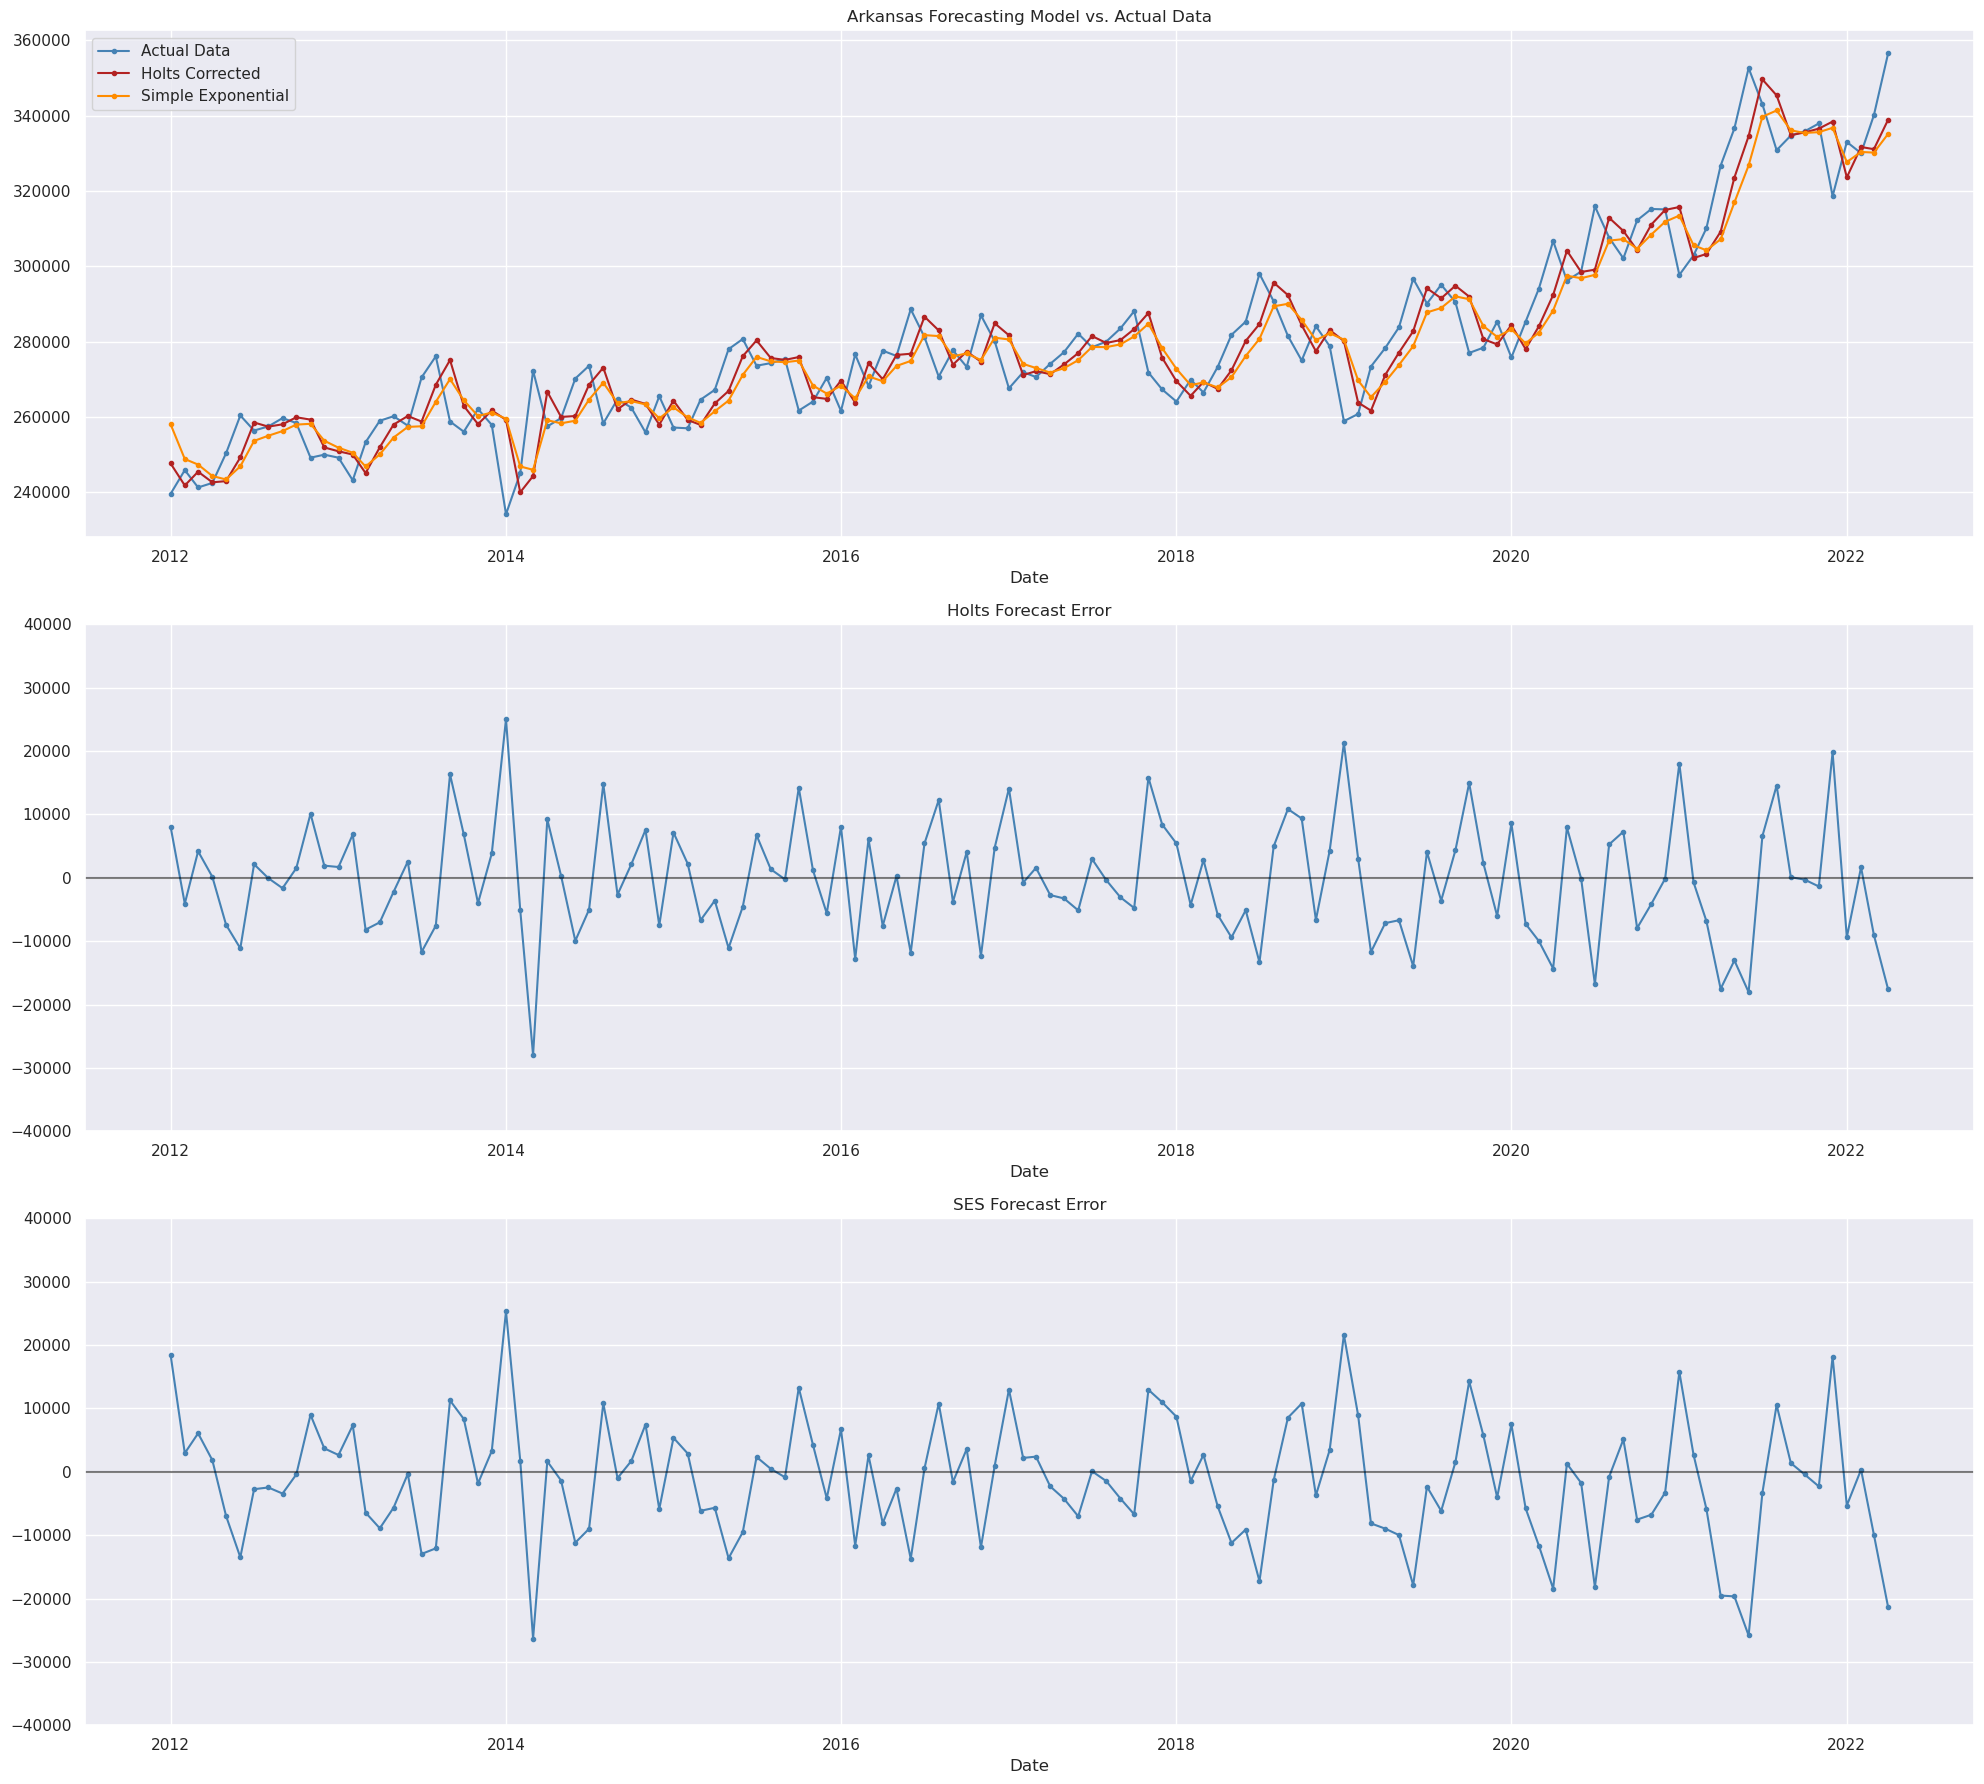

In [36]:
figure = plt.figure(figsize=(20, 18))

axes = figure.add_subplot(3, 1, 1)

axes.plot( AK[0][1].period_begin, AK[0][1].median_sale_price, color="steelblue", marker=".")
axes.plot( AK[0][1].period_begin, AK_holts, color="firebrick", marker=".")
axes.plot( AK[0][1].period_begin, AK_ses[0][3], color="darkorange", marker=".")
axes.set_xlabel( "Date")
axes.set_title("Arkansas Forecasting Model vs. Actual Data")
axes.legend(['Actual Data', 'Holts Corrected', 'Simple Exponential'])

axes = figure.add_subplot(3, 1, 2)

axes.plot( AK[0][1].period_begin, AK_error, color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_ylim(-40000, 40000)
axes.set_xlabel( "Date")
axes.set_title( "Holts Forecast Error")

axes = figure.add_subplot(3, 1, 3)

axes.plot( AK[0][1].period_begin, AK_ses[0][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_ylim(-40000, 40000)
axes.set_xlabel( "Date")
axes.set_title( "SES Forecast Error")

plt.tight_layout()
plt.show()

Visually, Holts Trend Corrected Smoothing model follows the actual data more closely than Simple Exponential Smoothing. The errors are also smaller, further showing how factoring in trend is beneficial for our time series data. Seasonality may not be a major issue for Arkansas's time series data, but the same may not hold true for the next few states. For now, let's try predicting a few future values:

In [37]:
def holts_predict(level, trend, time_points):
    result = []
    for i in range(0, len(time_points)):
        n = len(level) - 1                           # index of last time point in data
        dis = time_points[i] - n                # distance between last time point and current one
        predict = level[n] + dis * trend[n] 
        result.append(predict) 
    return result

In [38]:
# 124 (index 123) is the last time point in the data
time_index = [124, 125, 126, 127]

AK_holts_predict = pd.DataFrame([holts_predict(AK_levels, AK_trends, time_index)], 
                                columns = ["(holts) 2022-05-01", "(holts) 2022-06-01", "(holts) 2022-07-01", "(holts) 2022-08-01"])

AK_ses_predict = pd.DataFrame(AK_predict.iloc[0]).T # Just All Residential prediction


AK_predict_compare = pd.concat([AK_ses_predict, AK_holts_predict], axis=1)

print(tabulate(AK_predict_compare.T[1:], headers = ['date','median sale price'],  tablefmt = 'fancy_grid'))


╒════════════════════╤═════════════════════╕
│ date               │   median sale price │
╞════════════════════╪═════════════════════╡
│ 2022-04-01         │              356500 │
├────────────────────┼─────────────────────┤
│ (SES) 2022-05-01   │              345817 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-05-01 │              353544 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-06-01 │              354461 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-07-01 │              355378 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-08-01 │              356295 │
╘════════════════════╧═════════════════════╛


Upon comparison, we see that the holts corrected model predicts a greater value that SES, even though the value is still slightly lower than the previous month (this is very possible, although not expected). However, if we look at the following months according to holts corrected, we see the upward trend in median sale price. This aspect is missing from simple exponential smoothing and, therefore, makes holts trend corrected smoothing a superior forecasting model for this time series data.

Moving on with California, we will perform linear regression with $y$ as median_sale_price and $x$ as time (t). 

In [39]:
describe_fit(lm( "median_sale_price ~ t", data=CA[0][1]), return_coefficient=False)

regression:  median_sale_price ~ t
n:  124
--------------------------------
intercept:  316150.9441384736
t:  3307.107474429581
--------------------------------
sigma 34276.15805419467
R^2 0.9237975833192409


Based on the results, each time point adds $\$$3,307.11 to the median sale price. Like before, we will estimate $\beta_{0}$ and $\beta_{1}$ using the first third of values (about 42 values).

In [40]:
CA_all_fit = lm( "median_sale_price ~ t", data=CA[0][1].iloc[0:42])
CA_beta = describe_fit( CA_all_fit)

regression:  median_sale_price ~ t
n:  42
--------------------------------
intercept:  310907.3170731703
t:  3944.8423952678127
--------------------------------
sigma 17488.18016798425
R^2 0.8869965992837776


Next, we need to determine the ideal $\alpha$ and $\gamma$, which we can do using grid search. 

In [41]:
values = [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

CA_grid, CA_alpha, CA_gamma = grid_search_holts(CA_beta[0], CA_beta[1], CA[0][1].median_sale_price, values=values)
print(f"Alpha: {CA_alpha} \
        Gamma: {CA_gamma}")

CA_grid

Alpha: 0.9         Gamma: 0.1


0.10           0.20           0.30           0.40           0.50            0.60            0.70            0.80            0.90
0.10 97490443148.57 94380329635.11 91543045044.31 89059323979.16 86491178030.67  86452205720.01  89294357098.12  93935347440.67  99665683476.25
0.20 68669838393.89 70860345029.85 75014757886.54 81520892395.22 90125055416.77 100590051584.90 113202922083.14 128428740826.23 146078873405.07
0.30 59723597800.47 65110707049.94 72549297467.44 81424942269.16 91061043450.19 100376360618.50 107554446403.33 110799373314.66 109713631560.10
0.40 53711849666.61 59490248054.51 66078582635.65 72227663678.04 76738488808.38  78742354554.81  78326089409.17  76481708969.06  74362281646.39
0.50 48210783872.25 53007008373.88 57486383790.29 60588895863.46 61930011162.96  61868110203.28  61191085102.34  60594151363.63  60437321689.49
0.60 43182911180.80 46810135058.42 49653310498.39 51204618307.71 51677657847.26  51627464718.94  51540547093.60  51642869389.45  51934786213.29
0.70 38758498649.66 41451432399.12 43309359689.80 44203609315.74 44485982096.65  44549743336.78  44610793287.78  44706346189.83  44786076368.53
0.80 34942093679.07 36960276589.91 38235035279.16 38811289495.20 39002087171.86  39052888463.02  39065844855.60  39053600871.42  39006208040.89
0.90 31674473078.32 33213217190.74 34124085697.16 34515761734.32 34637861167.82  34653768562.75  34628909394.97  34580176821.94  34512067155.47

Now that we have narrowed down the alpha and gamma values, we can perform a second grid search that increases by 0.01 around the selected alpha and gamma values above. 

In [42]:
values = [[0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99],
          [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]]

CA_grid, CA_alpha, CA_gamma = grid_search_holts(CA_beta[0], CA_beta[1],CA[0][1].median_sale_price, values=values)
print(f"Alpha: {CA_alpha} \
        Gamma: {CA_gamma}")

CA_grid

Alpha: 0.99         Gamma: 0.01


0.01           0.02           0.03           0.04           0.05           0.06           0.07           0.08           0.09           0.10           0.11           0.12  \
0.81 32977735896.00 33148715859.30 33291197615.43 33437857520.13 33599495183.64 33777257131.99 33968707034.20 34170445892.52 34379126650.70 34591788479.98 34805923433.88 35019447844.80   
0.82 32667416050.12 32834991528.51 32974667219.08 33118416019.27 33276765956.33 33450802929.93 33638116955.05 33835364759.97 34039260609.47 34246901955.77 34455833682.25 34664019412.02   
0.83 32361675245.48 32525915497.30 32662834696.12 32803723797.14 32958849028.82 33129238992.22 33312510472.49 33505375234.86 33704607837.30 33907362935.98 34111237200.23 34314240537.23   
0.84 32060445892.58 32221420117.97 32355633359.96 32493715236.56 32645679489.01 32812500545.21 32991822310.92 33180410876.51 33375100058.87 33573100637.60 33772060020.59 33970033389.34   
0.85 31763662190.71 31921439429.29 32052998035.85 32188326036.64 32337193553.35 32500523777.46 32675988018.38 32860405960.55 33050669641.71 33244044883.90 33438228785.94 33631320794.45   
0.86 31471260119.19 31625909162.45 31754865088.02 31887493263.96 32033328642.95 32193245940.84 32364944092.02 32545295627.96 32731249767.91 32920126297.50 33109670961.47 33298026466.12   
0.87 31183177428.49 31334766745.62 31461172443.35 31591155397.96 31734023451.45 31890605440.59 32058628089.89 32235016017.64 32416774586.32 32601276470.82 32786315022.08 32970075206.95   
0.88 30899353631.39 31047951307.33 31171859612.21 31299252371.46 31439218005.70 31592541915.97 31756978730.75 31929504384.52 32107179347.86 32287428117.20 32468090617.40 32647393085.62   
0.89 30619729994.66 30765403679.24 30886867707.00 31011725607.03 31148853720.45 31298996312.76 31459935983.73 31628699205.39 31802400526.30 31978515205.11 32154928717.91 32329907592.80   
0.90 30344249531.30 30487066398.66 30606139459.16 30728518050.20 30862873447.95 31009910949.02 31167441149.36 31332540274.21 31502375926.62 31674473078.32 31846761745.15 32017547779.33   
0.91 30072856993.89 30212883711.15 30329619235.01 30449574200.09 30581221523.64 30725229575.20 30879436933.39 31040968788.65 31207044783.18 31375238564.15 31543523688.40 31710244379.68   
0.92 29805498869.15 29942801573.72 30057253051.13 30174840138.26 30303843808.64 30444897429.79 30595867514.82 30753927429.43 30916347849.19 31080750071.84 31245150210.49 31407929923.21   
0.93 29542123373.99 29676767658.93 29788988589.57 29904263556.45 30030687729.88 30168861291.50 30316678609.19 30471360433.92 30630227479.43 30790947683.05 30951578744.61 31110538835.70   
0.94 29282680453.41 29414731360.16 29524775213.60 29637793783.69 29761702318.80 29897069528.78 30041817528.37 30193213665.11 30348627707.41 30505773236.08 30662748584.05 30818007533.08   
0.95 29027121780.38 29156643798.43 29264563984.17 29375381813.43 29496838249.01 29629472147.70 29771233237.71 29919434677.25 30071494318.47 30225170405.14 30378600966.60 30530274509.40   
0.96 28775400757.90 28902457831.08 29008307677.56 29116980331.11 29236047873.75 29366020838.71 29504876411.52 29649972779.12 29798774919.88 29949084776.33 30099079154.96 30247280420.50   
0.97 28527472523.50 28652128062.44 28755960804.64 28862543742.70 28979285263.63 29106669023.14 29242699487.57 29384779095.81 29530419008.99 29677463921.10 29824128514.58 29968968164.82   
0.98 28283293956.34 28405610856.89 28507479631.93 28612028204.47 28726506245.14 28851371899.92 28984656721.45 29123806629.90 29266378040.42 29410257468.55 29553696589.98 29695282962.72   
0.99 28042823687.06 28162864354.39 28262822204.77 28365391654.58 28477668440.37 28600086493.17 28730704241.33 28867010322.76 29006605493.11 29147417177.41 29287733180.69 29426172435.38   

               0.13           0.14           0.15           0.16           0.17           0.18           0.19  
0.81 35230646811.52 35438117152.55 35640717065.81 35837524187.01 36027801428.92 36210969330.07 36386583606.38  
0.82 34869786630.50 3507177038

Using the ideal alpha and gamma values, we can implement the Holts Trend corrected smoothing model as follows, and plot the results:

In [43]:
CA_holts, CA_levels, CA_trends = holts_forecast(CA_beta[0], CA_beta[1], CA_alpha, CA_gamma, CA[0][1].median_sale_price)

CA_error = CA_holts - CA[0][1].median_sale_price

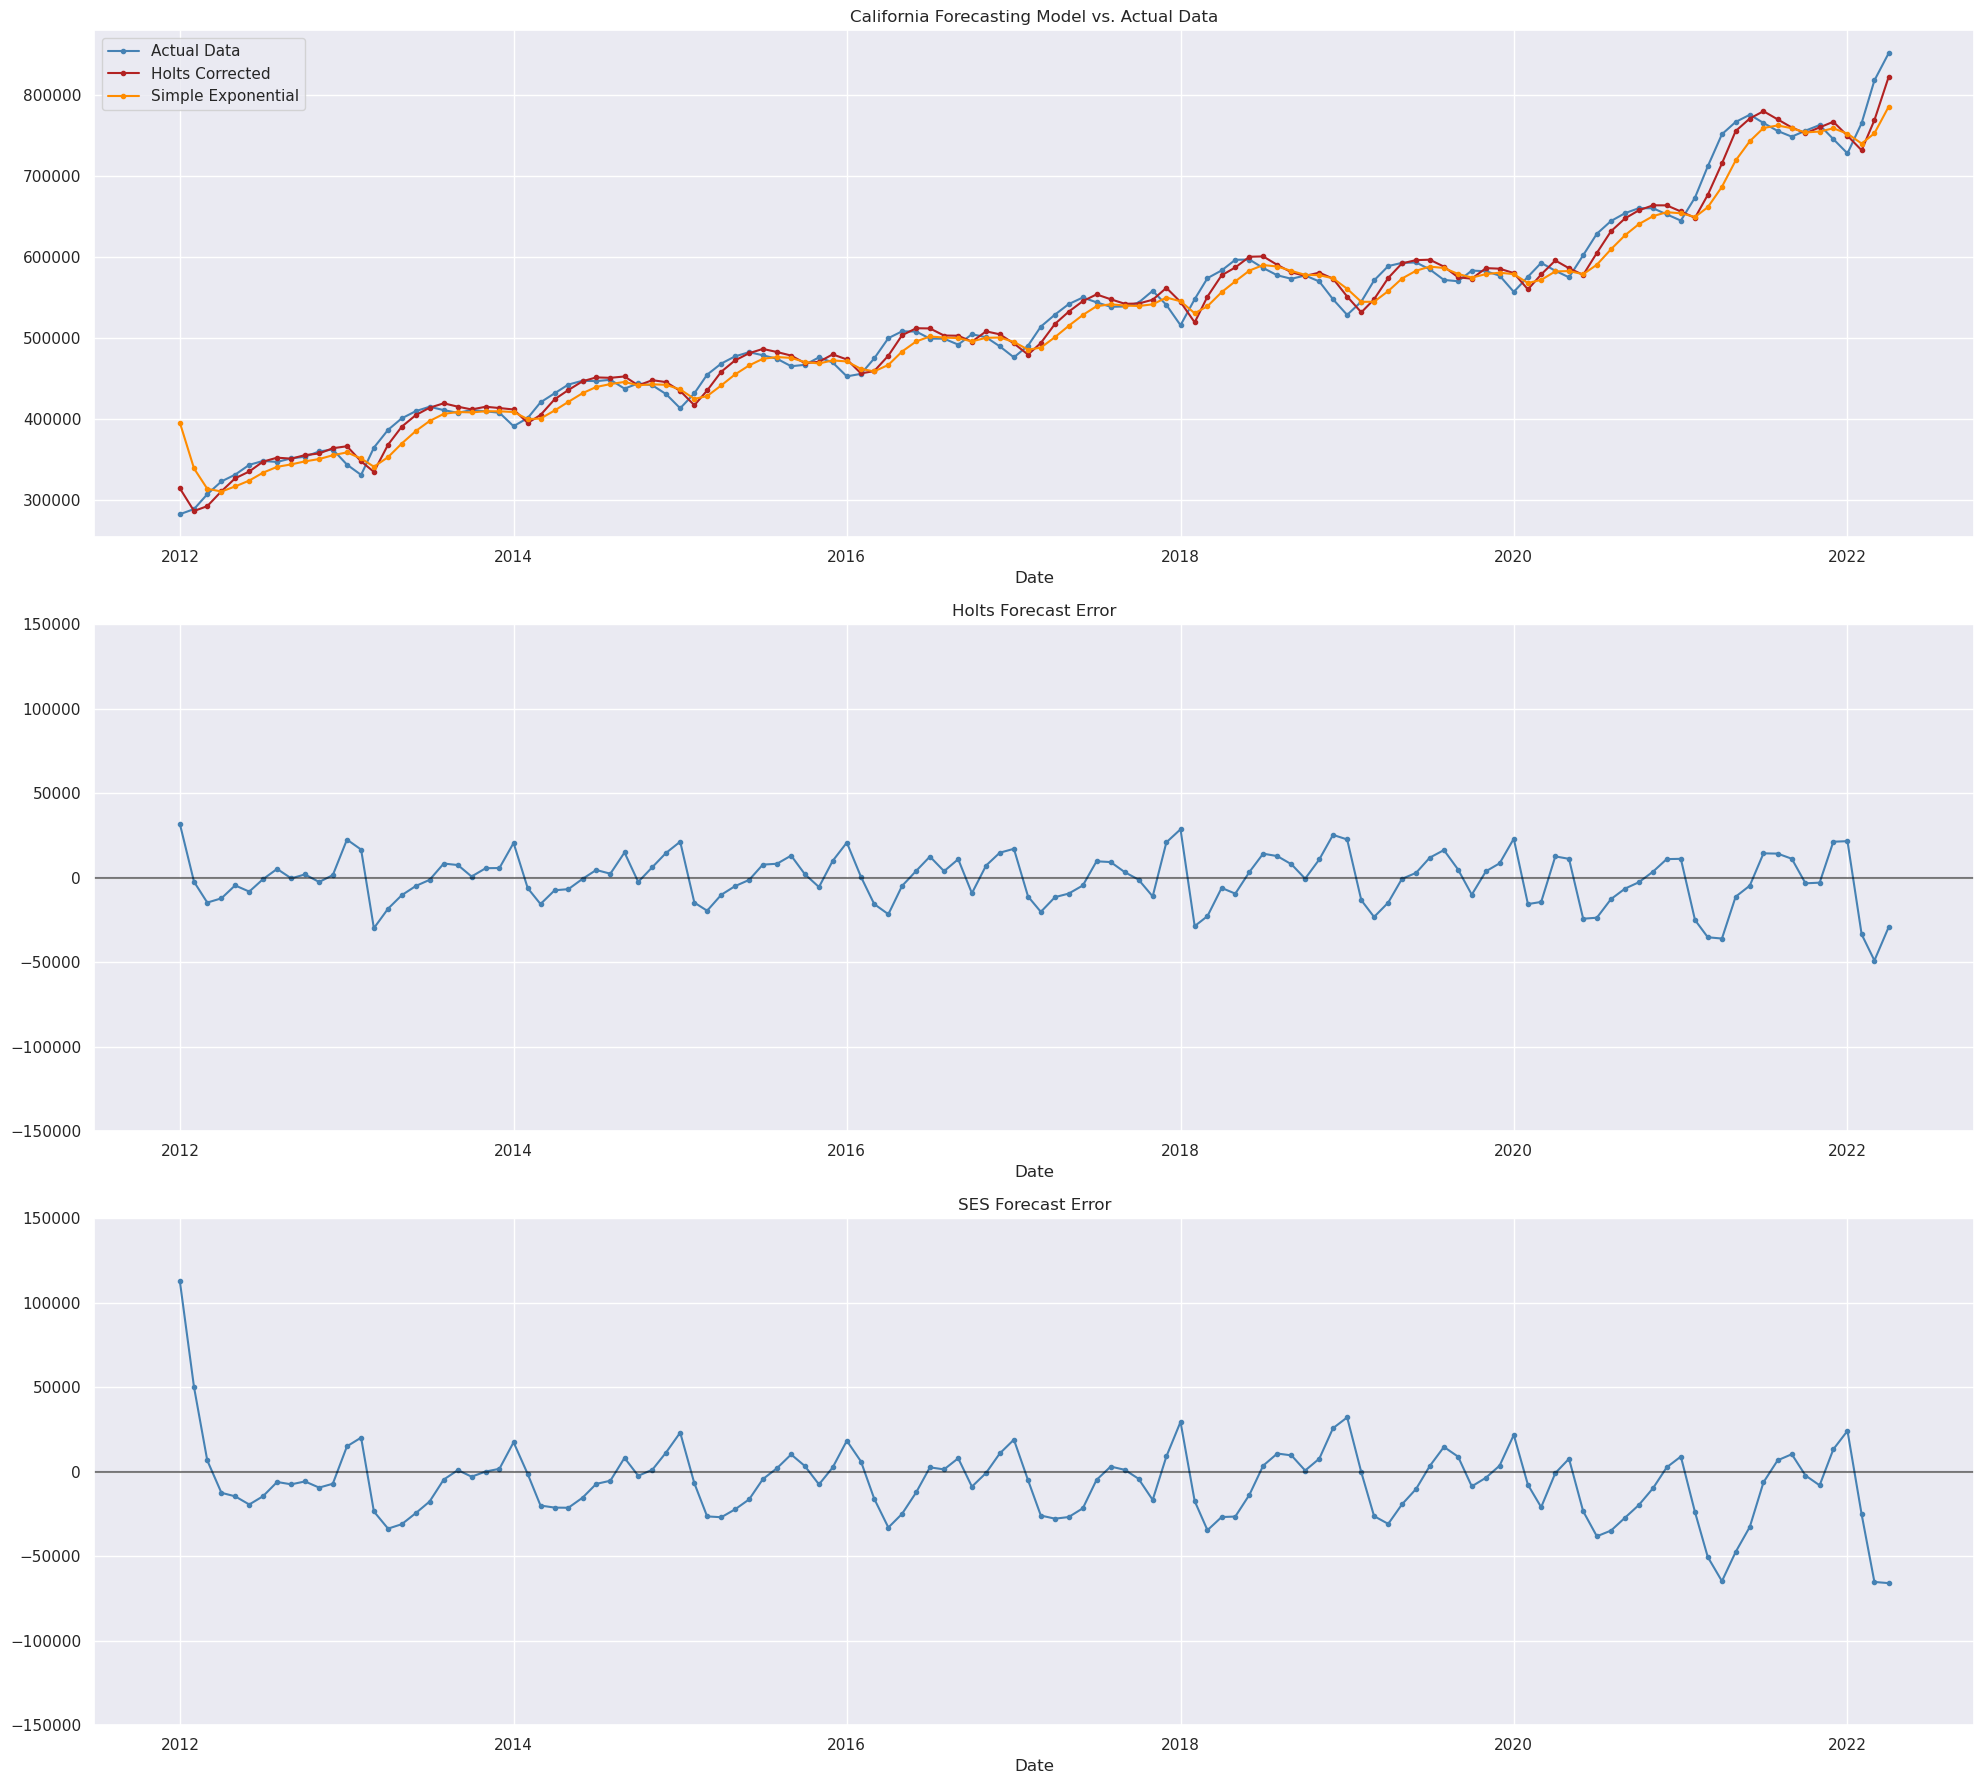

In [44]:
figure = plt.figure(figsize=(20, 18))

axes = figure.add_subplot(3, 1, 1)

axes.plot( CA[0][1].period_begin, CA[0][1].median_sale_price, color="steelblue", marker=".")
axes.plot( CA[0][1].period_begin, CA_holts, color="firebrick", marker=".")
axes.plot( CA[0][1].period_begin, CA_ses[0][3], color="darkorange", marker=".")
axes.set_xlabel( "Date")
axes.set_title("California Forecasting Model vs. Actual Data")
axes.legend(['Actual Data', 'Holts Corrected', 'Simple Exponential'])

axes = figure.add_subplot(3, 1, 2)

axes.plot( CA[0][1].period_begin, CA_error, color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_ylim(-150000, 150000)
axes.set_xlabel( "Date")
axes.set_title( "Holts Forecast Error")

axes = figure.add_subplot(3, 1, 3)

axes.plot( CA[0][1].period_begin, CA_ses[0][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_ylim(-150000, 150000)
axes.set_xlabel( "Date")
axes.set_title( "SES Forecast Error")

plt.tight_layout()
plt.show()

Visually, Holts Trend Corrected Smoothing model follows the actual data more closely than Simple Exponential Smoothing. The errors are again smaller, so trend is beneficial for our time series data. Based on the patterned shape of the time series data, we may need to consider seasonality in a more complex model. Nevertheless, let's try predicting a few future values:

In [45]:
# 124 (index 123) is the last time point in the data
time_index = [124, 125, 126, 127]

CA_holts_predict = pd.DataFrame([holts_predict(CA_levels, CA_trends, time_index)], 
                                columns = ["(holts) 2022-05-01", "(holts) 2022-06-01", "(holts) 2022-07-01", "(holts) 2022-08-01"])

CA_ses_predict = pd.DataFrame(CA_predict.iloc[0]).T # Just All Residential prediction


CA_predict_compare = pd.concat([CA_ses_predict, CA_holts_predict], axis=1)

print(tabulate(CA_predict_compare.T[1:], headers = ['date','median sale price'],  tablefmt = 'fancy_grid'))


╒════════════════════╤═════════════════════╕
│ date               │   median sale price │
╞════════════════════╪═════════════════════╡
│ 2022-04-01         │              850700 │
├────────────────────┼─────────────────────┤
│ (SES) 2022-05-01   │              817753 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-05-01 │              855161 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-06-01 │              859916 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-07-01 │              864670 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-08-01 │              869425 │
╘════════════════════╧═════════════════════╛


The prediction for 05/01/2022 is more consistent in the Holt's corrected model, since we see a slight increase from the actual median sale price from 04/01/2022. In addition, we see a stable increase in values over time when we consider the next few months. One thing to consider, however, is that although this model may be superior to SES, we know the data has a pattern that aligns with each following year (dips at the very beginning or end of the year). This could be where Holt's Trend Corrected smoothing is lacking, since it will not factor in seasonality. 

On to New York, we will perform linear regression with $y$ as median_sale_price and $x$ as time (t). 

In [46]:
describe_fit(lm( "median_sale_price ~ t", data=NY[0][1]), return_coefficient=False)

regression:  median_sale_price ~ t
n:  124
--------------------------------
intercept:  151887.56884343034
t:  2956.702124311565
--------------------------------
sigma 41339.36355129043
R^2 0.8694802027273664


Based on the results, each time point adds $\$$2,956.70 to the median sale price. We will estimate $\beta_{0}$ and $\beta_{1}$ using the first third of values (about 42 values).

In [47]:
NY_all_fit = lm( "median_sale_price ~ t", data=NY[0][1].iloc[0:42])
NY_beta = describe_fit( NY_all_fit)

regression:  median_sale_price ~ t
n:  42
--------------------------------
intercept:  203003.71660859443
t:  356.859249655622
--------------------------------
sigma 8824.44349907477
R^2 0.2014553599385389


Next, we need to determine the ideal $\alpha$ and $\gamma$, which we can do using grid search. 

In [48]:
values = [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

NY_grid, NY_alpha, NY_gamma = grid_search_holts(NY_beta[0], NY_beta[1], NY[0][1].median_sale_price, values=values)
print(f"Alpha: {NY_alpha} \
        Gamma: {NY_gamma}")

NY_grid

Alpha: 0.9         Gamma: 0.1


0.10            0.20            0.30            0.40            0.50            0.60            0.70            0.80            0.90
0.10 190837701534.92 169779208836.40 162667402499.80 169652092672.65 173620061179.66 168454202622.54 161234491425.71 160067728277.17 165787294065.71
0.20 105274280026.99 105087538571.58 107549571742.71 110261251230.68 114485434562.69 119503985799.88 125215221852.58 132504051153.19 141737951891.83
0.30  82042141023.35  84791588742.19  88916631153.20  93948158159.30  99619248016.82 105595086649.57 111151691687.09 115298094951.98 117389912183.62
0.40  70730188848.79  74212361397.17  78476750325.24  82846689118.14  86743476376.69  89666393266.24  91457700709.10  92422174239.29  93075462619.00
0.50  63759612424.65  67159062129.70  70756215113.78  73944036682.31  76440817736.98  78295178251.29  79795686446.99  81254302834.48  82865020777.17
0.60  59144214107.42  62289918620.36  65347916702.70  67965400366.20  70144477369.14  72075187154.84  73959862919.05  75909411734.00  77935712091.24
0.70  56191092862.13  59193152571.58  62043848423.97  64583099350.92  66904448337.43  69158004271.09  71443949678.14  73797394401.71  76222510670.17
0.80  54598347953.24  57647356105.45  60590356476.13  63375794603.43  66114346085.93  68924571715.33  71889449548.28  75072797550.42  78546893266.97
0.90  54245347635.45  57568797853.25  60900762829.42  64260541858.72  67778676868.58  71589792551.53  75819344189.49  80601002442.25  86091909105.98

Now that we have narrowed down the alpha and gamma values, we can perform a second grid search that increases by 0.01 around the selected alpha and gamma values above. 

In [49]:
values = [[0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99],
          [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]]

NY_grid, NY_alpha, NY_gamma = grid_search_holts(NY_beta[0], NY_beta[1],NY[0][1].median_sale_price, values=values)
print(f"Alpha: {NY_alpha} \
        Gamma: {NY_gamma}")

NY_grid

Alpha: 0.91         Gamma: 0.01


0.01           0.02           0.03           0.04           0.05           0.06           0.07           0.08           0.09           0.10           0.11           0.12  \
0.81 52020825243.63 52153696120.60 52420811484.33 52718201827.43 53018507330.15 53316495234.93 53612933834.05 53909575963.21 54207735290.38 54508061289.30 54810670645.30 55115337886.35   
0.82 51922172378.33 52060418855.79 52329861359.07 52628947240.56 52930955946.57 53230767898.88 53529118570.70 53827704817.20 54127797828.74 54430024426.36 54734495107.09 55040989426.22   
0.83 51834430483.24 51978069599.98 52249967704.66 52550904184.25 52854775176.50 53156570722.19 53456995390.67 53757692874.50 54059894156.97 54364204845.31 54670729971.98 54979254335.85   
0.84 51757528420.00 51906587148.98 52181074546.08 52484021090.64 52789918089.33 53093861801.07 53396527697.02 53699508966.85 54003998525.20 54310582115.43 54619359978.72 54930122351.57   
0.85 51691406495.97 51845921536.78 52123137210.91 52428257811.44 52736349282.91 53042610852.61 53347690597.70 53653133717.90 53960097075.86 54269147819.67 54580382027.45 54893595548.83   
0.86 51636016215.84 51796033822.41 52076122134.30 52383585438.73 52694044722.67 53002799075.17 53310470789.61 53618559452.77 53928187779.52 54239905517.17 54553805168.79 54869688357.39   
0.87 51591320073.91 51756895916.08 52040006703.06 52349986165.33 52662991620.24 52974419048.06 53284866481.71 53595790145.99 53908280408.64 54222870743.09 54539650629.69 54858427612.87   
0.88 51557291385.53 51728490443.20 52014779137.83 52327453183.37 52643188350.51 52957474669.68 53270887356.36 53584841407.54 53900396549.10 54218071045.97 54537951876.69 54859852645.77   
0.89 51533914156.10 51710810645.07 52000438412.20 52315990620.31 52634644406.44 52951981133.59 53268554568.63 53585740506.89 53904569649.77 54225546063.22 54548754717.47 54874015408.91   
0.90 51521182986.78 51703860315.48 51996994207.99 52315613511.76 52637380391.21 52957964942.20 53277900783.64 53598526435.20 53920845110.46 54245347635.45 54572117441.60 54900980644.75   
0.91 51519103015.75 51707653772.40 52004466906.23 52326347810.55 52651428047.19 52975463958.01 53298970251.71 53623250005.93 53949280408.89 54277539960.19 54608111001.60 54940826093.87   
0.92 51527689894.50 51722215864.35 52022887613.41 52348230432.01 52676830321.96 53004527492.35 53331818921.94 53659973994.45 53989945267.38 54322199786.40 54656819235.59 54993642746.24   
0.93 51546969798.66 51747582011.13 52052298222.85 52381309335.24 52713641471.14 53045216432.10 53376514594.39 53708773317.29 54042921860.10 54379416650.59 54718339132.93 55059535136.85   
0.94 51576979472.94 51783798278.84 52092751511.25 52425643640.62 52761927198.69 53097603404.62 53433137111.71 53769735251.83 54108305062.09 54449293155.96 54792781144.36 55138621687.64   
0.95 51617766310.22 51830921489.26 52144311270.54 52481303783.83 52821764834.78 53161772981.73 53501778590.97 53842959697.60 54186202741.20 54531945296.20 54880269538.56 55231035097.73   
0.96 51669388464.81 51889019363.72 52207052475.48 52548371707.00 52893243552.20 53237821923.45 53582543696.73 53928559480.23 54276736094.42 54627502825.36 54980942806.77 55336922783.94   
0.97 51731915000.00 51958170702.09 52281061487.55 52626941087.46 52976464621.92 53325859462.54 53675549956.48 54026660699.67 54380040030.35 54736109676.00 55094954117.93 55456447374.40   
0.98 51805426070.50 52038465597.22 52366436295.77 52717117605.22 53071541709.06 53426007631.06 53780928120.04 54137403124.17 54496263599.46 54857924427.38 55222471826.51 55589787257.43   
0.99 51890013140.25 52130005685.86 52463286795.53 52819019250.07 53178601210.24 53538401630.47 53898822564.36 54260940631.91 54625570474.48 54993120826.36 55363680035.63 55737137189.02   

               0.13           0.14           0.15           0.16           0.17           0.18           0.19  
0.81 55421653352.93 55729131984.05 56037280404.19 56345634478.86 56653777891.73 56961349356.62 57268043461.53  
0.82 55349109448.21 5565838531

Using the ideal alpha and gamma values, we can implement the Holts Trend corrected smoothing model as follows, and plot the results:

In [50]:
NY_holts, NY_levels, NY_trends = holts_forecast(NY_beta[0], NY_beta[1], NY_alpha, NY_gamma, NY[0][1].median_sale_price)

NY_error = NY_holts - NY[0][1].median_sale_price

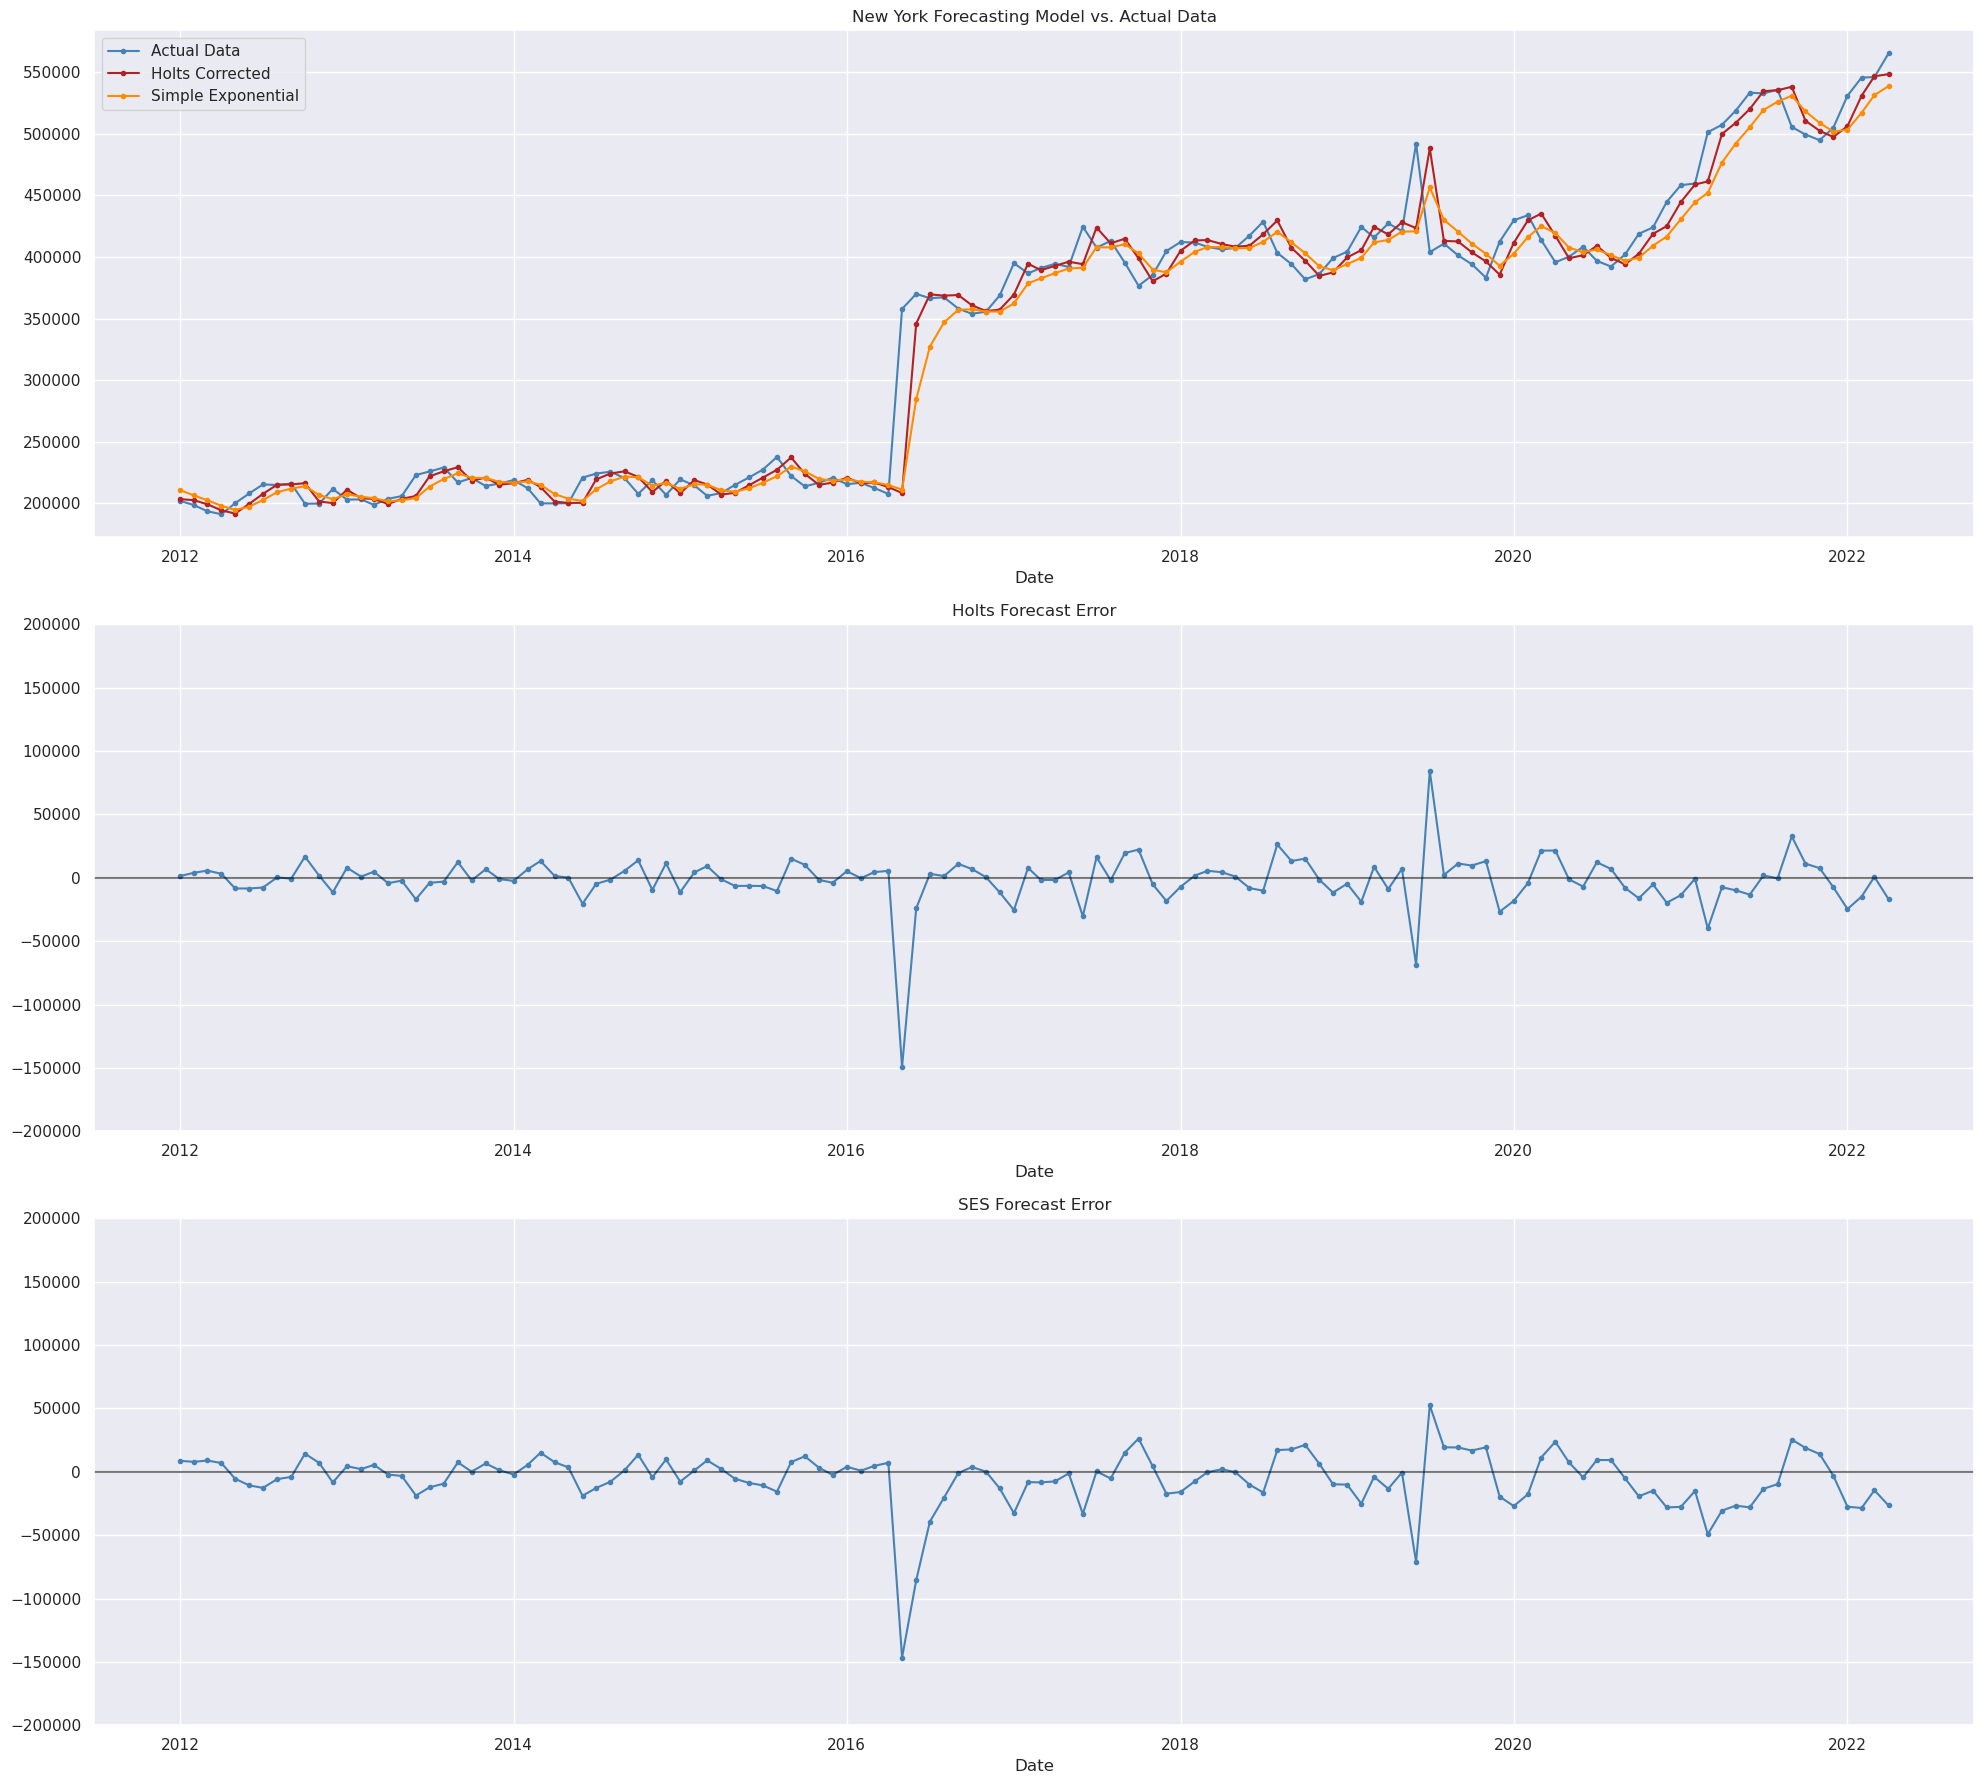

In [51]:
figure = plt.figure(figsize=(20, 18))

axes = figure.add_subplot(3, 1, 1)

axes.plot( NY[0][1].period_begin, NY[0][1].median_sale_price, color="steelblue", marker=".")
axes.plot( NY[0][1].period_begin, NY_holts, color="firebrick", marker=".")
axes.plot( NY[0][1].period_begin, NY_ses[0][3], color="darkorange", marker=".")
axes.set_xlabel( "Date")
axes.set_title("New York Forecasting Model vs. Actual Data")
axes.legend(['Actual Data', 'Holts Corrected', 'Simple Exponential'])

axes = figure.add_subplot(3, 1, 2)

axes.plot( NY[0][1].period_begin, NY_error, color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_ylim(-200000, 200000)
axes.set_xlabel( "Date")
axes.set_title( "Holts Forecast Error")

axes = figure.add_subplot(3, 1, 3)

axes.plot( NY[0][1].period_begin, NY_ses[0][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_ylim(-200000, 200000)
axes.set_xlabel( "Date")
axes.set_title( "SES Forecast Error")

plt.tight_layout()
plt.show()

Visually, Holts Trend Corrected Smoothing model follows the actual data more closely than Simple Exponential Smoothing, as seen in the last two states. The errors are smaller, although to a lesser degree. Still, factoring in trend is beneficial for our time series data in this case. Seasonality may not be a major issue for New York's time series data, since we do not see a consistent pattern in the data or the errors for either forecast model. Let's try predicting a few future values:

In [52]:
# 124 (index 123) is the last time point in the data
time_index = [124, 125, 126, 127]

NY_holts_predict = pd.DataFrame([holts_predict(NY_levels, NY_trends, time_index)], 
                                columns = ["(holts) 2022-05-01", "(holts) 2022-06-01", "(holts) 2022-07-01", "(holts) 2022-08-01"])

NY_ses_predict = pd.DataFrame(NY_predict.iloc[0]).T # Just All Residential prediction


NY_predict_compare = pd.concat([NY_ses_predict, NY_holts_predict], axis=1)

print(tabulate(NY_predict_compare.T[1:], headers = ['date','median sale price'],  tablefmt = 'fancy_grid'))

╒════════════════════╤═════════════════════╕
│ date               │   median sale price │
╞════════════════════╪═════════════════════╡
│ 2022-04-01         │              565300 │
├────────────────────┼─────────────────────┤
│ (SES) 2022-05-01   │              552003 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-05-01 │              566299 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-06-01 │              568816 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-07-01 │              571333 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-08-01 │              573850 │
╘════════════════════╧═════════════════════╛


Similar to California, the Holt's Trend Corrected model appears superior to Simple exponential smoothing. The SES model predicted a value lower for 05/01/2022 than the following month, which would not be accurate after a longer period of time where we expect an upward trend in prices. The holt's model shows a steady increase over several months, instead. Although price drops with market conditions or seasonal differences are possible, we expect to see an upward trend overall and SES would not factor in trend like the holt's model. 

For Texas, we will perform linear regression with $y$ as median_sale_price and $x$ as time (t). 

In [53]:
describe_fit(lm( "median_sale_price ~ t", data=TX[0][1]), return_coefficient=False)

regression:  median_sale_price ~ t
n:  124
--------------------------------
intercept:  150182.45476003145
t:  1323.7904012588508
--------------------------------
sigma 15373.06644345857
R^2 0.906159273870114


Based on the results, each time point adds $\$$1,323.79 to the median sale price. We will estimate $\beta_{0}$ and $\beta_{1}$ using the first third of values (about 42 values).

In [54]:
TX_all_fit = lm( "median_sale_price ~ t", data=TX[0][1].iloc[0:42])
TX_beta = describe_fit( TX_all_fit)

regression:  median_sale_price ~ t
n:  42
--------------------------------
intercept:  154122.0673635307
t:  1328.9846851956906
--------------------------------
sigma 7781.48465376595
R^2 0.8181691007894595


Next, we need to determine the ideal $\alpha$ and $\gamma$, which we can do using grid search. 

In [55]:
values = [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

TX_grid, TX_alpha, TX_gamma = grid_search_holts(TX_beta[0], TX_beta[1], TX[0][1].median_sale_price, values=values)
print(f"Alpha: {TX_alpha} \
        Gamma: {TX_gamma}")

TX_grid

Alpha: 0.9         Gamma: 0.1


0.10           0.20           0.30           0.40           0.50           0.60           0.70           0.80           0.90
0.10 14704225228.78 11971735344.59 11348677849.42 11594043357.52 12210334584.50 13002968281.98 13918451495.43 15008255947.43 16331759475.32
0.20 10632906180.94 10900237440.54 12042126691.80 13613357222.43 15584035464.21 18005464962.37 20959487545.13 24483801449.90 28427896880.79
0.30  9721486602.97 10746281821.42 12317006994.67 14188676700.18 16205442826.71 18074872061.64 19355486587.61 19675675206.92 19017912170.34
0.40  8945754382.16 10000230331.03 11267017595.84 12419857208.44 13174235286.44 13342375096.78 12971941262.24 12302686562.74 11588518351.94
0.50  8160986826.65  8987263803.73  9769933421.27 10250672572.82 10342647754.67 10132688515.14  9798087488.51  9488340315.29  9279191781.36
0.60  7480980884.15  8082474728.88  8545792356.32  8745414388.32  8726067922.21  8610599643.90  8507338913.25  8470737686.38  8510843243.25
0.70  6967189757.59  7424921653.71  7744092971.33  7886555651.76  7927625202.32  7956453535.47  8027046140.81  8156862226.19  8344057581.15
0.80  6626748836.01  7016867585.11  7299930294.61  7478821732.32  7622603479.72  7790384191.82  8012046823.20  8297432291.70  8649298998.34
0.90  6447343240.27  6827133198.64  7137799060.64  7399138793.63  7668742903.63  7989255408.10  8383028615.44  8861583038.21  9433743771.36

Now that we have narrowed down the alpha and gamma values, we can perform a second grid search that increases by 0.01 around the selected alpha and gamma values above. 

In [56]:
values = [[0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99],
          [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]]

TX_grid, TX_alpha, TX_gamma = grid_search_holts(TX_beta[0], TX_beta[1], TX[0][1].median_sale_price, values=values)
print(f"Alpha: {TX_alpha} \
        Gamma: {TX_gamma}")

TX_grid

Alpha: 0.99         Gamma: 0.01


0.01          0.02          0.03          0.04          0.05          0.06          0.07          0.08          0.09          0.10          0.11          0.12          0.13  \
0.81 6385458301.73 6392408769.39 6401481590.42 6416029175.57 6436587890.12 6462565993.65 6493012197.45 6526941433.96 6563459140.53 6601797576.35 6641315822.03 6681486454.61 6721878842.71   
0.82 6361207155.34 6368593689.30 6378089881.83 6392960923.75 6413718597.47 6439774865.92 6470193344.28 6504007144.20 6540339728.01 6578439909.96 6617681496.23 6657550006.68 6697626166.76   
0.83 6338314364.12 6346147841.38 6356078436.41 6371287419.16 6392263267.24 6418421915.35 6448841692.63 6482573517.75 6518758453.99 6556661451.53 6595670648.82 6635284145.47 6675093688.07   
0.84 6316764889.49 6325056796.37 6335433496.71 6350995475.88 6372209108.42 6398494539.96 6428944617.44 6462627698.79 6498702032.64 6536448295.37 6575268573.68 6614673192.58 6654264592.40   
0.85 6296544447.41 6305306838.26 6316141970.17 6332072527.26 6353543911.74 6379980692.49 6410490033.16 6444157368.00 6480157724.00 6517787103.67 6556461167.39 6595702120.17 6635122777.16   
0.86 6277639527.95 6286884990.24 6298191462.44 6314506667.00 6336256098.37 6362868936.50 6393466456.75 6427150812.02 6463113409.48 6500665187.44 6539235014.96 6578356640.84 6617652944.94   
0.87 6260037414.09 6269779039.55 6281570309.12 6298286688.01 6320334765.71 6347148498.82 6377863066.38 6411596987.90 6447557661.59 6485070581.03 6523577468.67 6562623290.13 6601840688.82   
0.88 6243726200.35 6253977561.63 6266267606.24 6283402119.30 6305769730.68 6332809318.86 6363669756.43 6397485583.44 6433479809.04 6470992111.46 6509476721.02 6548489502.56 6587672570.98   
0.89 6228694811.23 6239469943.73 6252273239.65 6269843261.47 6292551571.07 6319842095.57 6350877189.59 6384807073.96 6420869997.82 6458419463.32 6496921872.94 6535943682.58 6575136195.69   
0.90 6214933019.80 6226246408.34 6239577913.98 6257601221.19 6280671665.44 6308238332.43 6339476846.66 6373552776.46 6409719249.22 6447343240.27 6485902998.23 6524975271.42 6564220278.07   
0.91 6202431466.67 6214298036.75 6228173181.24 6246667945.02 6270122231.99 6297990381.11 6329461074.61 6363714901.70 6400019515.63 6437755023.92 6476411205.22 6515574810.99 6554914709.71   
0.92 6191181679.63 6203616792.92 6218051469.59 6237036253.08 6260896366.97 6289091484.36 6320823133.59 6355286605.07 6391763734.65 6429647431.07 6468438696.48 6507734005.74 6547210622.13   
0.93 6181176094.11 6194195548.17 6209206112.51 6228699872.88 6252988083.03 6281535818.61 6313557243.49 6348262036.61 6384945882.52 6423014169.86 6461978827.57 6501445783.41 6541100449.26   
0.94 6172408074.86 6186028106.71 6201631378.79 6221653473.74 6246392347.97 6275318536.74 6307658630.50 6342636391.17 6379561027.30 6417850095.91 6457026165.53 6496704355.72 6536577989.77   
0.95 6164871938.94 6179109232.58 6195322503.68 6215892702.23 6241105124.29 6270435811.67 6303123574.37 6338405959.04 6375605382.69 6414151268.86 6453576548.03 6493505279.68 6533638470.29   
0.96 6158562980.43 6173434678.07 6190275721.45 6211414218.96 6237123410.10 6266884881.10 6299949456.84 6335568177.74 6373076362.97 6411915010.28 6451627143.89 6491845520.47 6532278610.42   
0.97 6153477497.02 6169001214.11 6186488299.86 6208215737.13 6234445281.74 6264664094.00 6298134811.79 6334121685.73 6371972639.92 6411139963.56 6451176515.73 6491723516.68 6532496690.31   
0.98 6149612818.88 6165806662.76 6183958576.73 6206296063.29 6233069938.50 6263772959.30 6297679377.62 6334066378.27 6372294202.13 6411826156.44 6452224685.61 6493139248.82 6534292621.83   
0.99 6146967339.91 6163849932.34 6182685999.11 6205655140.57 6232997750.06 6264212197.22 6298584152.54 6335403466.45 6374042417.50 6413975066.98 6454773204.23 6496094311.70 6537668024.09   

              0.14          0.15          0.16          0.17          0.18          0.19  
0.81 6762143113.74 6801996214.56 6841210346.32 6879603594.50 6917032421.94 6953385673.39  
0.82 6737570105.21 6777107629.3

Using the ideal alpha and gamma values, we can implement the Holts Trend corrected smoothing model as follows, and plot the results:

In [57]:
TX_holts, TX_levels, TX_trends = holts_forecast(TX_beta[0], TX_beta[1], TX_alpha, TX_gamma, TX[0][1].median_sale_price)

TX_error = TX_holts - TX[0][1].median_sale_price

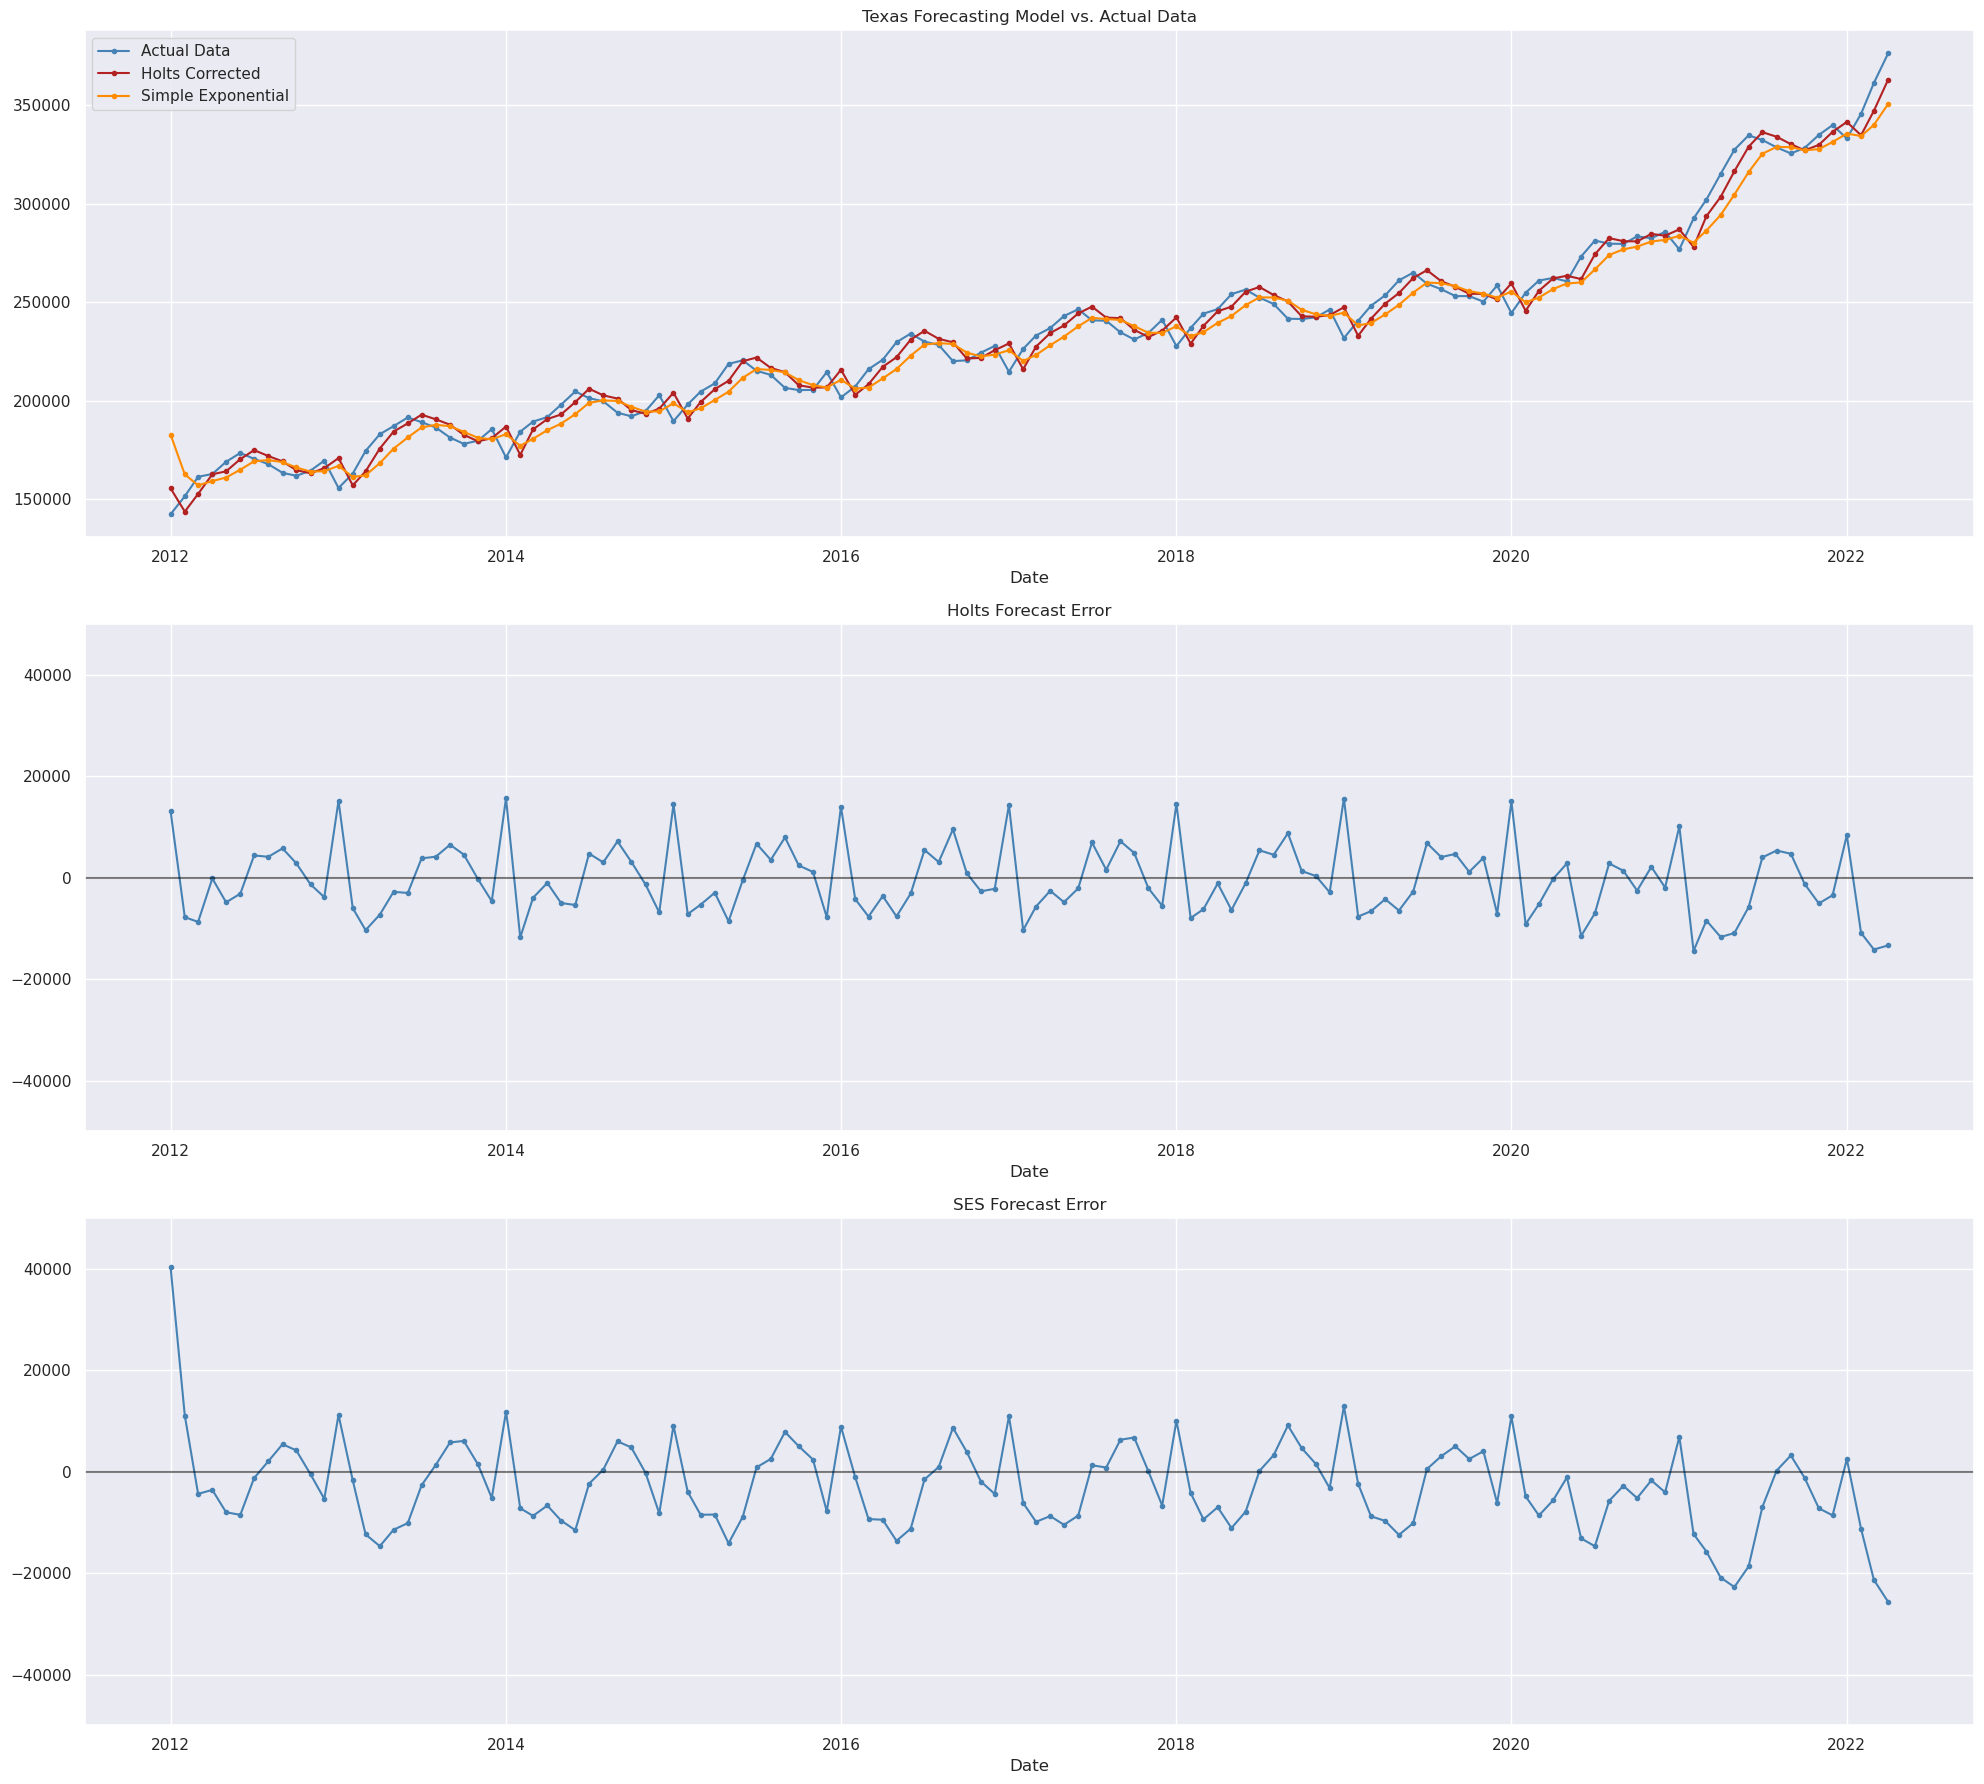

In [58]:
figure = plt.figure(figsize=(20, 18))

axes = figure.add_subplot(3, 1, 1)

axes.plot( TX[0][1].period_begin, TX[0][1].median_sale_price, color="steelblue", marker=".")
axes.plot( TX[0][1].period_begin, TX_holts, color="firebrick", marker=".")
axes.plot( TX[0][1].period_begin, TX_ses[0][3], color="darkorange", marker=".")
axes.set_xlabel( "Date")
axes.set_title("Texas Forecasting Model vs. Actual Data")
axes.legend(['Actual Data', 'Holts Corrected', 'Simple Exponential'])

axes = figure.add_subplot(3, 1, 2)

axes.plot( TX[0][1].period_begin, TX_error, color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_ylim(-50000, 50000)
axes.set_xlabel( "Date")
axes.set_title( "Holts Forecast Error")

axes = figure.add_subplot(3, 1, 3)

axes.plot( TX[0][1].period_begin, TX_ses[0][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_ylim(-50000, 50000)
axes.set_xlabel( "Date")
axes.set_title( "SES Forecast Error")

plt.tight_layout()
plt.show()

Like previous states, the Holt's forecast error appears smaller, at least visually. The biggest difference is in the initial and more recent time points where SES has a much larger error compared to Holt's trend corrected. Another point worth noting, Texas may benefit from a model that implements some seasonality calculation, since we see a consistent decrease in median sale price at the early months/end months of each year. For now, let's formulate predictions using our current model:

In [59]:
# 124 (index 123) is the last time point in the data
time_index = [124, 125, 126, 127]

TX_holts_predict = pd.DataFrame([holts_predict(TX_levels, TX_trends, time_index)], 
                                columns = ["(holts) 2022-05-01", "(holts) 2022-06-01", "(holts) 2022-07-01", "(holts) 2022-08-01"])

TX_ses_predict = pd.DataFrame(TX_predict.iloc[0]).T # Just All Residential prediction


TX_predict_compare = pd.concat([TX_ses_predict, TX_holts_predict], axis=1)

print(tabulate(TX_predict_compare.T[1:], headers = ['date','median sale price'], tablefmt = 'fancy_grid'))


╒════════════════════╤═════════════════════╕
│ date               │   median sale price │
╞════════════════════╪═════════════════════╡
│ 2022-04-01         │              376200 │
├────────────────────┼─────────────────────┤
│ (SES) 2022-05-01   │              363369 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-05-01 │              378001 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-06-01 │              379935 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-07-01 │              381869 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-08-01 │              383803 │
╘════════════════════╧═════════════════════╛


Once again, the holt's model appears superior to the SES model since the predicted sale prices show a steady increase in the holt's model while the SES predicted value is lower than the previous month. For predictions that span 12-24 months in the future, we expect a higher median sale price but SES will always predict a lower value without more recent data. 

Continuing with Florida, we will perform linear regression with $y$ as median_sale_price and $x$ as time (t). 

In [60]:
describe_fit(lm( "median_sale_price ~ t", data=FL[0][1]), return_coefficient=False)

regression:  median_sale_price ~ t
n:  124
--------------------------------
intercept:  119012.1557828481
t:  1725.921636506688
--------------------------------
sigma 15610.19997879603
R^2 0.9408955130664376


Based on the results, each time point adds $\$$1,725.92 to the median sale price. We will estimate $\beta_{0}$ and $\beta_{1}$ using the first third of values (about 42 values).

In [61]:
FL_all_fit = lm( "median_sale_price ~ t", data=FL[0][1].iloc[0:42])
FL_beta = describe_fit( FL_all_fit)

regression:  median_sale_price ~ t
n:  42
--------------------------------
intercept:  124884.78513356553
t:  1683.2104367555314
--------------------------------
sigma 6098.394853820269
R^2 0.9215799853890908


Next, we need to determine the ideal $\alpha$ and $\gamma$, which we can do using grid search. 

In [62]:
values = [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

FL_grid, FL_alpha, FL_gamma = grid_search_holts(FL_beta[0], FL_beta[1], FL[0][1].median_sale_price, values=values)
print(f"Alpha: {FL_alpha} \
        Gamma: {FL_gamma}")

FL_grid

Alpha: 0.9         Gamma: 0.1


0.10          0.20          0.30          0.40          0.50          0.60          0.70           0.80           0.90
0.10 10924083331.11 7347838302.92 6066777454.24 5799043725.09 5875341248.73 6128371816.26 6522766405.62  7026902300.62  7640201801.66
0.20  5958699344.40 5341834151.66 5619274290.15 6191033058.28 6931904392.94 7815692817.62 8871570835.68 10144288944.84 11610952728.61
0.30  4960949791.08 5050419647.19 5585499485.38 6270535568.53 7023005054.19 7749513518.24 8297274600.51  8519861706.38  8387169836.90
0.40  4432693345.58 4672611095.03 5128670495.47 5577772942.53 5907241767.24 6042592840.72 5989352911.58  5826640430.14  5646419289.34
0.50  4014841611.65 4237301144.34 4539181427.58 4760625705.34 4858021692.38 4854392057.11 4808831903.42  4773984139.84  4776860936.20
0.60  3679682695.82 3857530942.51 4056019752.90 4181154508.95 4237806858.69 4264202839.65 4296110523.21  4351064536.72  4430640297.32
0.70  3425664793.09 3573528212.84 3725474883.17 3829655555.16 3903469198.91 3973932114.28 4057341675.88  4157712235.20  4272701747.61
0.80  3244618749.92 3381194632.61 3521278955.83 3634996872.92 3738867202.81 3849956782.87 3976694428.22  4121558803.97  4285604467.23
0.90  3125931102.39 3266036207.76 3414245916.09 3552109336.01 3693395899.92 3850301241.90 4029552783.39  4235102480.34  4470496202.15

Now that we have narrowed down the alpha and gamma values, we can perform a second grid search that increases by 0.01 around the selected alpha and gamma values above. 

In [63]:
values = [[0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99],
          [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]]

FL_grid, FL_alpha, FL_gamma = grid_search_holts(FL_beta[0], FL_beta[1], FL[0][1].median_sale_price, values=values)
print(f"Alpha: {FL_alpha} \
        Gamma: {FL_gamma}")

FL_grid

Alpha: 0.99         Gamma: 0.06


0.01          0.02          0.03          0.04          0.05          0.06          0.07          0.08          0.09          0.10          0.11          0.12          0.13  \
0.81 3358090079.57 3317361496.33 3281867165.12 3254698793.71 3235950735.24 3224637150.32 3219509645.44 3219374561.37 3223196177.81 3230113596.65 3239425966.67 3250568592.93 3263088752.92   
0.82 3338802561.28 3299161862.13 3264695817.08 3238408215.00 3220375512.94 3209622880.49 3204922689.94 3205103573.44 3209150430.57 3216220316.90 3225627585.43 3236820255.26 3249356185.49   
0.83 3320211765.04 3281634355.93 3248172421.39 3222745307.61 3205412685.83 3195210757.26 3190932243.35 3191427514.46 3195701531.85 3202928792.78 3212438403.96 3223690709.21 3236253815.04   
0.84 3302300632.40 3264763187.47 3232282516.03 3207696821.91 3191050030.48 3181389379.73 3177527529.98 3178336052.47 3182839430.29 3190229108.29 3199848512.68 3211169937.21 3223771414.08   
0.85 3285052806.76 3248533196.48 3217012189.41 3193249982.25 3177275728.96 3168147693.80 3164698072.46 3165819115.07 3170554304.45 3178111556.26 3187848197.72 3199248111.54 3211898946.13   
0.86 3268452597.97 3232929822.05 3202348055.37 3179392467.52 3164078354.72 3155474982.97 3152433686.73 3153866888.17 3158836564.86 3166566643.10 3176427947.78 3187915603.01 3200626575.58   
0.87 3252484948.98 3217939073.65 3188277229.28 3166112392.52 3151446858.80 3143360858.85 3140724476.53 3142469813.82 3147676854.62 3155585091.75 3165578458.96 3177162987.06 3189944674.70   
0.88 3237135404.44 3203547503.77 3174787305.43 3153398289.96 3139370556.24 3131795251.62 3129560827.22 3131618586.93 3137066048.61 3145157842.84 3155290637.46 3166981047.66 3179843828.28   
0.89 3222390081.02 3189742182.02 3161866335.42 3141239093.24 3127839112.89 3120768400.31 3118933399.21 3121304151.42 3126995251.77 3135276054.74 3145555600.92 3157360779.47 3170314836.18   
0.90 3208235639.58 3176510670.74 3149502807.70 3129624119.92 3116842532.51 3110270843.21 3108833121.17 3111517695.67 3117455796.48 3125931102.39 3136364678.34 3148293388.47 3161348714.34   
0.91 3194659258.92 3163841001.92 3137685628.27 3118543056.00 3106371144.38 3100293408.44 3099251183.08 3102250647.75 3108439239.47 3117114575.49 3127709409.15 3139770291.58 3152936694.53   
0.92 3181648611.11 3151721655.57 3126404102.33 3107985940.97 3096415591.43 3090827204.70 3090179029.30 3093494670.30 3099937358.19 3108818276.03 3119581541.53 3131783115.39 3145070223.21   
0.93 3169191838.43 3140141539.36 3115647917.10 3097943153.68 3086966818.95 3081863612.49 3081608351.83 3085241655.53 3091942147.12 3101034215.55 3111973030.32 3124323694.39 3137740959.78   
0.94 3157277531.75 3129089969.61 3105407125.75 3088405399.12 3078016063.90 3073394275.66 3073531083.79 3077483720.25 3084445814.04 3093754612.28 3104876034.75 3117384069.03 3130940774.64   
0.95 3145894710.43 3118556653.63 3095672132.42 3079363696.12 3069554845.06 3065411093.64 3065939393.39 3070213201.21 3077440776.44 3086971888.43 3098282916.22 3110956483.71 3124661747.15   
0.96 3135032803.65 3108531673.33 3086433678.39 3070809365.96 3061574953.86 3057906214.25 3058825678.36 3063422650.90 3070919658.39 3080678667.69 3092186236.30 3105033385.05 3118896163.94   
0.97 3124681633.25 3099005470.14 3077682829.42 3062734022.05 3054068446.21 3050872027.29 3052182561.11 3057104833.93 3064875287.82 3074867773.34 3086578755.31 3099607420.67 3113636517.72   
0.98 3114831397.90 3089968831.32 3069410964.30 3055129560.70 3047027635.19 3044301159.02 3046002884.57 3051252724.05 3059300694.55 3069532226.90 3081453431.45 3094671438.68 3108875506.82   
0.99 3105472658.85 3081412877.58 3061609764.63 3047988152.94 3040445084.81 3038186467.52 3040279709.03 3045859502.16 3054189109.14 3064665247.71 3076803420.93 3090218488.03 3104606035.75   

              0.14          0.15          0.16          0.17          0.18          0.19  
0.81 3276624301.22 3290885805.93 3305642058.51 3320708498.65 3335938041.79 3351213836.98  
0.82 3262882036.10 3277115721.2

Using the ideal alpha and gamma values, we can implement the Holts Trend corrected smoothing model as follows, and plot the results:

In [64]:
FL_holts, FL_levels, FL_trends = holts_forecast(FL_beta[0], FL_beta[1], FL_alpha, FL_gamma, FL[0][1].median_sale_price)

FL_error = FL_holts - FL[0][1].median_sale_price

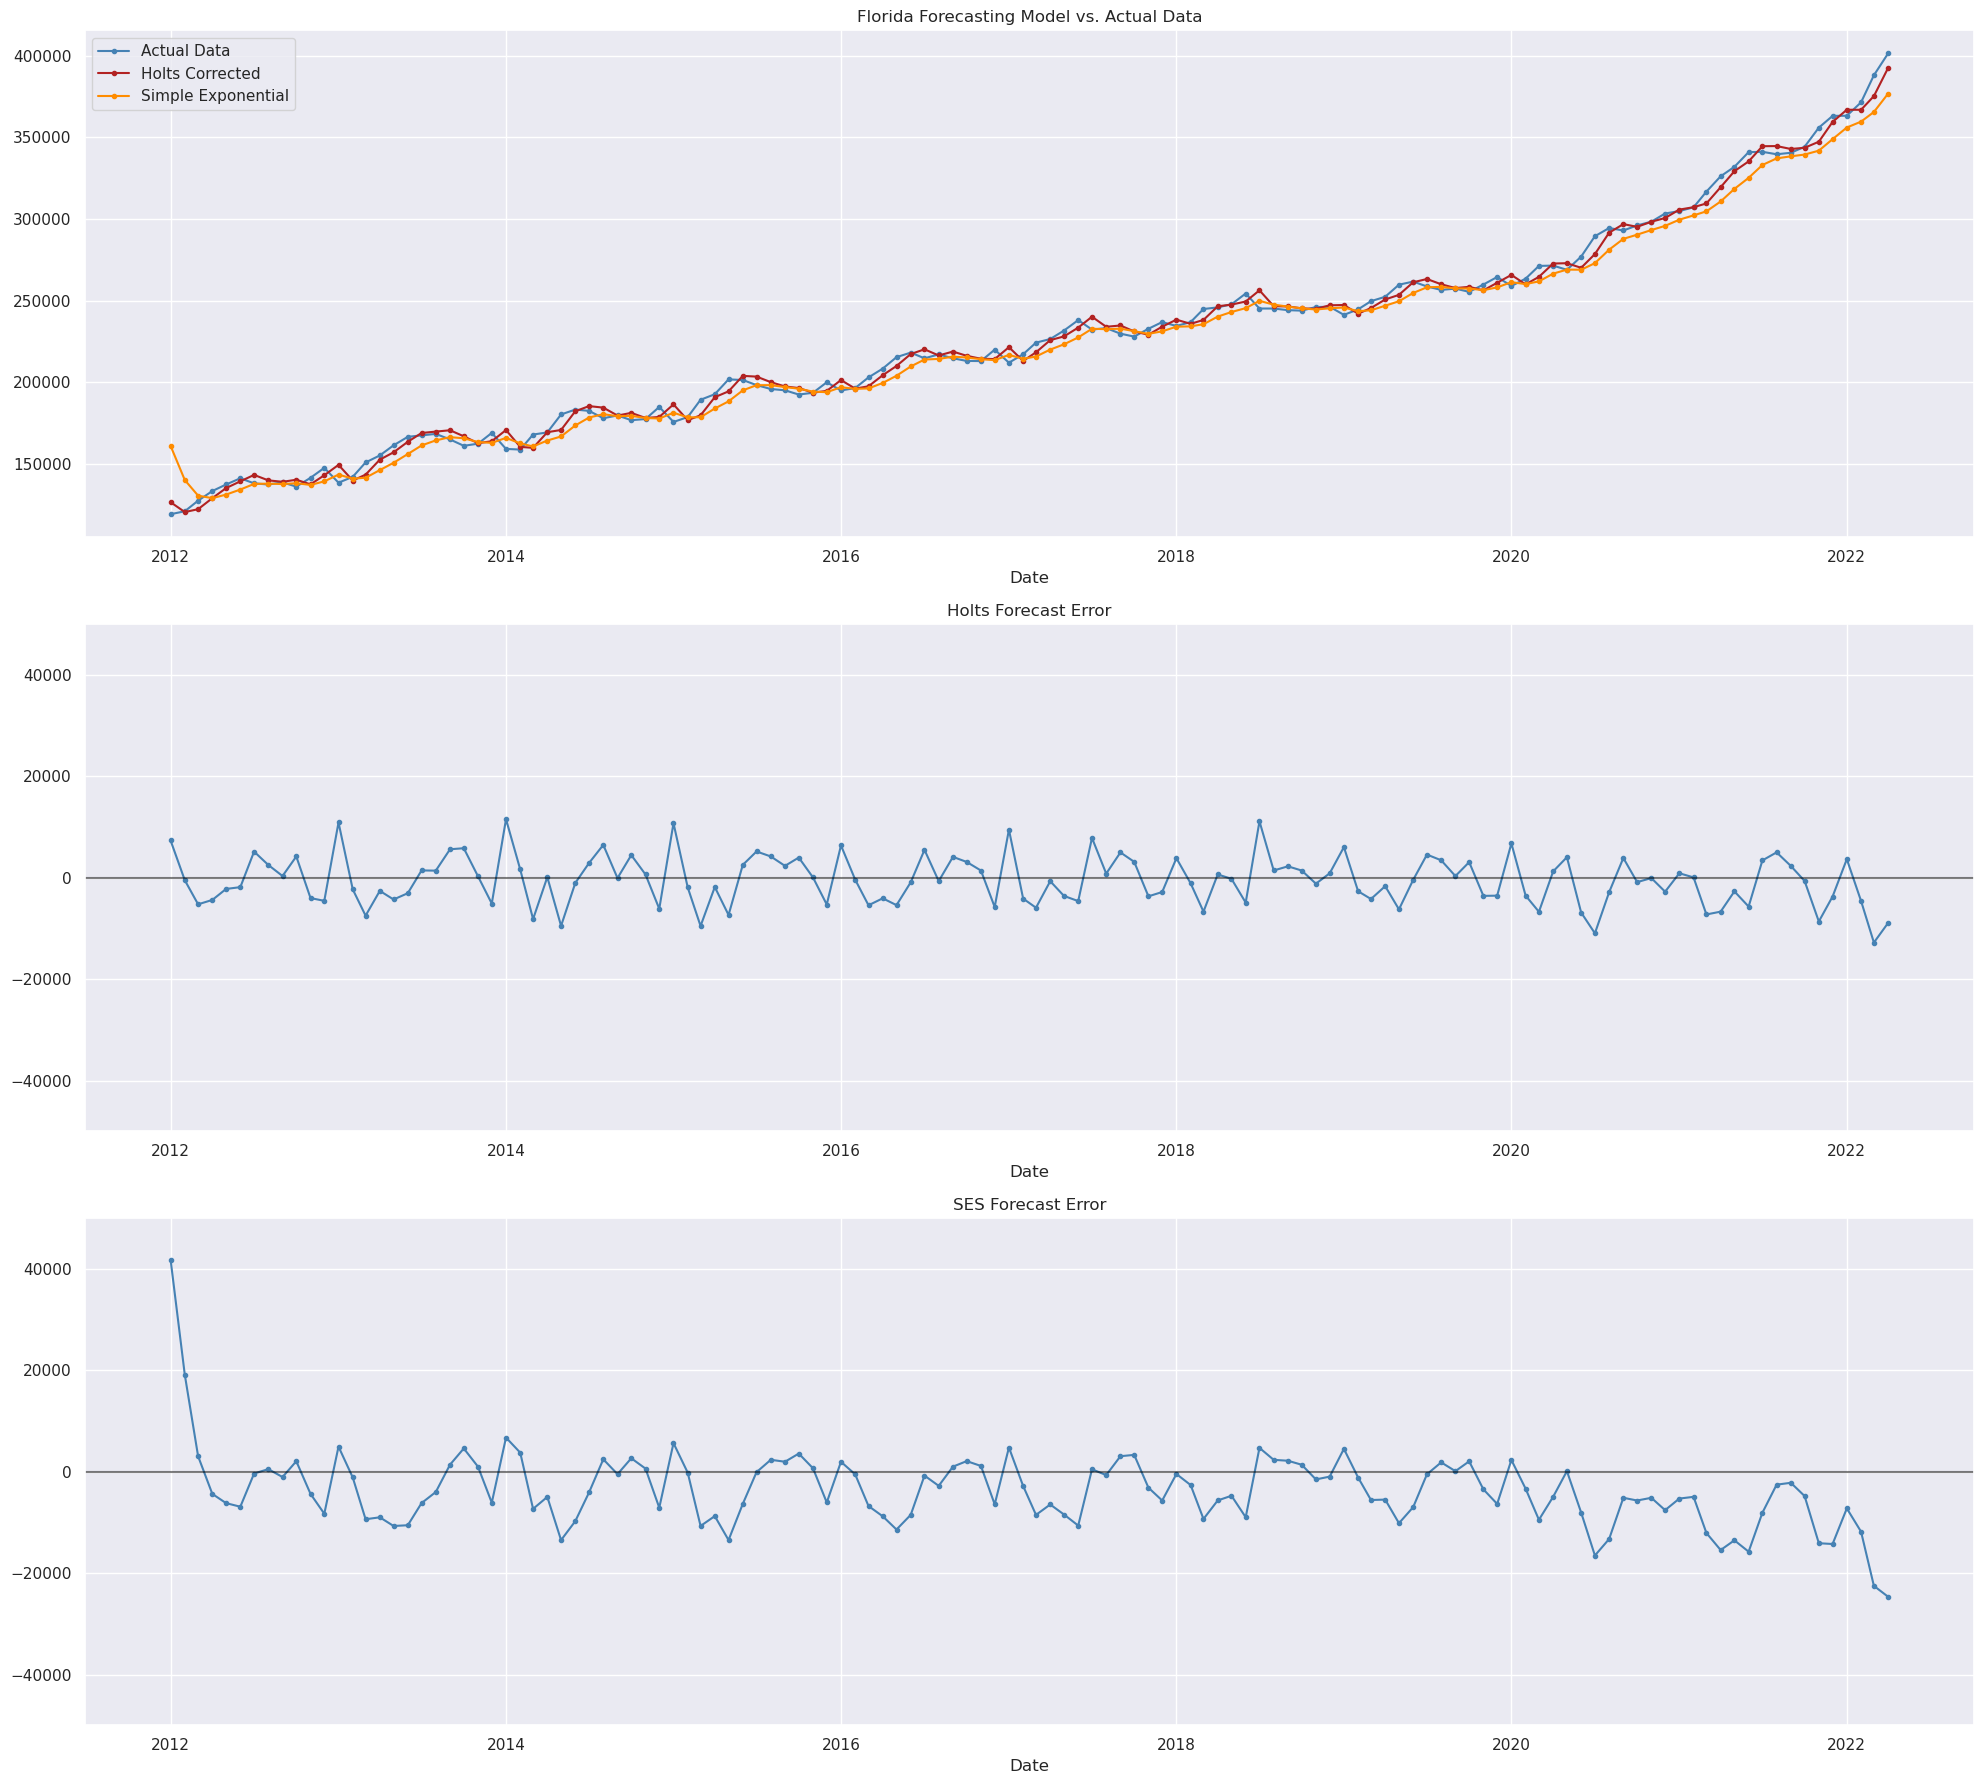

In [65]:
figure = plt.figure(figsize=(20, 18))

axes = figure.add_subplot(3, 1, 1)

axes.plot( FL[0][1].period_begin, FL[0][1].median_sale_price, color="steelblue", marker=".")
axes.plot( FL[0][1].period_begin, FL_holts, color="firebrick", marker=".")
axes.plot( FL[0][1].period_begin, FL_ses[0][3], color="darkorange", marker=".")
axes.set_xlabel( "Date")
axes.set_title("Florida Forecasting Model vs. Actual Data")
axes.legend(['Actual Data', 'Holts Corrected', 'Simple Exponential'])

axes = figure.add_subplot(3, 1, 2)

axes.plot( FL[0][1].period_begin, FL_error, color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_ylim(-50000, 50000)
axes.set_xlabel( "Date")
axes.set_title( "Holts Forecast Error")

axes = figure.add_subplot(3, 1, 3)

axes.plot( FL[0][1].period_begin, FL_ses[0][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_ylim(-50000, 50000)
axes.set_xlabel( "Date")
axes.set_title( "SES Forecast Error")

plt.tight_layout()
plt.show()

Again, the Holt's forecast error appears smaller, visually. The biggest difference is in the initial and more recent time points where SES has a much larger error compared to Holt's trend corrected. Like we noted with Texas, Florida may benefit from a model that implements some seasonality calculation, since we see a consistent decrease in median sale price at the early months/end months of each year, although it's less dramatic for Florida. Let's formulate predictions using our current forecast models:

In [66]:
# 124 (index 123) is the last time point in the data
time_index = [124, 125, 126, 127]

FL_holts_predict = pd.DataFrame([holts_predict(FL_levels, FL_trends, time_index)], 
                                columns = ["(holts) 2022-05-01", "(holts) 2022-06-01", "(holts) 2022-07-01", "(holts) 2022-08-01"])

FL_ses_predict = pd.DataFrame(FL_predict.iloc[0]).T # Just All Residential prediction


FL_predict_compare = pd.concat([FL_ses_predict, FL_holts_predict], axis=1)

print(tabulate(FL_predict_compare.T[1:], headers = ['date','median sale price'],  tablefmt = 'fancy_grid'))


╒════════════════════╤═════════════════════╕
│ date               │   median sale price │
╞════════════════════╪═════════════════════╡
│ 2022-04-01         │              401500 │
├────────────────────┼─────────────────────┤
│ (SES) 2022-05-01   │              389174 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-05-01 │              406566 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-06-01 │              411721 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-07-01 │              416877 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-08-01 │              422032 │
╘════════════════════╧═════════════════════╛


The holt's model is ideal compared to the SES model since the holt's predicted sale prices show a consistent increase. In contrast, the SES predicted value is lower than the previous month and will be inaccurate for predictions that span 12-24 months in the future without more recent data to recreate the SES model. 

Finally on to Washington D.C., we will perform linear regression with $y$ as median_sale_price and $x$ as time (t). 

In [67]:
describe_fit(lm( "median_sale_price ~ t", data=DC[0][1]), return_coefficient=False)

regression:  median_sale_price ~ t
n:  124
--------------------------------
intercept:  421470.49567269866
t:  2011.6849724626268
--------------------------------
sigma 28500.68698513789
R^2 0.8664514403007284


Based on the results, each time point adds $\$$2,011.69 to the median sale price. We will estimate $\beta_{0}$ and $\beta_{1}$ using the first third of values (about 42 values).

In [68]:
DC_all_fit = lm( "median_sale_price ~ t", data=DC[0][1].iloc[0:42])
DC_beta = describe_fit( DC_all_fit)

regression:  median_sale_price ~ t
n:  42
--------------------------------
intercept:  408336.5853658534
t:  2789.9927072360447
--------------------------------
sigma 25440.200846277497
R^2 0.6497800178301559


Next, we need to determine the ideal $\alpha$ and $\gamma$, which we can do using grid search. 

In [69]:
values = [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

DC_grid, DC_alpha, DC_gamma = grid_search_holts(DC_beta[0], DC_beta[1], DC[0][1].median_sale_price, values=values)
print(f"Alpha: {DC_alpha} \
        Gamma: {DC_gamma}")

DC_grid

Alpha: 0.1         Gamma: 0.1


0.10            0.20            0.30            0.40            0.50            0.60            0.70            0.80            0.90
0.10  97152869844.03  99463629149.04 102016266079.87 105675942008.31 110254629663.12 115863406304.99 121962546829.94 127811705782.48 133629967426.75
0.20  99780098929.69 106120925184.34 113916051391.11 123183120230.94 134181991486.26 147441165161.82 163267836300.64 181510903438.34 201381770740.29
0.30 103666204255.64 112680702456.36 123305624181.79 135447394019.71 148612851818.27 161610519972.47 172759212365.93 180727193315.81 185476448494.38
0.40 106322705289.29 116335417495.98 127265865355.96 138347673994.19 148557470521.83 157213615916.62 164532572200.41 171473690908.68 179120199533.33
0.50 108056247396.86 118224556833.27 128658672793.01 138698581149.40 148061977908.84 157102529380.69 166530231615.01 176945459127.24 188594641926.75
0.60 109393329196.28 119545140883.55 129733851066.30 139668433305.89 149481757611.94 159546288509.27 170105507288.96 181073330446.57 192051205297.96
0.70 110689326483.39 120834192129.42 130964069721.19 140967124151.28 150955870261.88 161008616246.92 170992513919.12 180598020843.48 189497935741.38
0.80 112276208343.15 122480151717.76 132645806462.70 142699686175.93 152659878431.22 162477050532.08 172026738361.87 181222051773.73 190122248595.65
0.90 114581662765.47 125049592161.91 135524401246.74 145973113294.95 156433284745.86 166950331478.41 177623336390.88 188676097742.64 200480616587.96

Now that we have narrowed down the alpha and gamma values, we can perform a second grid search that increases by 0.01 around the selected alpha and gamma values above. 

In [70]:
values = [[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19],
          [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]]

DC_grid, DC_alpha, DC_gamma = grid_search_holts(DC_beta[0], DC_beta[1],DC[0][1].median_sale_price, values=values)
print(f"Alpha: {DC_alpha} \
        Gamma: {DC_gamma}")

DC_grid

Alpha: 0.16         Gamma: 0.01


0.01            0.02            0.03            0.04            0.05            0.06            0.07            0.08            0.09            0.10            0.11            0.12  \
0.01 206133394154.37 191341318604.80 179443407469.82 170020838972.08 162706174221.10 157177141799.63 153151237933.39 150381027499.44 148650047481.57 147769228523.23 147573762287.46 147920352691.66   
0.02 151381676550.71 141354165217.91 135479658796.03 132554701128.15 131650508401.54 132056302776.03 133234701271.49 134786310737.86 136421401414.09 137937070525.42 139198708778.00 140124880499.20   
0.03 127691724602.75 122507362673.61 120806041115.29 121031313697.56 122145919111.47 123484937397.60 124648348216.27 125421669026.16 125717035522.93 125529490923.07 124904812937.11 123916221871.90   
0.04 115737555149.33 113334512033.45 113313865910.85 114193585018.94 115147365538.70 115767485510.26 115904120721.38 115556821847.35 114802408552.42 113748630041.06 112506058674.61 111172690650.62   
0.05 108829648087.78 107792224658.46 108230409811.35 108931183697.85 109353154972.81 109329278573.69 108883341620.93 108120028465.52 107162851367.01 106122747214.88 105085542104.48 104110193397.62   
0.06 104431258713.68 104022400559.13 104481373533.62 104891511344.39 104946073510.96 104629570868.59 104041336332.62 103304537511.38 102525347903.49 101779923195.80 101115204218.03 100555216754.66   
0.07 101458888254.06 101334468180.10 101707885611.91 101913650425.86 101802702536.20 101433379390.83 100919671968.37 100365821575.84  99845611232.35  99402235530.11  99055543870.30  98810175729.20   
0.08  99383332746.05  99392469958.33  99685719930.90  99787446384.83  99642574181.68  99335333923.99  98967599363.44  98616564441.39  98328068054.91  98122901195.47  98005509686.89  97971073761.76   
0.09  97911612403.42  97991478678.46  98235908618.91  98304830861.32  98194205755.13  97989768929.63  97773518336.65  97598739983.11  97491448776.60  97458857992.93  97497322009.70  97597782985.38   
0.10  96864715838.17  96990660193.11  97215822249.31  97294295125.57  97247021979.02  97150880267.47  97068463608.51  97034876011.81  97063176489.08  97152869844.03  97296495872.68  97483697888.00   
0.11  96125421605.67  96288580024.00  96515967197.40  96626394198.54  96651045763.03  96654791466.79  96684026538.11  96760947816.20  96890575153.23  97068411885.43  97285729050.30  97532612147.90   
0.12  95613296625.15  95810916070.24  96054459561.26  96207226959.04  96302796530.63  96394181290.78  96515183633.48  96679202341.99  96886537194.08  97130985663.19  97404030242.57  97697122797.66   
0.13  95271337922.28  95502752513.83  95770806351.59  95969615964.97  96131277851.98  96298388575.71  96495328990.95  96729685303.39  96999203312.12  97297338928.02  97616551858.28  97949995539.97   
0.14  95058175676.24  95323222530.99  95620409697.73  95865480895.11  96087371043.76  96320032926.30  96580957985.15  96874006192.27  97195733372.69  97539999304.59  97900534864.24  98272156487.76   
0.15  94943218526.64  95241674109.81  95570244912.13  95860117140.28  96136546824.78  96426533312.29  96742602830.75  97086306222.82  97453828551.38  97839780135.40  98239173919.00  98648261630.53   
0.16  94903491352.54  95234915733.67  95595656822.62  95928155717.62  96254052768.35  96594850196.33  96959529216.88  97348270134.71  97757347502.53  98182227878.31  98619072473.21  99065280030.67   
0.17  94921508777.00  95285240146.05  95678054034.95  96050783903.08  96421779276.85  96808236897.91  97216621768.44  97646350007.15  98094018400.18  98555922940.60  99029184643.58  99512072871.80   
0.18  94983810757.36  95379005959.94  95803270400.58  96213848889.95  96626217589.34  97054214980.29  97502525870.65  97970183545.28  98454202178.05  98951617501.04  99460318255.90  99979211246.75   
0.19  95079934673.77  95505616394.59  95960403578.51  96406561192.36  96857116715.22  97323290727.00  97808509997.26  98311657342.78  98830180958.84  99361744918.07  99904834275.19 100458810387.17   

               

Using the ideal alpha and gamma values, we can implement the Holts Trend corrected smoothing model as follows, and plot the results:

In [71]:
DC_holts, DC_levels, DC_trends = holts_forecast(DC_beta[0], DC_beta[1], DC_alpha, DC_gamma, DC[0][1].median_sale_price)

DC_error = DC_holts - DC[0][1].median_sale_price

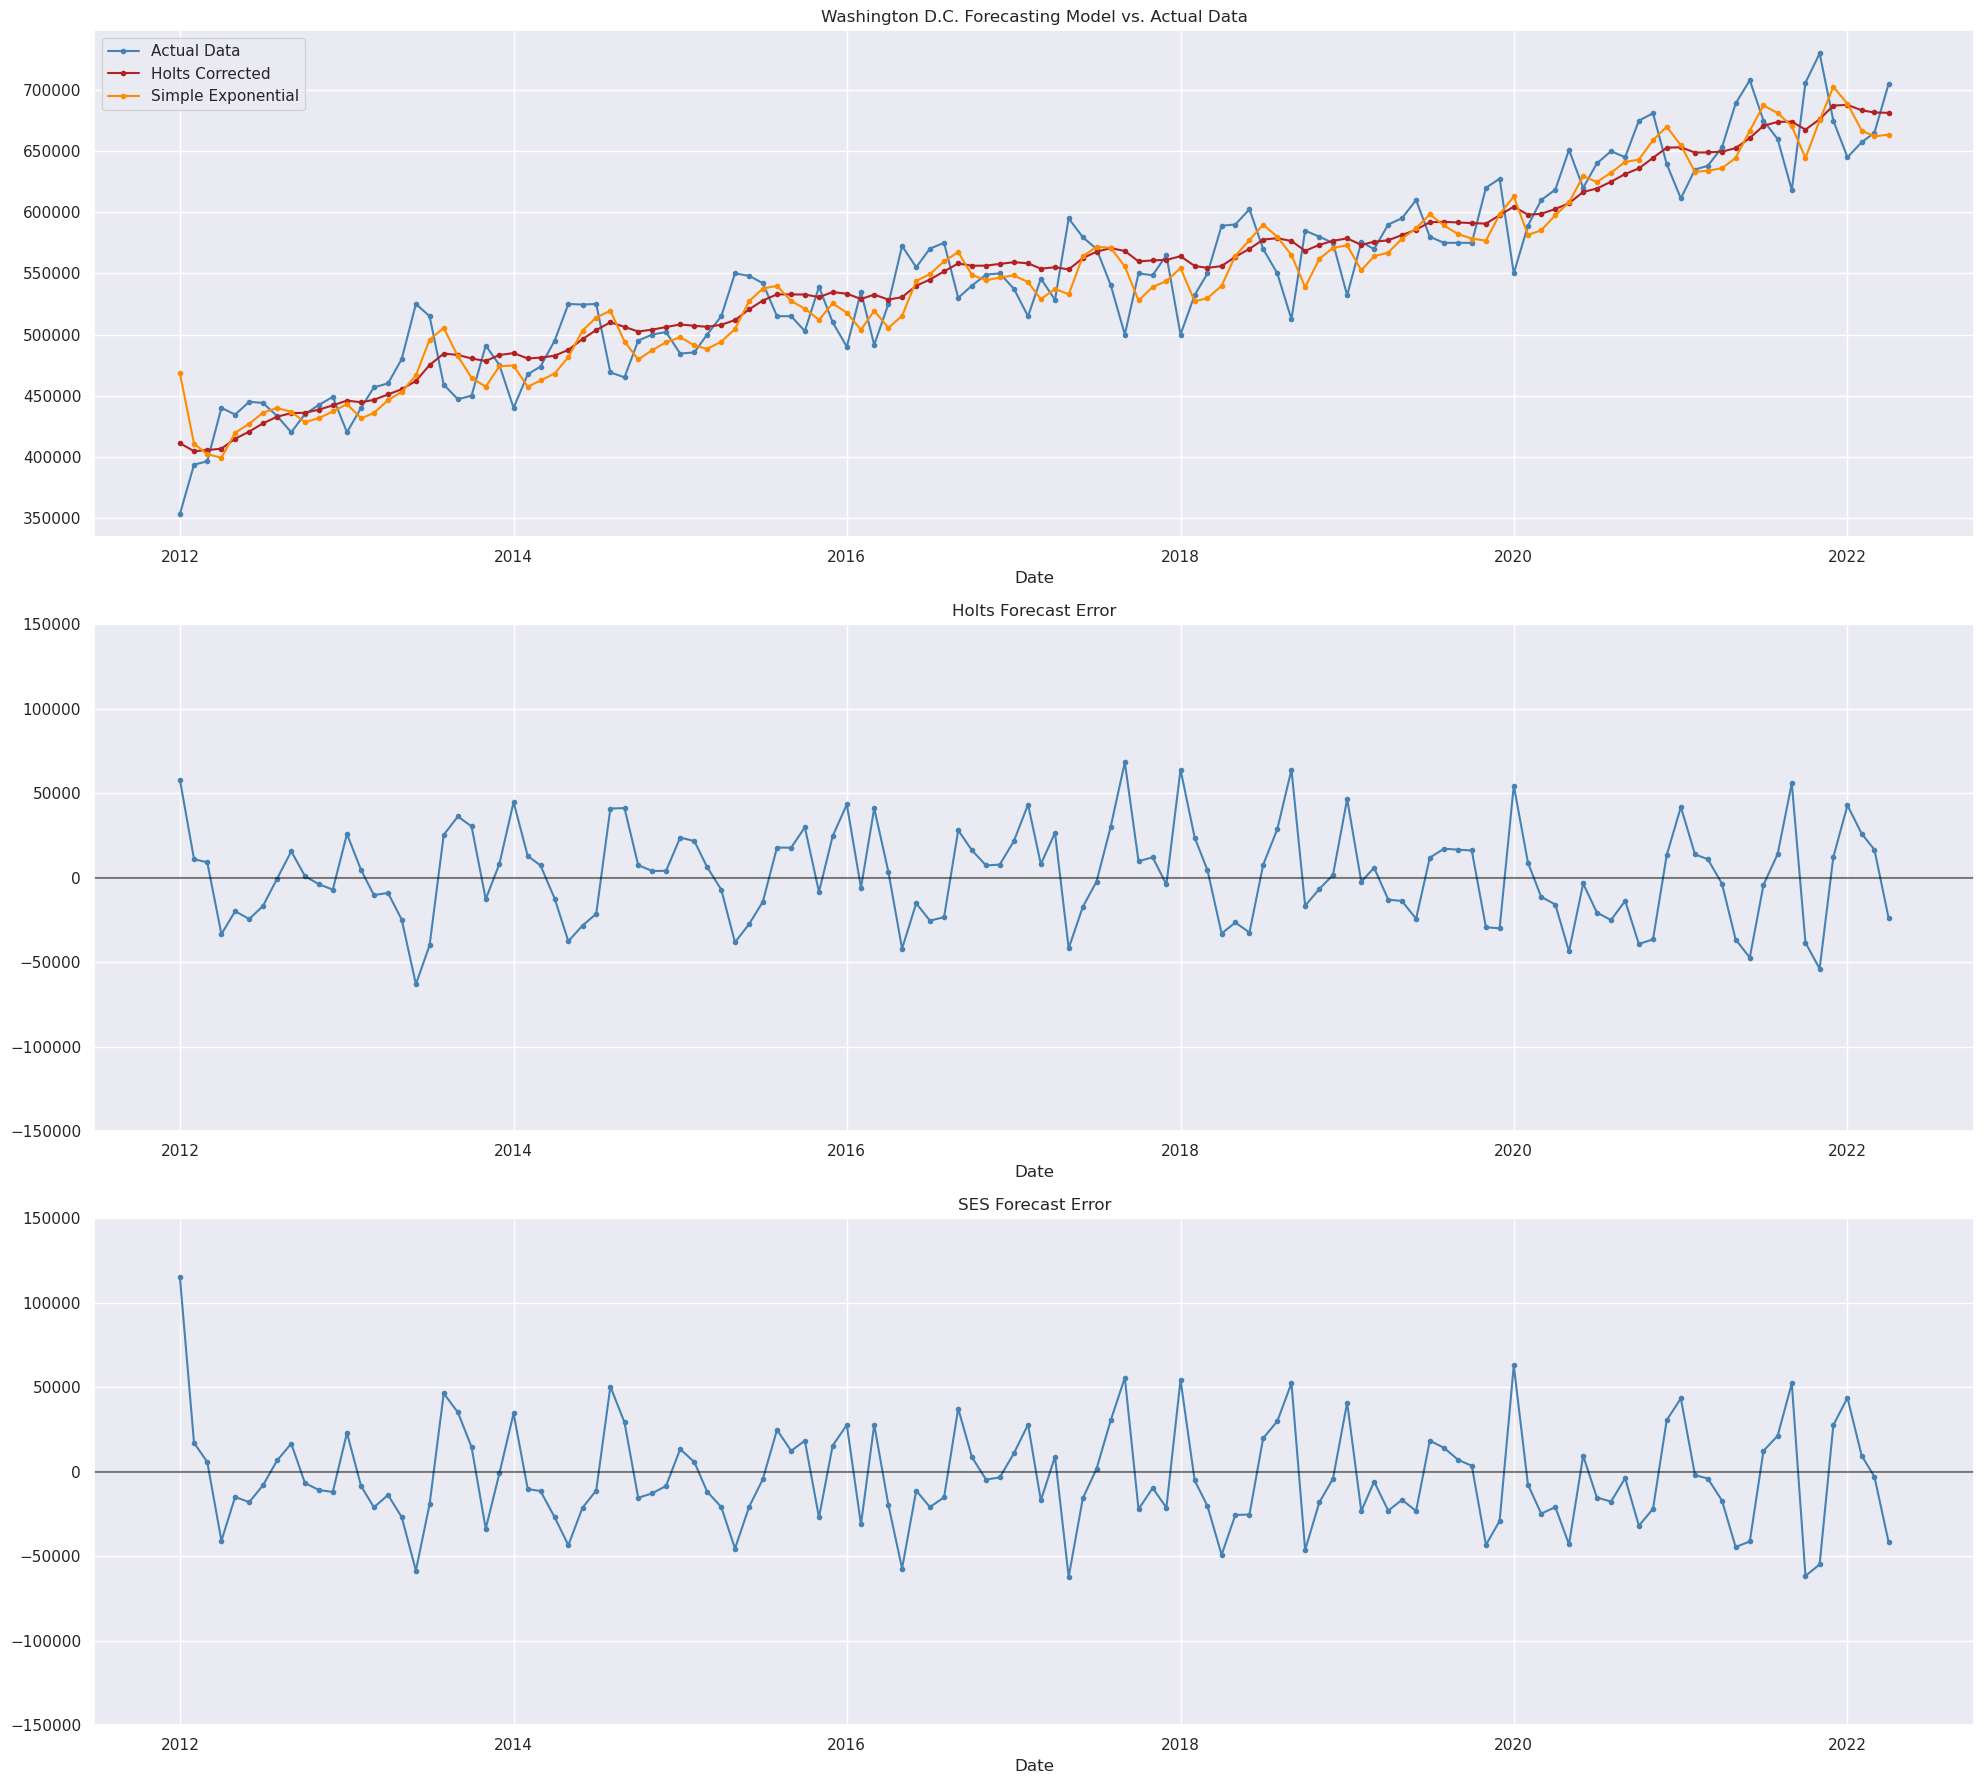

In [72]:
figure = plt.figure(figsize=(20, 18))

axes = figure.add_subplot(3, 1, 1)

axes.plot( DC[0][1].period_begin, DC[0][1].median_sale_price, color="steelblue", marker=".")
axes.plot( DC[0][1].period_begin, DC_holts, color="firebrick", marker=".")
axes.plot( DC[0][1].period_begin, DC_ses[0][3], color="darkorange", marker=".")
axes.set_xlabel( "Date")
axes.set_title("Washington D.C. Forecasting Model vs. Actual Data")
axes.legend(['Actual Data', 'Holts Corrected', 'Simple Exponential'])

axes = figure.add_subplot(3, 1, 2)

axes.plot( DC[0][1].period_begin, DC_error, color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_ylim(-150000, 150000)
axes.set_xlabel( "Date")
axes.set_title( "Holts Forecast Error")

axes = figure.add_subplot(3, 1, 3)

axes.plot( DC[0][1].period_begin, DC_ses[0][4], color="steelblue", marker=".")
axes.axhline(y=0.0, c="black", alpha=0.5)
axes.set_ylim(-150000, 150000)
axes.set_xlabel( "Date")
axes.set_title( "SES Forecast Error")

plt.tight_layout()
plt.show()

The Holt's forecast error is visually smaller than the SES model. This is especially true for the initial and more recent time points where SES has a much larger error compared to Holt's trend corrected. There does not seem to be an obvious sign of seasonality but we would need to look for auto-correlations in the errors to know for sure. For now, let's formulate predictions using our current model:

In [73]:
# 124 (index 123) is the last time point in the data
time_index = [124, 125, 126, 127]

DC_holts_predict = pd.DataFrame([holts_predict(DC_levels, FL_trends, time_index)], 
                                columns = ["(holts) 2022-05-01", "(holts) 2022-06-01", "(holts) 2022-07-01", "(holts) 2022-08-01"])

DC_ses_predict = pd.DataFrame(DC_predict.iloc[0]).T # Just All Residential prediction


DC_predict_compare = pd.concat([DC_ses_predict, DC_holts_predict], axis=1)

print(tabulate(DC_predict_compare.T[1:], headers = ['date','median sale price'],  tablefmt = 'fancy_grid'))


╒════════════════════╤═════════════════════╕
│ date               │   median sale price │
╞════════════════════╪═════════════════════╡
│ 2022-04-01         │              705000 │
├────────────────────┼─────────────────────┤
│ (SES) 2022-05-01   │              684275 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-05-01 │              690292 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-06-01 │              695447 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-07-01 │              700603 │
├────────────────────┼─────────────────────┤
│ (holts) 2022-08-01 │              705758 │
╘════════════════════╧═════════════════════╛


Unlike some of the previous states, the holt's trend corrected model predicts future values that are less than the last known time point, although they are still greater than the SES model. This could be due to the wider "variation" in median sale prices in D.C., but the predicted values do show a steady increase in sale prices that eventually exceeds the last known median sale price. Therefore, the holt's trend corrected model is superior to SES, in this case, but the D.C. time series data may benefit from incorporating seasonality in the forecast model.

<a id="5a"></a>

### Autocorrelations

[Back to Contents](#0)

Similar to how we would assess residuals to look for problems in linear regression models, we can look at the residuals associated with $t$, or our time points, to see if we tend to over/underestimate the median sale price in certain months. If we do, then we may be dealing with a seasonality which can be remedied by the Holt's-Winter forecast model. 

Let's begin with Arkansas and calculate the errors:

In [74]:
errors = AK[0][1].median_sale_price - AK_holts

pd.DataFrame(errors[0:25], columns=['error'])


error
0   -8087.38
1    4076.62
2   -4179.10
3    -162.76
4    7422.11
5   11132.89
6   -2137.58
7      59.59
8    1642.50
9   -1522.07
10 -10106.40
11  -1916.12
12  -1699.32
13  -6838.37
14   8184.38
15   7025.55
16   2215.81
17  -2559.62
18  11709.75
19   7557.68
20 -16314.73
21  -6839.40
22   3998.52
23  -3848.33
24 -25044.62

In [75]:
mean_error = errors.mean()

print(f"Mean Error: {mean_error}")

Mean Error: 423.81712594853184


We have a mean error of $\$$423.82, which means the median sale price is, on average, $\$$423.82 more than we predict. Using the mean error, we can calculate the deviations as follows:

In [76]:
deviations = errors - mean_error
pd.DataFrame(deviations[0:25], columns=['deviation'])

deviation
0    -8511.19
1     3652.81
2    -4602.91
3     -586.57
4     6998.29
5    10709.07
6    -2561.40
7     -364.23
8     1218.69
9    -1945.88
10  -10530.22
11   -2339.94
12   -2123.13
13   -7262.18
14    7760.57
15    6601.73
16    1791.99
17   -2983.44
18   11285.93
19    7133.86
20  -16738.55
21   -7263.22
22    3574.70
23   -4272.15
24  -25468.44

In order to determine if any errors are correlated with themselves at different time offsets, we need to:

- take the deviations and shift a copy by N periods, which in our case, will be from 1-12 for each month of the year
- return the correlation coefficient between the original deviations series and the N-shifted deviations series (using pandas built-in `corr()`, where we will look for linear relationships via Pearson's coefficient)

In addition, we will need to determine the cut-off where the correlation coefficient will be considered significant. We will use the following equation to determine the respective cutoff:

$cutoff = \frac{2}{\sqrt{N}}$

In [77]:
cutoff = 2.0 / np.sqrt( len( AK[0][1].median_sale_price))
print(f"Cutoff: {cutoff}")

Cutoff: 0.1796053020267749


In [78]:
correlations = []
for i in range( 1, 13):
    c = deviations.corr( deviations.shift( i), method="pearson")
    print(i, c)
    correlations.append( c)

1 0.04191452674189748
2 -0.21244159307875318
3 0.03470188915268233
4 0.0004971040844705673
5 -0.28535865404329575
6 -0.2910219472132075
7 0.02713370115392085
8 -0.13106145856569726
9 -0.011610699405456016
10 0.17166756966144464
11 0.29379952599322456
12 0.16041850325934284


Now, we can plot our results:

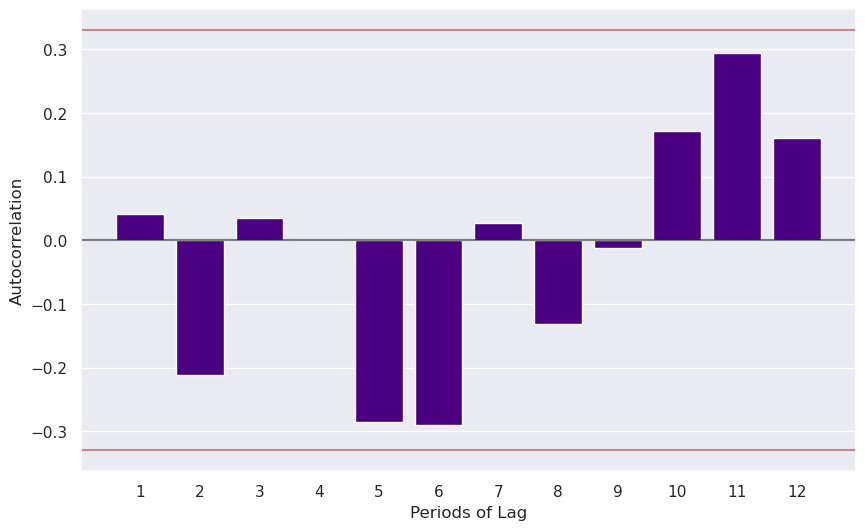

In [79]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(range( 0, 12), correlations, color="indigo", align="center")
axes.set_xticks(range( 0, 12))
axes.set_xticklabels(range( 1, 13))
axes.set_xlabel( "Periods of Lag")
axes.set_ylabel( "Autocorrelation")
axes.xaxis.grid(False)
axes.axhline(y=0, xmin=0, xmax=12, c="black", alpha=0.5)
axes.axhline(y=0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)
axes.axhline(y=-0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)

plt.show()

We do not see any autocorrelation's for Arkansas that are beyond the cut off. We can do the same process for all six states in order to determine if any would benefit from including seasonality in their forecast models (since this is repetitive, I will include less markdown cells).

We can continue with California:

In [80]:
errors = CA[0][1].median_sale_price - CA_holts

pd.DataFrame(errors[0:25], columns=['error'])


error
0  -31852.16
1    2351.97
2   14670.73
3   12148.68
4    4503.18
5    8182.15
6     837.93
7   -5243.80
8     347.29
9   -2000.23
10   2496.09
11  -1583.66
12 -22608.77
13 -16695.20
14  29829.22
15  18299.15
16  10302.69
17   4820.73
18   1218.19
19  -8429.90
20  -7542.92
21   -759.38
22  -5684.03
23  -5777.00
24 -20620.74

In [81]:
mean_error = errors.mean()

print(f"Mean Error: {mean_error}")

Mean Error: 659.6083796522214


In [82]:
deviations = errors - mean_error
pd.DataFrame(deviations[0:25], columns=['deviation'])

deviation
0   -32511.77
1     1692.36
2    14011.12
3    11489.07
4     3843.58
5     7522.54
6      178.33
7    -5903.41
8     -312.32
9    -2659.84
10    1836.48
11   -2243.26
12  -23268.38
13  -17354.81
14   29169.61
15   17639.55
16    9643.08
17    4161.12
18     558.58
19   -9089.51
20   -8202.53
21   -1418.99
22   -6343.64
23   -6436.61
24  -21280.35

In [83]:
cutoff = 2.0 / np.sqrt( len( CA[0][1].median_sale_price))
print(f"Cutoff: {cutoff}")

Cutoff: 0.1796053020267749


In [84]:
correlations = []
for i in range( 1, 13):
    c = deviations.corr( deviations.shift( i), method="pearson")
    print(i, c)
    correlations.append( c)

1 0.43672559556941515
2 -0.1767090248782477
3 -0.290704633477531
4 -0.13030764088230548
5 -0.11616402731120401
6 -0.10186277328916457
7 -0.10366602506907967
8 -0.05515417887817692
9 -0.14062832028175268
10 -0.08008726626060596
11 0.3380996536923355
12 0.6538058789762058


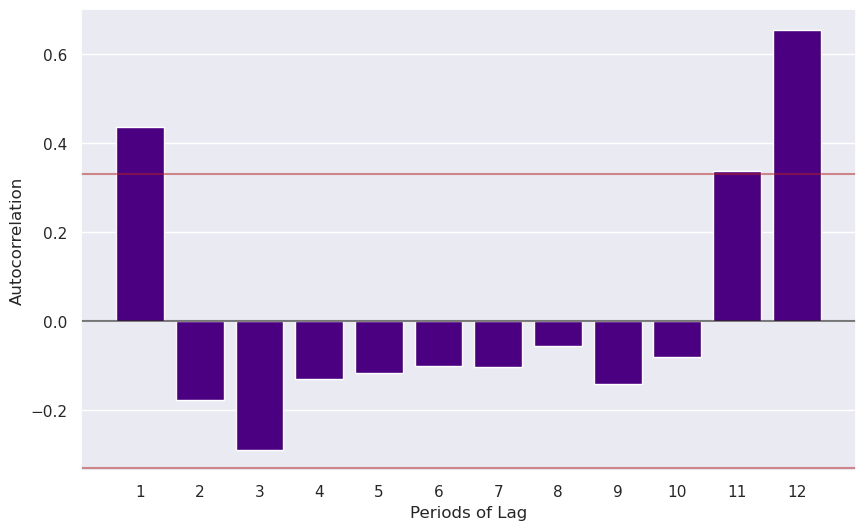

In [85]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(range( 0, 12), correlations, color="indigo", align="center")
axes.set_xticks(range( 0, 12))
axes.set_xticklabels(range( 1, 13))
axes.set_xlabel( "Periods of Lag")
axes.set_ylabel( "Autocorrelation")
axes.xaxis.grid(False)
axes.axhline(y=0, xmin=0, xmax=12, c="black", alpha=0.5)
axes.axhline(y=0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)
axes.axhline(y=-0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)

plt.show()

For California, we see three errors that are autocorrelated with themselves. Specifically, this is in January, November, and December where Decemeber has the highest autocorrelation.

We can continue with New York:

In [86]:
errors = NY[0][1].median_sale_price - NY_holts

pd.DataFrame(errors[0:25], columns=['error'])


error
0   -1360.58
1   -3966.93
2   -5665.40
3   -3166.71
4    8386.99
5    8450.50
6    7679.32
7    -259.97
8     627.86
9  -16697.95
10  -1705.32
11  11459.53
12  -7959.91
13   -935.23
14  -4794.49
15   4201.80
16   2273.23
17  16978.97
18   3947.98
19   3039.27
20 -12370.18
21   2055.54
22  -6764.85
23   1002.88
24   2492.85

In [87]:
mean_error = errors.mean()

print(f"Mean Error: {mean_error}")

Mean Error: 1914.4393534616368


In [88]:
deviations = errors - mean_error
pd.DataFrame(deviations[0:25], columns=['deviation'])

deviation
0    -3275.02
1    -5881.37
2    -7579.84
3    -5081.15
4     6472.55
5     6536.06
6     5764.88
7    -2174.41
8    -1286.58
9   -18612.39
10   -3619.76
11    9545.09
12   -9874.35
13   -2849.67
14   -6708.93
15    2287.36
16     358.79
17   15064.53
18    2033.54
19    1124.83
20  -14284.61
21     141.10
22   -8679.29
23    -911.56
24     578.41

In [89]:
cutoff = 2.0 / np.sqrt( len( NY[0][1].median_sale_price))
print(f"Cutoff: {cutoff}")

Cutoff: 0.1796053020267749


In [90]:
correlations = []
for i in range( 1, 13):
    c = deviations.corr( deviations.shift( i), method="pearson")
    print(i, c)
    correlations.append( c)

1 -0.013085836228977979
2 0.017675071042654502
3 -0.10674079467069351
4 -0.08452991705032749
5 -0.08359777269158218
6 0.020226278459259575
7 0.002789180023099833
8 -0.029981744004178783
9 -0.06532164109956122
10 -0.005721841306788874
11 0.101446839266824
12 0.10836823275913944


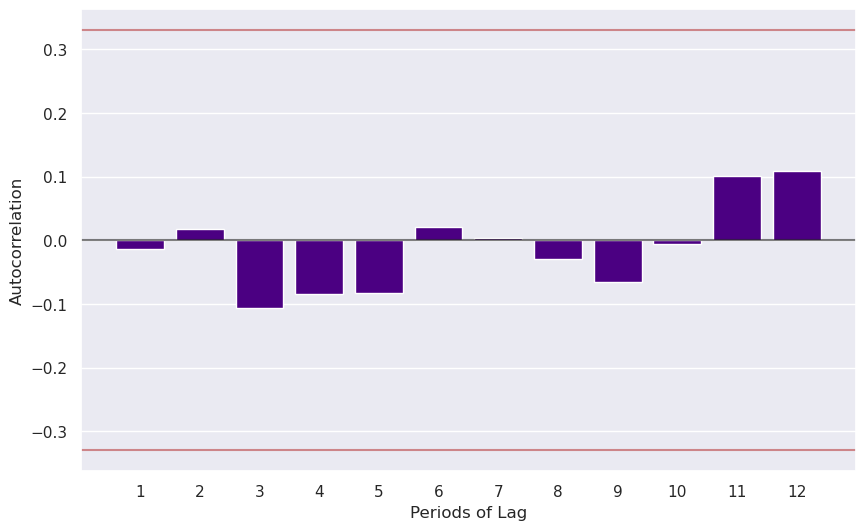

In [91]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(range( 0, 12), correlations, color="indigo", align="center")
axes.set_xticks(range( 0, 12))
axes.set_xticklabels(range( 1, 13))
axes.set_xlabel( "Periods of Lag")
axes.set_ylabel( "Autocorrelation")
axes.xaxis.grid(False)
axes.axhline(y=0, xmin=0, xmax=12, c="black", alpha=0.5)
axes.axhline(y=0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)
axes.axhline(y=-0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)

plt.show()

There are no obvious errors that autocorrelate with themselves in New York.

We can continue with Texas:

In [92]:
errors = TX[0][1].median_sale_price - TX_holts

pd.DataFrame(errors[0:25], columns=['error'])


error
0  -13151.05
1    7769.70
2    8701.99
3     125.16
4    4838.15
5    3137.39
6   -4410.68
7   -4142.50
8   -5798.80
9   -2857.96
10   1299.74
11   3828.45
12 -15184.16
13   5976.03
14  10328.47
15   7269.75
16   2767.19
17   2994.77
18  -3832.60
19  -4162.94
20  -6525.03
21  -4584.05
22    280.74
23   4626.61
24 -15675.73

In [93]:
mean_error = errors.mean()

print(f"Mean Error: {mean_error}")

Mean Error: 492.87764715835795


In [94]:
deviations = errors - mean_error
pd.DataFrame(deviations[0:25], columns=['deviation'])

deviation
0   -13643.93
1     7276.82
2     8209.11
3     -367.72
4     4345.28
5     2644.51
6    -4903.56
7    -4635.37
8    -6291.68
9    -3350.84
10     806.87
11    3335.57
12  -15677.04
13    5483.16
14    9835.60
15    6776.87
16    2274.31
17    2501.89
18   -4325.48
19   -4655.81
20   -7017.90
21   -5076.93
22    -212.13
23    4133.73
24  -16168.61

In [95]:
cutoff = 2.0 / np.sqrt( len( TX[0][1].median_sale_price))
print(f"Cutoff: {cutoff}")

Cutoff: 0.1796053020267749


In [96]:
correlations = []
for i in range( 1, 13):
    c = deviations.corr( deviations.shift( i), method="pearson")
    print(i, c)
    correlations.append( c)

1 0.012093368610875378
2 -0.0028940454241325915
3 0.005382206798497531
4 -0.07420177621936236
5 -0.2734909710393148
6 0.003669734441182062
7 -0.2494359748933461
8 -0.07526327171997306
9 0.050596490230094104
10 0.07868199330378813
11 -0.02504691647269018
12 0.851524585472141


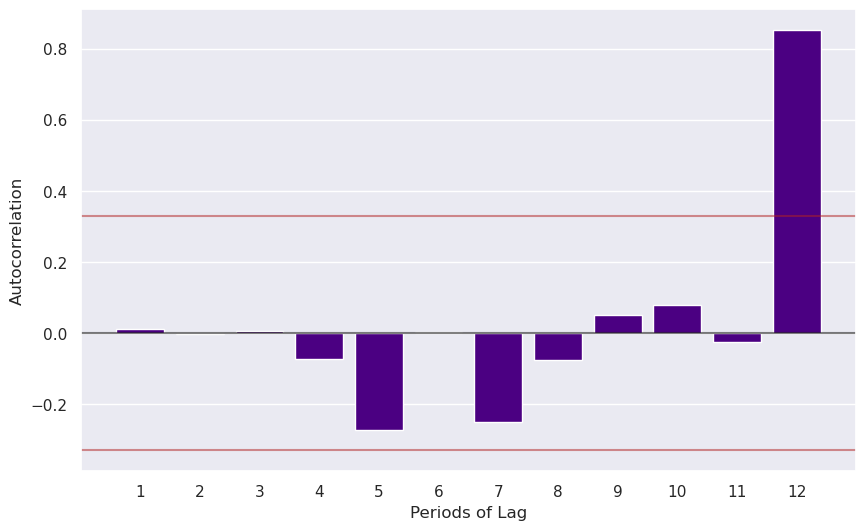

In [97]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(range( 0, 12), correlations, color="indigo", align="center")
axes.set_xticks(range( 0, 12))
axes.set_xticklabels(range( 1, 13))
axes.set_xlabel( "Periods of Lag")
axes.set_ylabel( "Autocorrelation")
axes.xaxis.grid(False)
axes.axhline(y=0, xmin=0, xmax=12, c="black", alpha=0.5)
axes.axhline(y=0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)
axes.axhline(y=-0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)

plt.show()

There is one error that autocorrelates with itself in Texas. Specifically, this error is in December which has relatively high autocorrelation.

We can continue with Florida:

In [98]:
errors = FL[0][1].median_sale_price - FL_holts

pd.DataFrame(errors[0:25], columns=['error'])


error
0   -7368.00
1     480.77
2    5230.70
3    4367.49
4    2199.43
5    1847.11
6   -5166.14
7   -2529.40
8    -352.79
9   -4210.06
10   4001.44
11   4545.87
12 -10918.71
13   2275.22
14   7472.01
15   2580.14
16   4277.96
17   3040.83
18  -1452.17
19  -1410.84
20  -5626.62
21  -5834.56
22   -290.07
23   5082.61
24 -11565.57

In [99]:
mean_error = errors.mean()

print(f"Mean Error: {mean_error}")

Mean Error: 471.3852371994245


In [100]:
deviations = errors - mean_error
pd.DataFrame(deviations[0:25], columns=['deviation'])

deviation
0    -7839.38
1        9.38
2     4759.31
3     3896.11
4     1728.05
5     1375.72
6    -5637.52
7    -3000.78
8     -824.17
9    -4681.45
10    3530.06
11    4074.49
12  -11390.10
13    1803.83
14    7000.62
15    2108.75
16    3806.57
17    2569.44
18   -1923.56
19   -1882.23
20   -6098.01
21   -6305.95
22    -761.45
23    4611.22
24  -12036.96

In [101]:
cutoff = 2.0 / np.sqrt( len( FL[0][1].median_sale_price))
print(f"Cutoff: {cutoff}")

Cutoff: 0.1796053020267749


In [102]:
correlations = []
for i in range( 1, 13):
    c = deviations.corr( deviations.shift( i), method="pearson")
    print(i, c)
    correlations.append( c)

1 0.08675648382718569
2 -0.17715339871181285
3 0.10248149314300428
4 -0.17765703744741357
5 -0.1475986263516301
6 0.0970804148355272
7 -0.1890191637232182
8 -0.16394581263915356
9 0.17645709377443786
10 -0.05763809486807723
11 0.05462608425803668
12 0.6772578734550164


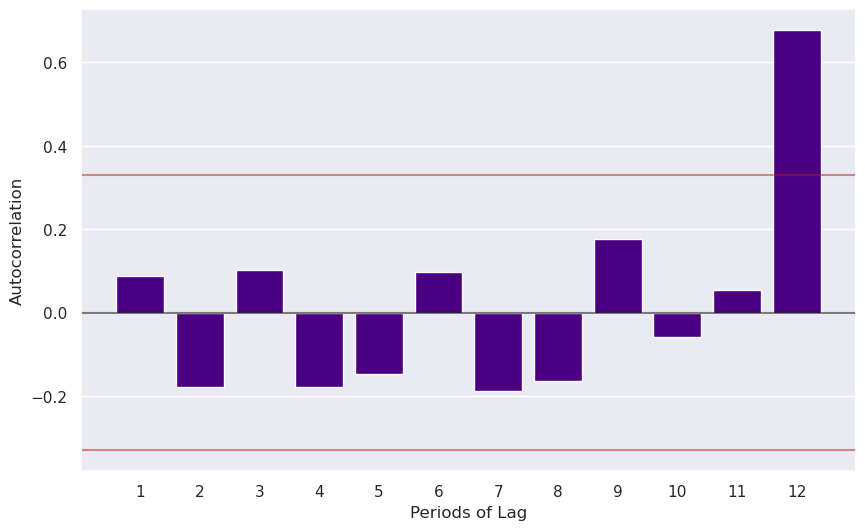

In [103]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(range( 0, 12), correlations, color="indigo", align="center")
axes.set_xticks(range( 0, 12))
axes.set_xticklabels(range( 1, 13))
axes.set_xlabel( "Periods of Lag")
axes.set_ylabel( "Autocorrelation")
axes.xaxis.grid(False)
axes.axhline(y=0, xmin=0, xmax=12, c="black", alpha=0.5)
axes.axhline(y=0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)
axes.axhline(y=-0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)

plt.show()

There is one error that autocorrelates with itself in Florida. Specifically, this error is in December which is very obvious compared to other months.

Finally, we can look at Washington D.C.:

In [104]:
errors = DC[0][1].median_sale_price - DC_holts

pd.DataFrame(errors[0:25], columns=['error'])


error
0  -58126.58
1  -11023.32
2   -9138.94
3   33358.56
4   19803.09
5   24384.80
6   16694.43
7     507.81
8  -15689.77
9    -970.63
10   3895.00
11   6975.89
12 -25947.32
13  -4561.29
14  10210.26
15   9002.03
16  24772.72
17  62980.45
18  39974.18
19 -25415.04
20 -36301.32
21 -30387.72
22  12628.33
23  -8258.40
24 -44790.04

In [105]:
mean_error = errors.mean()

print(f"Mean Error: {mean_error}")

Mean Error: -1928.1492661619775


In [106]:
deviations = errors - mean_error
pd.DataFrame(deviations[0:25], columns=['deviation'])

deviation
0   -56198.43
1    -9095.17
2    -7210.79
3    35286.71
4    21731.24
5    26312.95
6    18622.58
7     2435.95
8   -13761.62
9      957.52
10    5823.15
11    8904.04
12  -24019.17
13   -2633.14
14   12138.41
15   10930.18
16   26700.86
17   64908.60
18   41902.33
19  -23486.89
20  -34373.17
21  -28459.57
22   14556.48
23   -6330.25
24  -42861.89

In [107]:
cutoff = 2.0 / np.sqrt( len( DC[0][1].median_sale_price))
print(f"Cutoff: {cutoff}")

Cutoff: 0.1796053020267749


In [108]:
correlations = []
for i in range( 1, 13):
    c = deviations.corr( deviations.shift( i), method="pearson")
    print(i, c)
    correlations.append( c)

1 0.34236362797082237
2 -0.08500674849450088
3 -0.2919115148273612
4 -0.18238510607781547
5 0.015653541793466865
6 0.07624830992863564
7 -0.08821030780483509
8 -0.17168953247662627
9 -0.26839669106047637
10 -0.032713278780105666
11 0.3741224408508472
12 0.6270563273992087


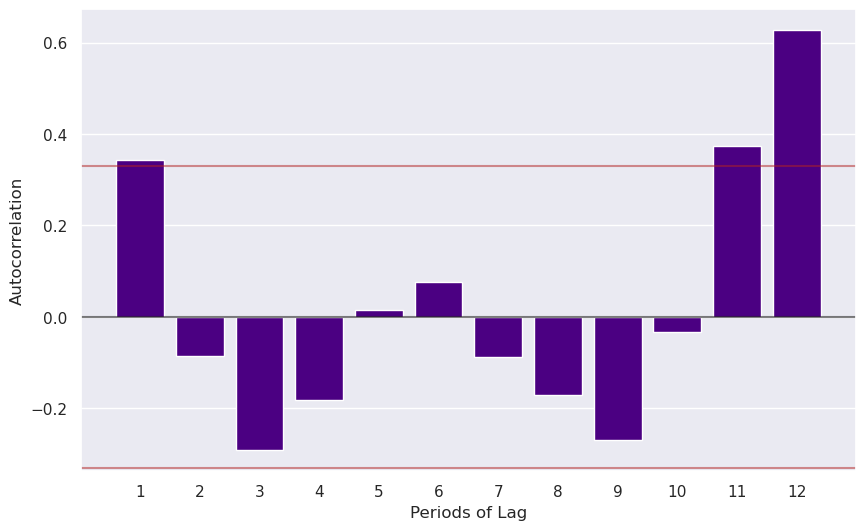

In [109]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(range( 0, 12), correlations, color="indigo", align="center")
axes.set_xticks(range( 0, 12))
axes.set_xticklabels(range( 1, 13))
axes.set_xlabel( "Periods of Lag")
axes.set_ylabel( "Autocorrelation")
axes.xaxis.grid(False)
axes.axhline(y=0, xmin=0, xmax=12, c="black", alpha=0.5)
axes.axhline(y=0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)
axes.axhline(y=-0.33, xmin=0, xmax=12, c="firebrick", alpha=0.5)

plt.show()

There are three errors that autocorrelate with themselves in Washington D.C. Specifically, these errors are in January, November, and December, where December has the highest and most dramatic autocorrelation.  

<a id="5"></a>

### Holt's-Winters

[Back to Contents](#0)

For situations where errors are autocorrelating with themselves, we can apply the multiplicative Holts-Winters model to factor in seasonality. 

&nbsp;

The forecasting model is as follows:

$forecast_{t} = (level_{t} + trend_{t}) \times seasonality_t \times other + \epsilon$

&nbsp;

The three parts needed can be calculated as follows:

- $level_{t} = level_{t-1} + trend_{t-1} + \alpha \frac{error}{seasonality_{t-1}}$

- $trend_{t} = trend_{t-1} + \gamma \alpha \frac{error}{seasonality_{t-1}}$

- $seasonality_{t} = seasonality_{t-1} + \delta (1 - \alpha) \frac{error}{level_{t-1} + trend_{t-1}}$

&nbsp;

Based on the results previously, we found that California, Texas, Florida, and DC had possible seasonality that could be remedied with this model. First, we need to identify the seasonality, then remove the seasonality from the data, then identify the trend and level using the *de-seasonalized* data. Since we have 10 cycles of data for each time series, we can move forward with these steps, starting with California (we need at minimum two cycles).

We will need to calculate the 12-month *centered* moving average which we will use to smooth the data and identify the seasonality. We will need two moving averages which different offsets which we will further average together, since there is no *true* center to 12 periods. After we calculate the seasonal factors, we simply divide the raw data by the seasonal factors. We can generate a function to perform this (2 by 12 Moving average) for us and return the seasonal factors, as well as the de-seaonalized data:

In [110]:
def seasonal_adjustment(data):
    moving_average = data.rolling(window=12, center=True).mean()

    shifted_ma = []
    n = len(data)
    for i in range( 0, n):
        current = None
        if 5 < i < (n-5):
            current = data[ i-5:i+7].mean()
        shifted_ma.append( current)
    shifted_moving_average = pd.Series( shifted_ma)

    smoothed = (moving_average + shifted_moving_average) / 2.0
    smoothed[n-6] = None

    seasonal_factor_estimate = data / smoothed

    initial_seasonal_factors = [
    seasonal_factor_estimate[[ 0, 12, 24, 36, 48, 60, 72, 84,  96, 108, 120]].mean(),
    seasonal_factor_estimate[[ 1, 13, 25, 37, 49, 61, 73, 85,  97, 109, 121]].mean(),
    seasonal_factor_estimate[[ 2, 14, 26, 38, 50, 62, 74, 86,  98, 110, 122]].mean(),
    seasonal_factor_estimate[[ 3, 15, 27, 39, 51, 63, 75, 87,  99, 111, 123]].mean(),
    seasonal_factor_estimate[[ 4, 16, 28, 40, 52, 64, 76, 88, 100, 112]].mean(),
    seasonal_factor_estimate[[ 5, 17, 29, 41, 53, 65, 77, 89, 101, 113]].mean(),
    seasonal_factor_estimate[[ 6, 18, 30, 42, 54, 66, 78, 90, 102, 114]].mean(),
    seasonal_factor_estimate[[ 7, 19, 31, 43, 55, 67, 79, 91, 103, 115]].mean(),
    seasonal_factor_estimate[[ 8, 20, 32, 44, 56, 68, 80, 92, 104, 116]].mean(),
    seasonal_factor_estimate[[ 9, 21, 33, 45, 57, 69, 81, 93, 105, 117]].mean(),
    seasonal_factor_estimate[[10, 22, 34, 46, 58, 70, 82, 94, 106, 118]].mean(),
    seasonal_factor_estimate[[11, 23, 35, 47, 59, 71, 83, 95, 107, 119]].mean()]

    seasonal_factors = pd.Series( 
    initial_seasonal_factors + deepcopy( initial_seasonal_factors) + deepcopy(initial_seasonal_factors) +  \
    deepcopy(initial_seasonal_factors) + deepcopy(initial_seasonal_factors) + deepcopy(initial_seasonal_factors) + \
    deepcopy(initial_seasonal_factors) + deepcopy(initial_seasonal_factors) + deepcopy(initial_seasonal_factors) + \
    deepcopy(initial_seasonal_factors) + deepcopy(initial_seasonal_factors[0:4])) 

    deseasonalized_data = data / seasonal_factors
    
    return initial_seasonal_factors, seasonal_factors, deseasonalized_data

In [111]:

CA_initial_seasonal_factors, CA_seasonal_factors, CA_deseasonalized_data = seasonal_adjustment(CA[0][1].median_sale_price)

CA_result = pd.concat([CA_seasonal_factors, CA_deseasonalized_data], axis=1)
CA_result.columns = ["seasonal factors", "deseasonalized"]
CA_df = pd.concat([CA[0][1], CA_result], axis=1)
CA_df

period_begin  median_sale_price    t  seasonal factors  deseasonalized
0     2012-01-01          283000.00    1              0.94       302551.56
1     2012-02-01          289300.00    2              0.95       303461.85
2     2012-03-01          307600.00    3              1.00       308830.83
3     2012-04-01          323400.00    4              1.02       316990.41
4     2012-05-01          331700.00    5              1.03       321751.33
5     2012-06-01          343800.00    6              1.04       331487.13
6     2012-07-01          348600.00    7              1.03       339021.65
7     2012-08-01          347400.00    8              1.01       342300.42
8     2012-09-01          351800.00    9              1.00       351422.43
9     2012-10-01          353800.00   10              1.00       352241.37
10    2012-11-01          360300.00   11              1.00       359564.50
11    2012-12-01          362700.00   12              0.98       370899.52
12    2013-01-01          344100.00   13              0.94       367872.77
13    2013-02-01          331400.00   14              0.95       347622.73
14    2013-03-01          365000.00   15              1.00       366460.51
15    2013-04-01          386900.00   16              1.02       379231.88
16    2013-05-01          401100.00   17              1.03       389069.82
17    2013-06-01          410000.00   18              1.04       395316.24
18    2013-07-01          415400.00   19              1.03       403986.21
19    2013-08-01          411200.00   20              1.01       405163.88
20    2013-09-01          407900.00   21              1.00       407462.22
21    2013-10-01          411300.00   22              1.00       409488.06
22    2013-11-01          409700.00   23              1.00       408863.65
23    2013-12-01          408000.00   24              0.98       417223.62
24    2014-01-01          391400.00   25              0.94       418440.57
25    2014-02-01          401500.00   26              0.95       421154.28
26    2014-03-01          420800.00   27              1.00       422483.79
27    2014-04-01          432000.00   28              1.02       423438.02
28    2014-05-01          442700.00   29              1.03       429422.11
29    2014-06-01          447400.00   30              1.04       431376.80
30    2014-07-01          446900.00   31              1.03       434620.70
31    2014-08-01          448600.00   32              1.01       442014.88
32    2014-09-01          437700.00   33              1.00       437230.24
33    2014-10-01          444200.00   34              1.00       442243.12
34    2014-11-01          441800.00   35              1.00       440898.13
35    2014-12-01          431000.00   36              0.98       440743.58
36    2015-01-01          413500.00   37              0.94       442067.39
37    2015-02-01          431900.00   38              0.95       453042.42
38    2015-03-01          454900.00   39              1.00       456720.24
39    2015-04-01          468600.00   40              1.02       459312.63
40    2015-05-01          477400.00   41              1.03       463081.36
41    2015-06-01          482600.00   42              1.04       465316.15
42    2015-07-01          478800.00   43              1.03       465644.19
43    2015-08-01          474500.00   44              1.01       467534.68
44    2015-09-01          465300.00   45              1.00       464800.62
45    2015-10-01          467000.00   46              1.00       464942.68
46    2015-11-01          476200.00   47              1.00       475227.90
47    2015-12-01          469900.00   48              0.98       480522.99
48    2016-01-01          452800.00   49              0.94       484082.50
49    2016-02-01          455900.00   50              0.95       478217.27
50    2016-03-01          474900.00   51              1.00       476800.27
51    2016-04-01          499900.00   52              1.02       489992.29
52    2016-05-01          508

We can plot the raw time series data with the de-seasonalized data for comparison:

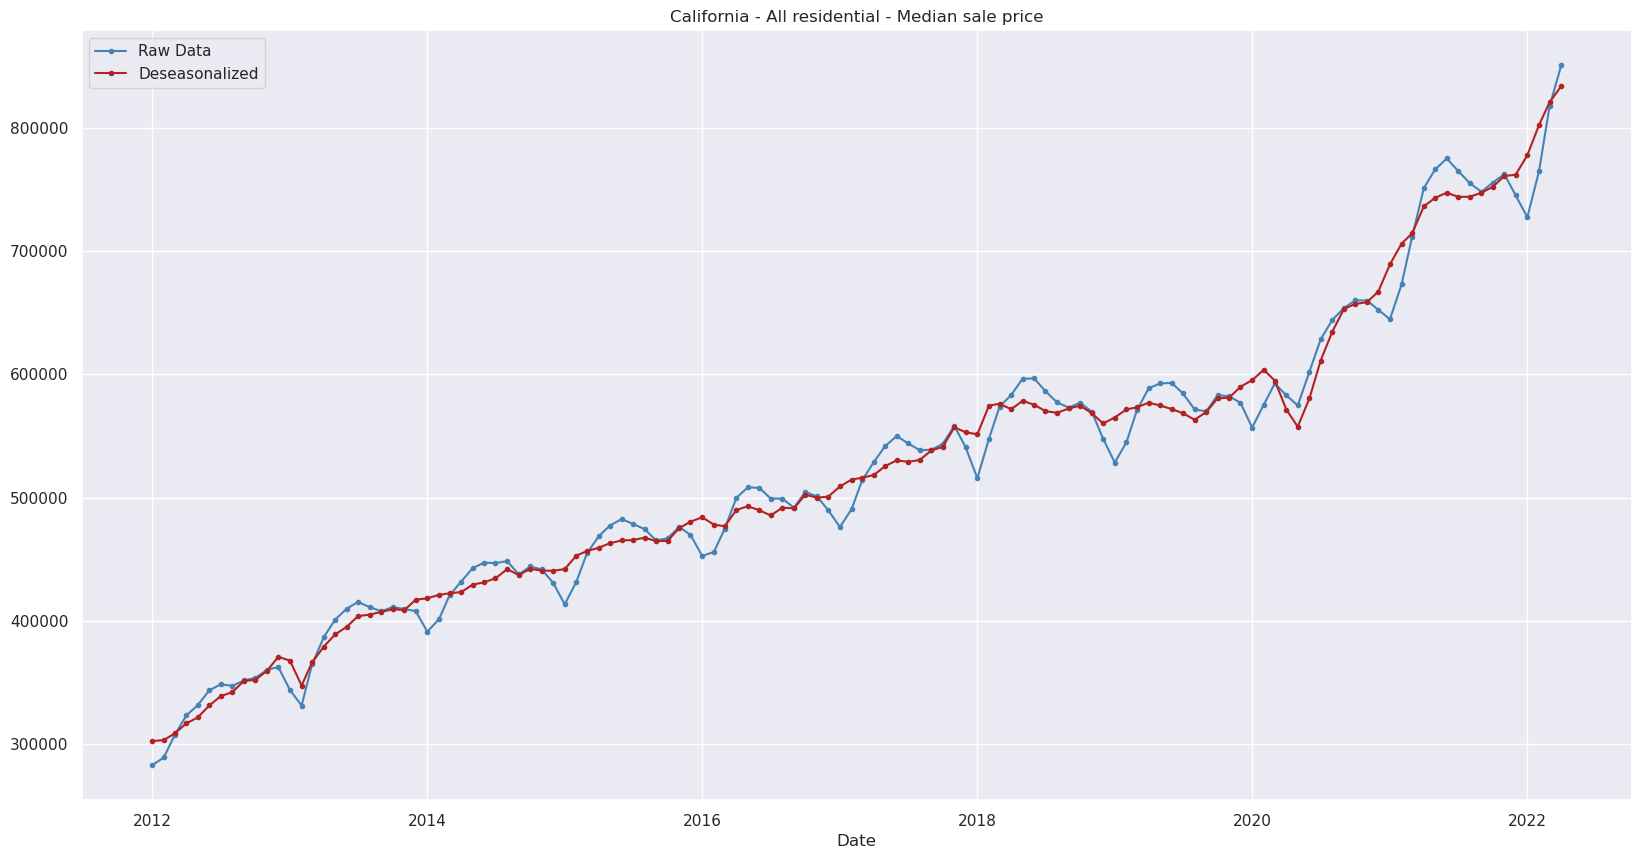

In [112]:
figure = plt.figure(figsize=(20, 10))
axes = figure.add_subplot(1, 1, 1)
axes.plot( CA_df.period_begin, CA_df.median_sale_price, color="steelblue", marker=".")
axes.plot( CA_df.period_begin, CA_df.deseasonalized, color="firebrick", marker=".")
axes.set_title( "California - All residential - Median sale price")
axes.set_xlabel("Date")
axes.legend(["Raw Data", "Deseasonalized"])

plt.show()

The seasonality in the actual data is even more apparent when we compare it to the de-seasonalized data. Now we determine the level and trend based on the de-seasonalized data:

In [113]:
describe_fit( lm( "deseasonalized ~ t", data=CA_df), return_coefficient=False)

regression:  deseasonalized ~ t
n:  124
--------------------------------
intercept:  315576.18919096305
t:  3322.8587480823717
--------------------------------
sigma 31122.80420918535
R^2 0.9368861372678403


Based on these results, we have the following for the Holt's-Winter model: 
- $level_{0} = \$315,576.19$
- $trend_{0} = \$3,322.86$

However, for consistency with the previous models, we will estimate the level and trend using the initial third of values. 

In [114]:
CA_beta = describe_fit( lm( "deseasonalized ~ t", data=CA_df.iloc[0:42]))

regression:  deseasonalized ~ t
n:  42
--------------------------------
intercept:  312222.81228064647
t:  3885.418459016337
--------------------------------
sigma 9819.922598084082
R^2 0.9602388058832851


Based on these results, we have the following for the Holt's-Winter model: 
- $level_{0} = \$312,222.81$
- $trend_{0} = \$3,885.42$

We can use the following functions to calculate the holts-winters data:

In [115]:
def holt_winters_one_step( alpha, gamma, delta, level, trend, error, factor):
    this_factor = factor + delta * (1.0 - alpha) * error / ( level + trend)
    this_trend = trend + (gamma * alpha * error) / factor
    this_level = level + trend + (alpha * error) / factor
    return (this_factor, this_trend, this_level)
def holt_winters_forecast( level_0, trend_0, alpha, gamma, delta, actual, seasonality):
    n = len( actual)
    trend, level, factor = trend_0, level_0, seasonality[ 0]
    factors = []
    trends = []
    levels = []
    forecasts = []
    
    for i in range( 0, n):
        if i < 12:
            factor = seasonality[ i]
        else:
            factor = factors[ i - 12]
        forecast = (level + trend) * factor
        forecasts.append( forecast)
        
        error = actual[ i] - forecast
        factor, trend, level = holt_winters_one_step( alpha, gamma, delta, level, trend, error, factor)
        
        factors.append( factor)
        trends.append( trend)
        levels.append( level)
        
            
        #print(forecast, error, level, trend, factor)
    return (pd.Series( forecasts), pd.Series( levels), pd.Series( trends), pd.Series(factors))

We can generate the following function for the grid search for ideal values of $\alpha$ and $\gamma$:

In [116]:
def grid_search_winters(beta0, beta1, data, seasonality, values = list):
    if len(values) == 1:
        grid = pd.DataFrame( columns=values[0])

        for alpha in values[0]:
            sse_ = []

            for gamma in values[0]:
                winters, _ , _ , _ = holt_winters_forecast( beta0, beta1, alpha, gamma, 0, data, seasonality)
                sse = ((winters - data)**2.0).sum()
                sse_.append(sse)
        
            grid.loc[len(grid)] = sse_
    
    elif len(values) == 2:
        grid = pd.DataFrame( columns=values[1])

        for alpha in values[0]:
            sse_ = []

            for gamma in values[1]:
                winters, _ , _ , _ = holt_winters_forecast( beta0, beta1, alpha, gamma, 0, data, seasonality)
                sse = ((winters - data)**2.0).sum()
                sse_.append(sse)
        
            grid.loc[len(grid)] = sse_
        
    grid.index = values[0]   
    min_error = grid.to_numpy().min()
    gamma_ = grid.columns[grid.eq(min_error).any()][0]
    alpha_ = grid.index[grid[gamma_]==min_error][0]
    return grid, alpha_, gamma_

We can perform the initial grid search as follows:

In [117]:
values = [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

CA_grid, CA_alpha, CA_gamma= grid_search_winters(CA_beta[0], CA_beta[1], CA_df.median_sale_price, CA_initial_seasonal_factors, values=values)
print(f"Alpha: {CA_alpha} \
        Gamma: {CA_gamma} ")

CA_grid

Alpha: 0.9         Gamma: 0.1 


0.10           0.20           0.30           0.40           0.50           0.60           0.70           0.80           0.90
0.10 61519183107.33 52548864741.37 45537637257.76 40840589388.85 36652262277.09 34435316795.44 34566946771.59 36200535476.07 38629733699.16
0.20 28610638039.05 25540984585.39 24771548585.83 25413729198.95 26559385560.66 27321887503.35 27392357756.26 27049194939.73 26767609295.00
0.30 19892326899.33 19272712111.71 19799467349.62 20427393529.20 20810788041.26 21136300375.58 21671180308.87 22508673701.33 23590439831.37
0.40 16040719997.49 16101461096.77 16645138457.44 17160443406.14 17697477852.87 18362459910.75 19142687993.66 19954494663.53 20709145953.01
0.50 13687519710.16 13933098370.56 14432737965.97 14940477421.64 15480740408.73 16037893537.41 16550726109.87 16961843741.11 17241034633.57
0.60 12009189591.46 12295595845.65 12734032002.30 13166662561.27 13578290332.37 13935033214.14 14204529476.27 14377583273.63 14467981948.92
0.70 10727213241.74 11005250196.94 11373907294.49 11715647271.25 12009587275.31 12238321931.05 12398768859.76 12504192558.39 12575605431.81
0.80  9721475713.82  9979131245.91 10290347008.87 10566590464.42 10795179830.46 10974537187.65 11114584017.36 11231994443.59 11343493147.15
0.90  8929075410.52  9171539828.81  9448241522.02  9693891936.07  9904860391.10 10088383505.51 10258399492.31 10430868920.15 10620465324.62

Now that we have narrowed down what $\alpha$ and $\gamma$ should be via the initial grid search, we can do a higher granularity grid search as follows:

In [118]:
values = [[0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99],
          [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]]

CA_grid, CA_alpha, CA_gamma= grid_search_winters(CA_beta[0], CA_beta[1], CA_df.median_sale_price, CA_initial_seasonal_factors, values=values)
print(f"Alpha: {CA_alpha} \
        Gamma: {CA_gamma} ")

CA_grid

Alpha: 0.99         Gamma: 0.07 


0.01          0.02          0.03          0.04          0.05          0.06          0.07          0.08          0.09          0.10          0.11          0.12          0.13  \
0.81 9955349237.63 9897809165.97 9820655120.00 9750521158.15 9696230279.49 9658759578.61 9636236699.28 9626086606.41 9625843866.16 9633401239.68 9647040338.30 9665388644.04 9687359451.00   
0.82 9857287602.68 9801356404.31 9726412299.53 9658424737.46 9605963050.68 9569947885.97 9548529988.99 9539182657.47 9539491712.18 9547396136.40 9561216703.30 9579613198.00 9601525260.67   
0.83 9761664168.65 9707297068.66 9634492693.11 9568579443.84 9517883117.08 9483271012.79 9462916992.41 9454341564.34 9455180400.37 9463417354.93 9477411172.95 9495852931.23 9517707768.75   
0.84 9668412006.47 9615566430.07 9544835148.19 9480928006.70 9431936886.59 9398678654.55 9379350266.04 9371518344.10 9372867053.91 9381423818.71 9395584210.09 9414069624.79 9435869887.80   
0.85 9577467492.45 9526102972.90 9457381545.31 9395415980.23 9348073386.59 9316122936.82 9297784626.89 9290670124.26 9292510774.22 9301376312.98 9315698036.70 9334226728.12 9355976118.14   
0.86 9488770110.08 9438848201.09 9372076615.35 9311991574.26 9266244108.76 9235558273.47 9218177022.94 9211756024.39 9214072532.63 9223237385.69 9237716543.16 9256289275.90 9277992471.80   
0.87 9402262268.54 9353746460.98 9288867772.79 9230605500.26 9186402868.15 9156941238.07 9140486415.91 9134737049.32 9137515073.17 9146971258.86 9161605207.50 9180223814.52 9201886405.49   
0.88 9317889136.25 9270744779.16 9207704963.41 9151210830.99 9108505674.99 9080230447.32 9064673675.51 9059575993.13 9062802825.37 9072543749.48 9087331023.66 9105998337.10 9127626761.97   
0.89 9235598488.28 9189792714.16 9128540525.22 9073762872.68 9032510618.30 9005386455.52 8990701483.76 8986237352.66 8989901826.11 8999922198.98 9014862437.93 9033582226.37 9055183718.85   
0.90 9155340566.44 9110842220.52 9051329061.39 8998219048.49 8958377760.08 8932371658.87 8918534248.84 8914687249.87 8918779649.80 8929075410.52 8944169292.78 8962946204.60 8984528744.19   
0.91 9077067950.83 9033847524.50 8976027324.25 8924538792.45 8886069039.26 8861150209.02 8848138027.30 8844893362.14 8849405346.03 8859973593.41 8875222777.58 8894062289.97 8915634558.30   
0.92 9000735442.10 8958765010.19 8902594109.37 8852683452.88 8815548184.59 8791687934.84 8779480454.19 8776824859.93 8781749384.19 8792588314.11 8807995385.36 8826903758.95 8848475101.16   
0.93 8926299953.45 8885553115.41 8830990158.86 8782616204.51 8746780635.64 8723952271.91 8712530680.30 8710452351.24 8715783604.41 8726892453.14 8742460875.41 8761445114.01 8783025505.14   
0.94 8853720411.66 8814172236.40 8761178073.25 8714301968.68 8679733471.40 8657912199.05 8647259316.02 8645747832.13 8651481174.38 8662860167.69 8678594241.12 8697662056.47 8719262072.47   
0.95 8782957666.36 8744584640.83 8693122231.26 8647707341.01 8614375345.86 8593538181.36 8583638381.38 8582684643.19 8588816551.59 8600466859.23 8616371682.73 8635531464.02 8657162257.35   
0.96 8713974407.12 8676754388.44 8626788716.85 8582800525.88 8550676429.96 8530802119.30 8521641261.68 8521237431.23 8527765450.68 8539689146.13 8555770584.74 8575031372.69 8596704652.20   
0.97 8646735087.66 8610647258.69 8562145253.08 8519551277.41 8488608359.69 8469677303.55 8461242668.56 8461382116.12 8468304815.64 8480504840.73 8496769497.70 8516140963.02 8537868978.13   
0.98 8581205856.72 8546230685.10 8499161142.33 8457930846.38 8428144189.76 8410138375.02 8402418606.06 8403095862.36 8410412796.40 8422892930.85 8439348124.16 8458840550.37 8480636079.31   
0.99 8517354495.28 8483473695.77 8437807212.44 8397911932.86 8369258352.65 8352161290.08 8345146341.45 8346357055.18 8354068729.98 8366833565.37 8383487308.68 8403111579.05 8424987921.11   

              0.14          0.15          0.16          0.17          0.18          0.19  
0.81 9712094957.18 9738918347.53 9767295353.70 9796804036.24 9827111183.20 9857953856.67  
0.82 9626116486.47 9652727416.3

We can generate the holt's-winters results and plot the results as follows:

In [119]:

CA_winters, CA_levels, CA_trends, CA_factors = holt_winters_forecast(CA_beta[0], CA_beta[1], CA_alpha, CA_gamma, 0.0, 
                                                                     CA_df.median_sale_price, CA_initial_seasonal_factors)

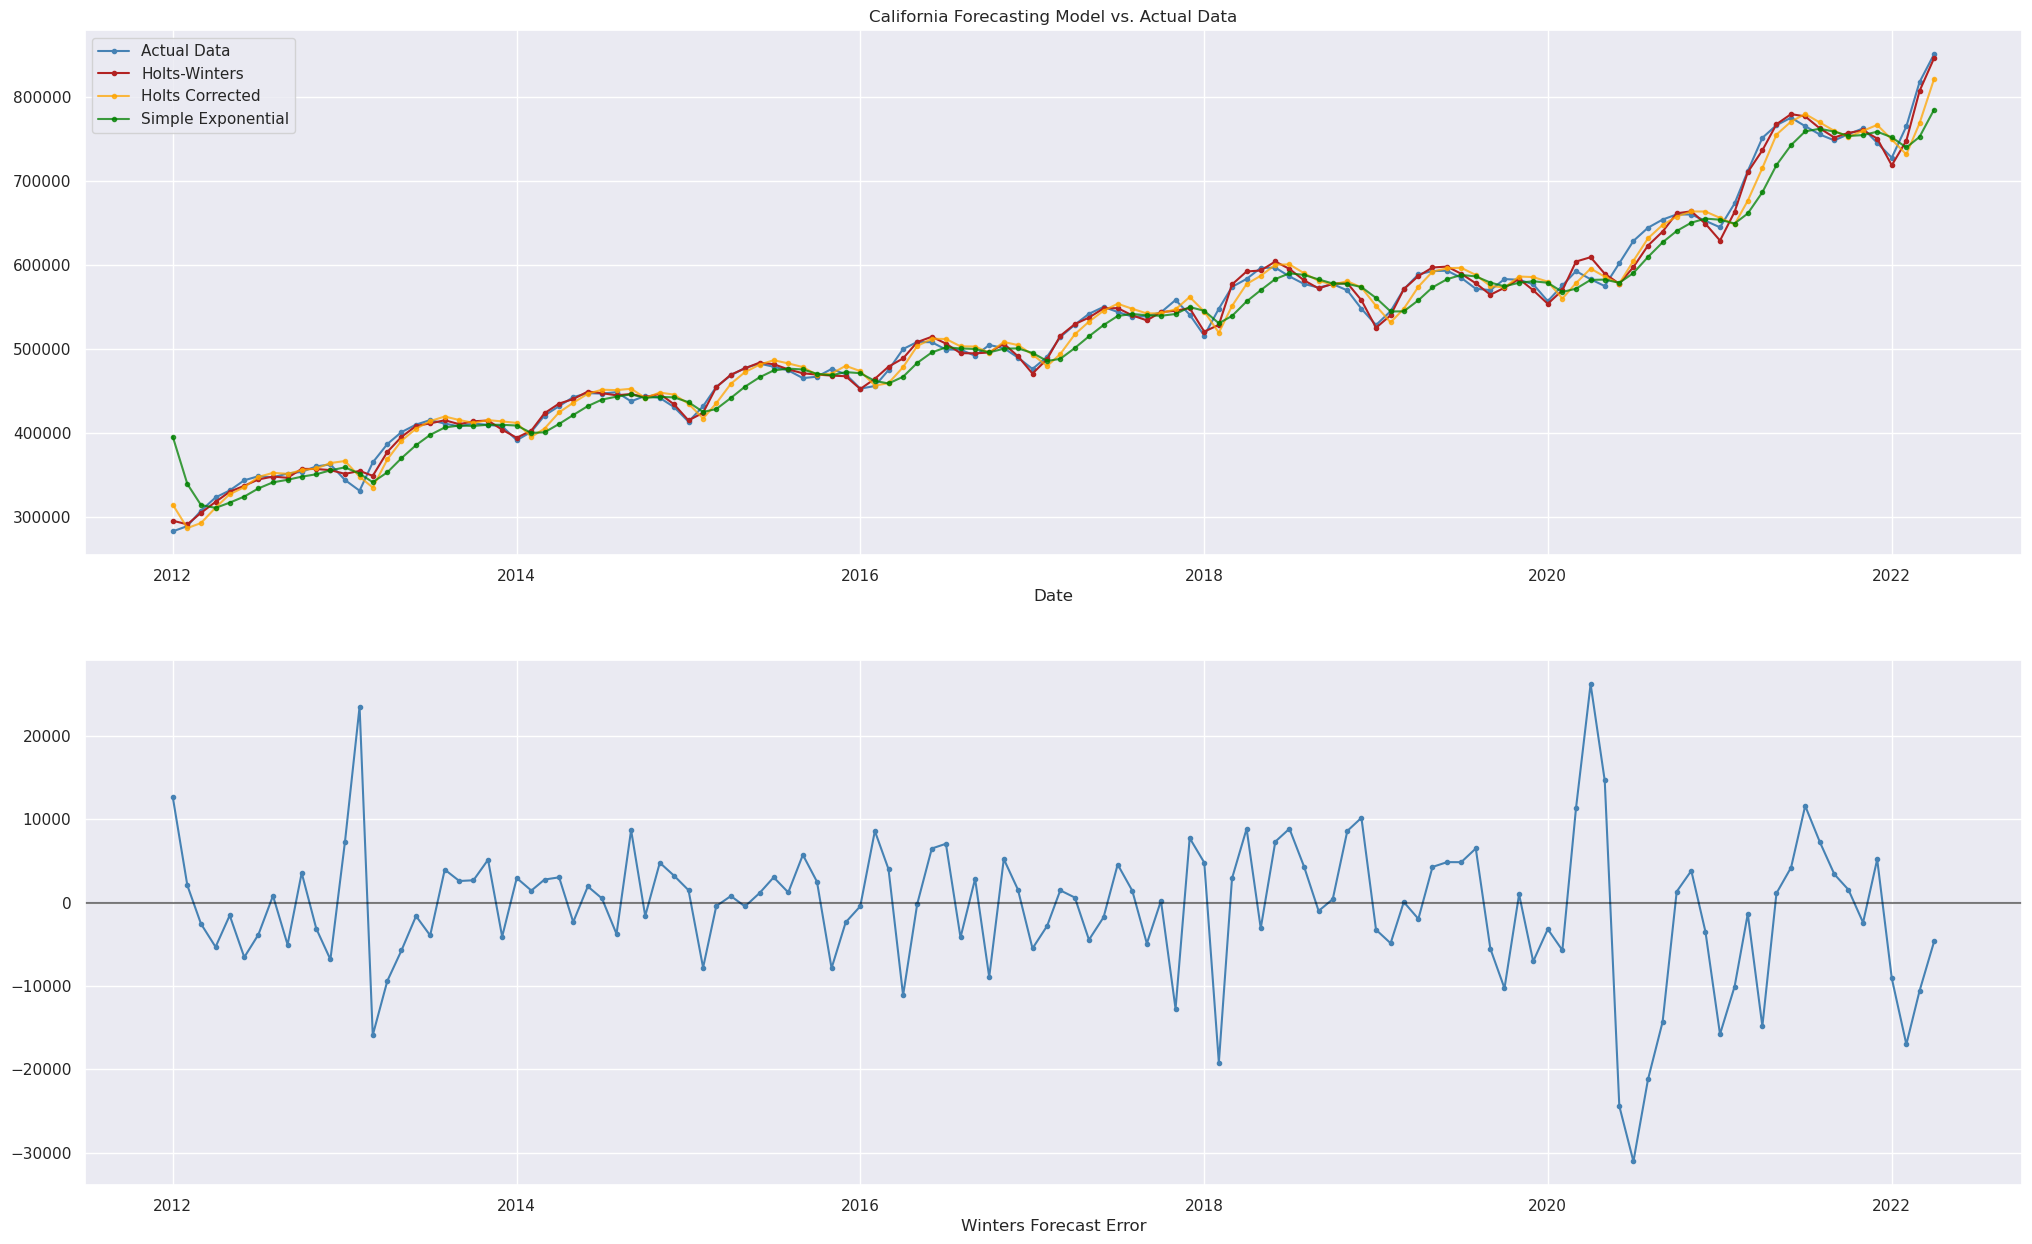

In [120]:
figure = plt.figure(figsize=(25, 15))

axes = figure.add_subplot(2, 1, 1)

axes.plot( CA_df.period_begin, CA_df.median_sale_price, color="steelblue", marker=".")
axes.plot( CA_df.period_begin, CA_winters, color="firebrick", marker=".")
axes.plot( CA_df.period_begin, CA_holts, color="orange", alpha=0.75, marker=".")
axes.plot( CA_df.period_begin, CA_ses[0][3], color="green", alpha=0.75, marker=".")
axes.set_xlabel( "Date")
axes.set_title("California Forecasting Model vs. Actual Data")
axes.legend(['Actual Data', 'Holts-Winters', 'Holts Corrected', 'Simple Exponential'])

axes = figure.add_subplot(2, 1, 2)

axes.plot( CA_df.period_begin, CA_winters - CA_df.median_sale_price, color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Winters Forecast Error")

plt.show()

Visually, Holts-Winter follows the actual data the closest compared to the previous two models. We can use Sum Squared Error as the error metric in order to compare the accuracy of each model as follows:

In [121]:
ses_sse = ((CA_ses[0][3] - CA[0][1].median_sale_price) ** 2).sum()
holts_sse = ((CA_holts - CA[0][1].median_sale_price) ** 2).sum()
winters_sse = ((CA_winters - CA[0][1].median_sale_price) ** 2).sum()

sse = pd.DataFrame([ses_sse, holts_sse, winters_sse], columns = ["Sum Squared Error"], index=["SES", "Holts", "Winters"])

sse

Sum Squared Error
SES         66866582732.25
Holts       28042823687.06
Winters      8345146341.45

Overall, the Holt's Winter model is the most accurate in regards to the actual data. Therefore, incorporating level, trend, and seasonality yields an ideal forecasting model for California's time series data. We can formulate predictions for comparison as follows:

In [122]:
def winters_predict(level, trend, factor, time_points):
    result = []
    for i in range(0, len(time_points)):
        n = len(level) - 1                           # index of last time point in data
        dis = time_points[i] - n
        predict = (level[n] + dis * trend[n]) * factor[(n+1) - 12]
        result.append(predict) 
    return result

In [123]:
time_index = [124, 125, 126, 127]

CA_winters_predict = pd.DataFrame([winters_predict(CA_levels, CA_trends, CA_factors, time_index)],
                                   columns = ["(winters) 2022-05-01", "(winters) 2022-06-01", "(winters) 2022-07-01", "(winters) 2022-08-01"])

CA_predict_compare = pd.concat([CA_predict_compare, CA_winters_predict], axis=1)

print(tabulate(CA_predict_compare.T[1:], headers = ['date','median sale price'], tablefmt = 'fancy_grid'))

╒══════════════════════╤═════════════════════╕
│ date                 │   median sale price │
╞══════════════════════╪═════════════════════╡
│ 2022-04-01           │              850700 │
├──────────────────────┼─────────────────────┤
│ (SES) 2022-05-01     │              817753 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-05-01   │              855161 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-06-01   │              859916 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-07-01   │              864670 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-08-01   │              869425 │
├──────────────────────┼─────────────────────┤
│ (winters) 2022-05-01 │              868884 │
├──────────────────────┼─────────────────────┤
│ (winters) 2022-06-01 │              878193 │
├──────────────────────┼─────────────────────┤
│ (winters) 2022-07-01 │              887502 │
├──────────────────────┼─────────────────────┤
│ (winters) 2

The Holt's-Winters model predicts greater future median sale prices compared to both SES and Holt's Trend Corrected. This makes sense when we remember that these periods of the year had higher sale prices compared to the months with auto-correlations (around the end of the year). Therefore, the Holt's-Winters model is superior to both of the previous models and incorporating seasonality benefitted forecasting for California's time series data. 

In [124]:

TX_initial_seasonal_factors, TX_seasonal_factors, TX_deseasonalized_data = seasonal_adjustment(TX[0][1].median_sale_price)

TX_result = pd.concat([TX_seasonal_factors, TX_deseasonalized_data], axis=1)
TX_result.columns = ["seasonal factors", "deseasonalized"]
TX_df = pd.concat([TX[0][1], TX_result], axis=1)
TX_df

period_begin  median_sale_price    t  seasonal factors  deseasonalized
0     2012-01-01          142300.00    1              0.93       152701.55
1     2012-02-01          151400.00    2              0.97       156112.43
2     2012-03-01          161300.00    3              1.00       161596.60
3     2012-04-01          162700.00    4              1.01       160502.71
4     2012-05-01          168900.00    5              1.04       162934.81
5     2012-06-01          173400.00    6              1.05       164848.14
6     2012-07-01          170400.00    7              1.03       164926.09
7     2012-08-01          167700.00    8              1.02       164989.66
8     2012-09-01          163300.00    9              0.99       165517.87
9     2012-10-01          161800.00   10              0.98       165688.50
10    2012-11-01          164400.00   11              0.98       168290.84
11    2012-12-01          169500.00   12              1.00       169839.79
12    2013-01-01          155600.00   13              0.93       166973.73
13    2013-02-01          162900.00   14              0.97       167970.37
14    2013-03-01          174400.00   15              1.00       174720.69
15    2013-04-01          182900.00   16              1.01       180429.90
16    2013-05-01          187000.00   17              1.04       180395.56
17    2013-06-01          191400.00   18              1.05       181960.40
18    2013-07-01          189000.00   19              1.03       182928.59
19    2013-08-01          186300.00   20              1.02       183289.05
20    2013-09-01          181200.00   21              0.99       183660.98
21    2013-10-01          178000.00   22              0.98       182277.83
22    2013-11-01          179600.00   23              0.98       183850.57
23    2013-12-01          185500.00   24              1.00       185871.87
24    2014-01-01          171100.00   25              0.93       183606.71
25    2014-02-01          184200.00   26              0.97       189933.35
26    2014-03-01          189300.00   27              1.00       189648.09
27    2014-04-01          191600.00   28              1.01       189012.41
28    2014-05-01          197900.00   29              1.04       190910.59
29    2014-06-01          204600.00   30              1.05       194509.39
30    2014-07-01          201200.00   31              1.03       194736.68
31    2014-08-01          199600.00   32              1.02       196374.10
32    2014-09-01          193800.00   33              0.99       196432.11
33    2014-10-01          192000.00   34              0.98       196614.28
34    2014-11-01          194600.00   35              0.98       199205.58
35    2014-12-01          202700.00   36              1.00       203106.35
36    2015-01-01          189500.00   37              0.93       203351.68
37    2015-02-01          198000.00   38              0.97       204162.88
38    2015-03-01          204500.00   39              1.00       204876.04
39    2015-04-01          208700.00   40              1.01       205881.47
40    2015-05-01          218600.00   41              1.04       210879.51
41    2015-06-01          220400.00   42              1.05       209530.16
42    2015-07-01          215100.00   43              1.03       208190.15
43    2015-08-01          213000.00   44              1.02       209557.53
44    2015-09-01          206400.00   45              0.99       209203.23
45    2015-10-01          205300.00   46              0.98       210233.92
46    2015-11-01          205400.00   47              0.98       210261.18
47    2015-12-01          214400.00   48              1.00       214829.80
48    2016-01-01          201600.00   49              0.93       216336.14
49    2016-02-01          207100.00   50              0.97       213546.13
50    2016-03-01          215900.00   51              1.00       216297.00
51    2016-04-01          220700.00   52              1.01       217719.41
52    2016-05-01          229

We can plot the raw time series data with the de-seasonalized data for comparison:

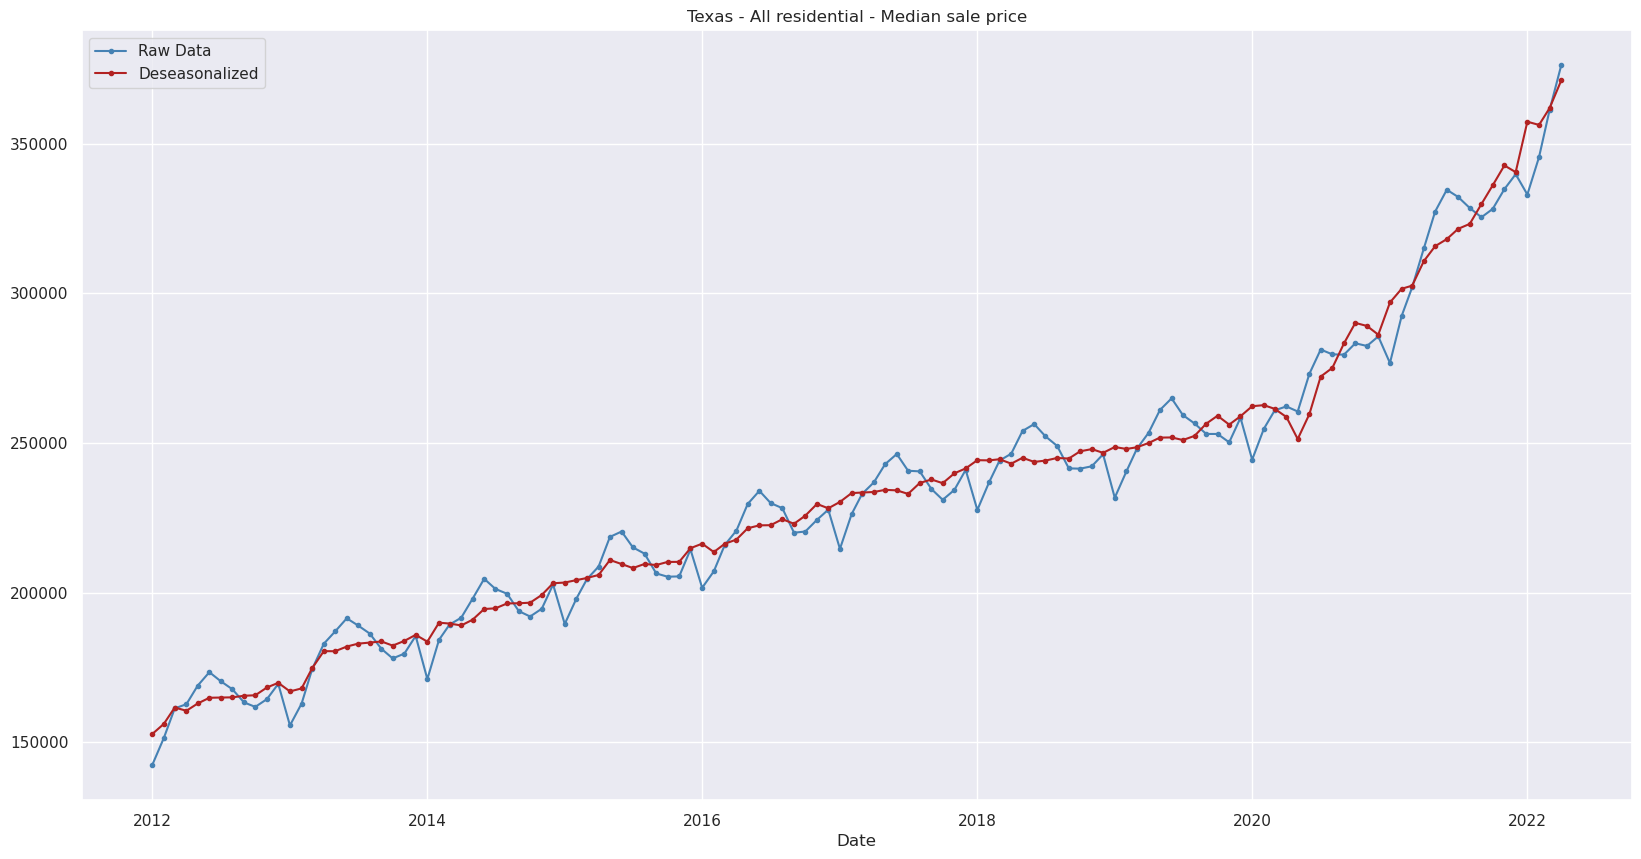

In [125]:
figure = plt.figure(figsize=(20, 10))
axes = figure.add_subplot(1, 1, 1)
axes.plot( TX_df.period_begin, TX_df.median_sale_price, color="steelblue", marker=".")
axes.plot( TX_df.period_begin, TX_df.deseasonalized, color="firebrick", marker=".")
axes.set_title( "Texas - All residential - Median sale price")
axes.set_xlabel("Date")
axes.legend(["Raw Data", "Deseasonalized"])

plt.show()

The seasonality in the actual data is even more apparent when we compare it to the de-seasonalized data. Now we determine the level and trend based on the deseasonalized data:

In [126]:
describe_fit( lm( "deseasonalized ~ t", data=TX_df), return_coefficient=False)

regression:  deseasonalized ~ t
n:  124
--------------------------------
intercept:  149961.23663046895
t:  1334.0045295252637
--------------------------------
sigma 14185.043942872475
R^2 0.9201102776975078


Based on these results, we have the following for the Holt's-Winter model: 
- $level_{0} = \$149,961.24$
- $trend_{0} = \$1,334.01$

However, for consistency with the previous models, we will estimate the level and trend using the initial third of values. 

In [127]:
TX_beta = describe_fit( lm( "deseasonalized ~ t", data=TX_df.iloc[0:42]))

regression:  deseasonalized ~ t
n:  42
--------------------------------
intercept:  154861.62426728435
t:  1296.635287075603
--------------------------------
sigma 2237.4717623565666
R^2 0.9810627944195774


Based on these results, we have the following for the Holt's-Winter model: 
- $level_{0} = \$154,861.62$
- $trend_{0} = \$1,296.64$

We can perform the initial grid search as follows:

In [128]:
values = [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

TX_grid, TX_alpha, TX_gamma= grid_search_winters(TX_beta[0], TX_beta[1], TX_df.median_sale_price, TX_initial_seasonal_factors, values=values)
print(f"Alpha: {TX_alpha} \
        Gamma: {TX_gamma} ")

TX_grid

Alpha: 0.9         Gamma: 0.1 


0.10          0.20          0.30          0.40          0.50          0.60          0.70          0.80          0.90
0.10 7843667163.34 4175729771.71 2774941751.25 2315509536.02 2218136526.29 2267492819.54 2378864714.50 2542867433.14 2776836540.92
0.20 2835128508.97 1937744281.79 1814729643.49 1886425278.64 2004571616.68 2105980158.36 2176420824.35 2239730154.62 2319831458.16
0.30 1881532049.96 1584445073.89 1608228988.21 1684601791.20 1763682508.45 1846369690.44 1936492167.88 2028910790.59 2114865712.53
0.40 1544294331.43 1428314099.40 1476565468.53 1549160006.98 1626361602.34 1703682327.87 1776849962.71 1843884832.76 1905555563.56
0.50 1378459478.60 1335885343.05 1391925281.12 1461680487.85 1531754959.95 1598127400.87 1659376660.47 1715419970.53 1766408211.89
0.60 1285397568.64 1279908680.50 1339571060.25 1406915754.15 1472659016.00 1534667363.06 1592864196.41 1648064471.06 1701631358.85
0.70 1233628949.57 1250951171.97 1314551113.74 1383233347.81 1450947293.75 1517213067.85 1583186208.15 1650703273.60 1721861403.76
0.80 1210483102.99 1245226246.91 1315477730.40 1390809809.17 1467702566.74 1546982060.91 1630631484.79 1720939365.60 1820136185.92
0.90 1210009851.61 1260958435.78 1341678075.08 1429319194.48 1522270834.16 1622262390.90 1731750160.31 1853245516.25 1989100924.06

Now that we have narrowed down what $\alpha$ and $\gamma$ should be via the initial grid search, we can do a higher granularity grid search as follows:

In [129]:
values = [[0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99],
          [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]]

TX_grid, TX_alpha, TX_gamma= grid_search_winters(TX_beta[0], TX_beta[1], TX_df.median_sale_price, TX_initial_seasonal_factors, values=values)
print(f"Alpha: {TX_alpha} \
        Gamma: {TX_gamma} ")

TX_grid

Alpha: 0.85         Gamma: 0.1 


0.01          0.02          0.03          0.04          0.05          0.06          0.07          0.08          0.09          0.10          0.11          0.12          0.13  \
0.81 1379589021.25 1342027209.45 1307639083.01 1278938608.58 1256261804.66 1239072699.58 1226567170.23 1217931472.15 1212440019.80 1209481725.34 1208556659.43 1209262038.37 1211275860.89   
0.82 1372876975.41 1336316984.61 1302904077.00 1275079314.25 1253158531.98 1236609490.42 1224641138.48 1216455245.69 1211341157.02 1208700980.09 1208045963.72 1208982579.94 1211196396.64   
0.83 1366549381.34 1330963101.31 1298496859.66 1271521770.35 1250334582.71 1234406952.86 1222960644.84 1215212527.69 1210466432.66 1208137246.33 1207747028.97 1208911196.13 1211322624.19   
0.84 1360593848.30 1325954457.41 1294407705.27 1268257564.65 1247782728.51 1232458892.46 1221520381.46 1214198762.58 1209811925.86 1207787137.31 1207656917.60 1209045327.43 1211652302.88   
0.85 1354998690.04 1321280593.77 1290627461.11 1265278788.39 1245496180.23 1230759496.71 1220315372.62 1213409684.28 1209373968.95 1207647488.76 1207772888.65 1209382589.20 1212183348.63   
0.86 1349752881.75 1316931654.83 1287147512.39 1262578005.90 1243468561.90 1229303313.12 1219340956.43 1212841300.99 1209149135.06 1207715348.96 1208092389.94 1209920765.65 1212913829.46   
0.87 1344846020.62 1312898352.70 1283959750.60 1260148227.20 1241693887.48 1228085229.65 1218592768.64 1212489881.99 1209134227.46 1207987970.32 1208613051.63 1210657805.08 1213841962.29   
0.88 1340268290.00 1309171934.44 1281056544.66 1257982883.24 1240166539.90 1227100457.31 1218066728.37 1212351946.15 1209326270.50 1208462802.45 1209332681.15 1211591816.50 1214966110.95   
0.89 1336010426.56 1305744152.46 1278430714.96 1256075803.69 1238881252.47 1226344514.87 1217759025.75 1212424252.13 1209722502.10 1209137486.62 1210249259.43 1212721067.37 1216284785.38   
0.90 1332063690.52 1302607237.55 1276075509.96 1254421197.01 1237833092.36 1225813215.37 1217666111.18 1212703790.15 1210320367.68 1210009851.61 1211360938.38 1214043982.61 1217796641.97   
0.91 1328419838.56 1299753874.63 1273984585.10 1253013632.83 1237017446.03 1225502654.51 1217784686.37 1213187775.25 1211117515.44 1211077910.80 1212666039.62 1215559144.77 1219500484.95   
0.92 1325071099.26 1297177180.79 1272151984.02 1251848026.18 1236430006.56 1225409200.68 1218111696.73 1213873641.93 1212111792.94 1212339860.48 1214163054.34 1217265295.26 1221395269.02   
0.93 1322010150.94 1294870685.68 1270572121.79 1250919623.77 1236066762.69 1225529486.57 1218644325.42 1214759040.25 1213301245.07 1213794079.42 1215850644.37 1219161336.77 1223480102.94   
0.94 1319230101.73 1292828313.94 1269239770.17 1250223992.01 1235923989.52 1225860402.33 1219379988.66 1215841833.12 1214684113.09 1215439129.60 1217727644.31 1221246336.78 1225754254.29   
0.95 1316724471.66 1291044369.63 1268150044.64 1249757006.74 1235998240.77 1226399090.20 1220316332.43 1217120094.91 1216258834.98 1217273758.05 1219793064.86 1223519532.17 1228217155.34   
0.96 1314487176.81 1289513522.50 1267298393.24 1249514844.59 1236286342.55 1227142940.45 1221451230.52 1218592111.32 1218024046.98 1219296899.91 1222046097.23 1225980334.93 1230868409.96   
0.97 1312512515.20 1288230796.10 1266680587.02 1249493975.84 1236785388.55 1228089588.72 1222782783.78 1220256380.45 1219978586.21 1221507682.57 1224486118.65 1228628339.01 1233707801.71   
0.98 1310795154.55 1287191557.51 1266292712.10 1249691158.84 1237492736.65 1229236914.71 1224309320.67 1222111614.98 1222121494.50 1223905430.93 1227112699.09 1231463328.26 1236735303.07   
0.99 1309330121.67 1286391508.67 1266131163.22 1250103435.79 1238406006.83 1230583042.04 1226029398.98 1224156745.64 1224452023.42 1226489673.90 1229925609.02 1234485285.60 1239951085.83   

              0.14          0.15          0.16          0.17          0.18          0.19  
0.81 1214341577.03 1218254933.19 1222853164.89 1228006323.39 1233610402.82 1239581929.40  
0.82 1214437014.19 1218505162.9

We can generate the holt's-winters results and plot the results as follows:

In [130]:

TX_winters, TX_levels, TX_trends, TX_factors = holt_winters_forecast(TX_beta[0], TX_beta[1], TX_alpha, TX_gamma, 0.0, 
                                                                     TX_df.median_sale_price, TX_initial_seasonal_factors)

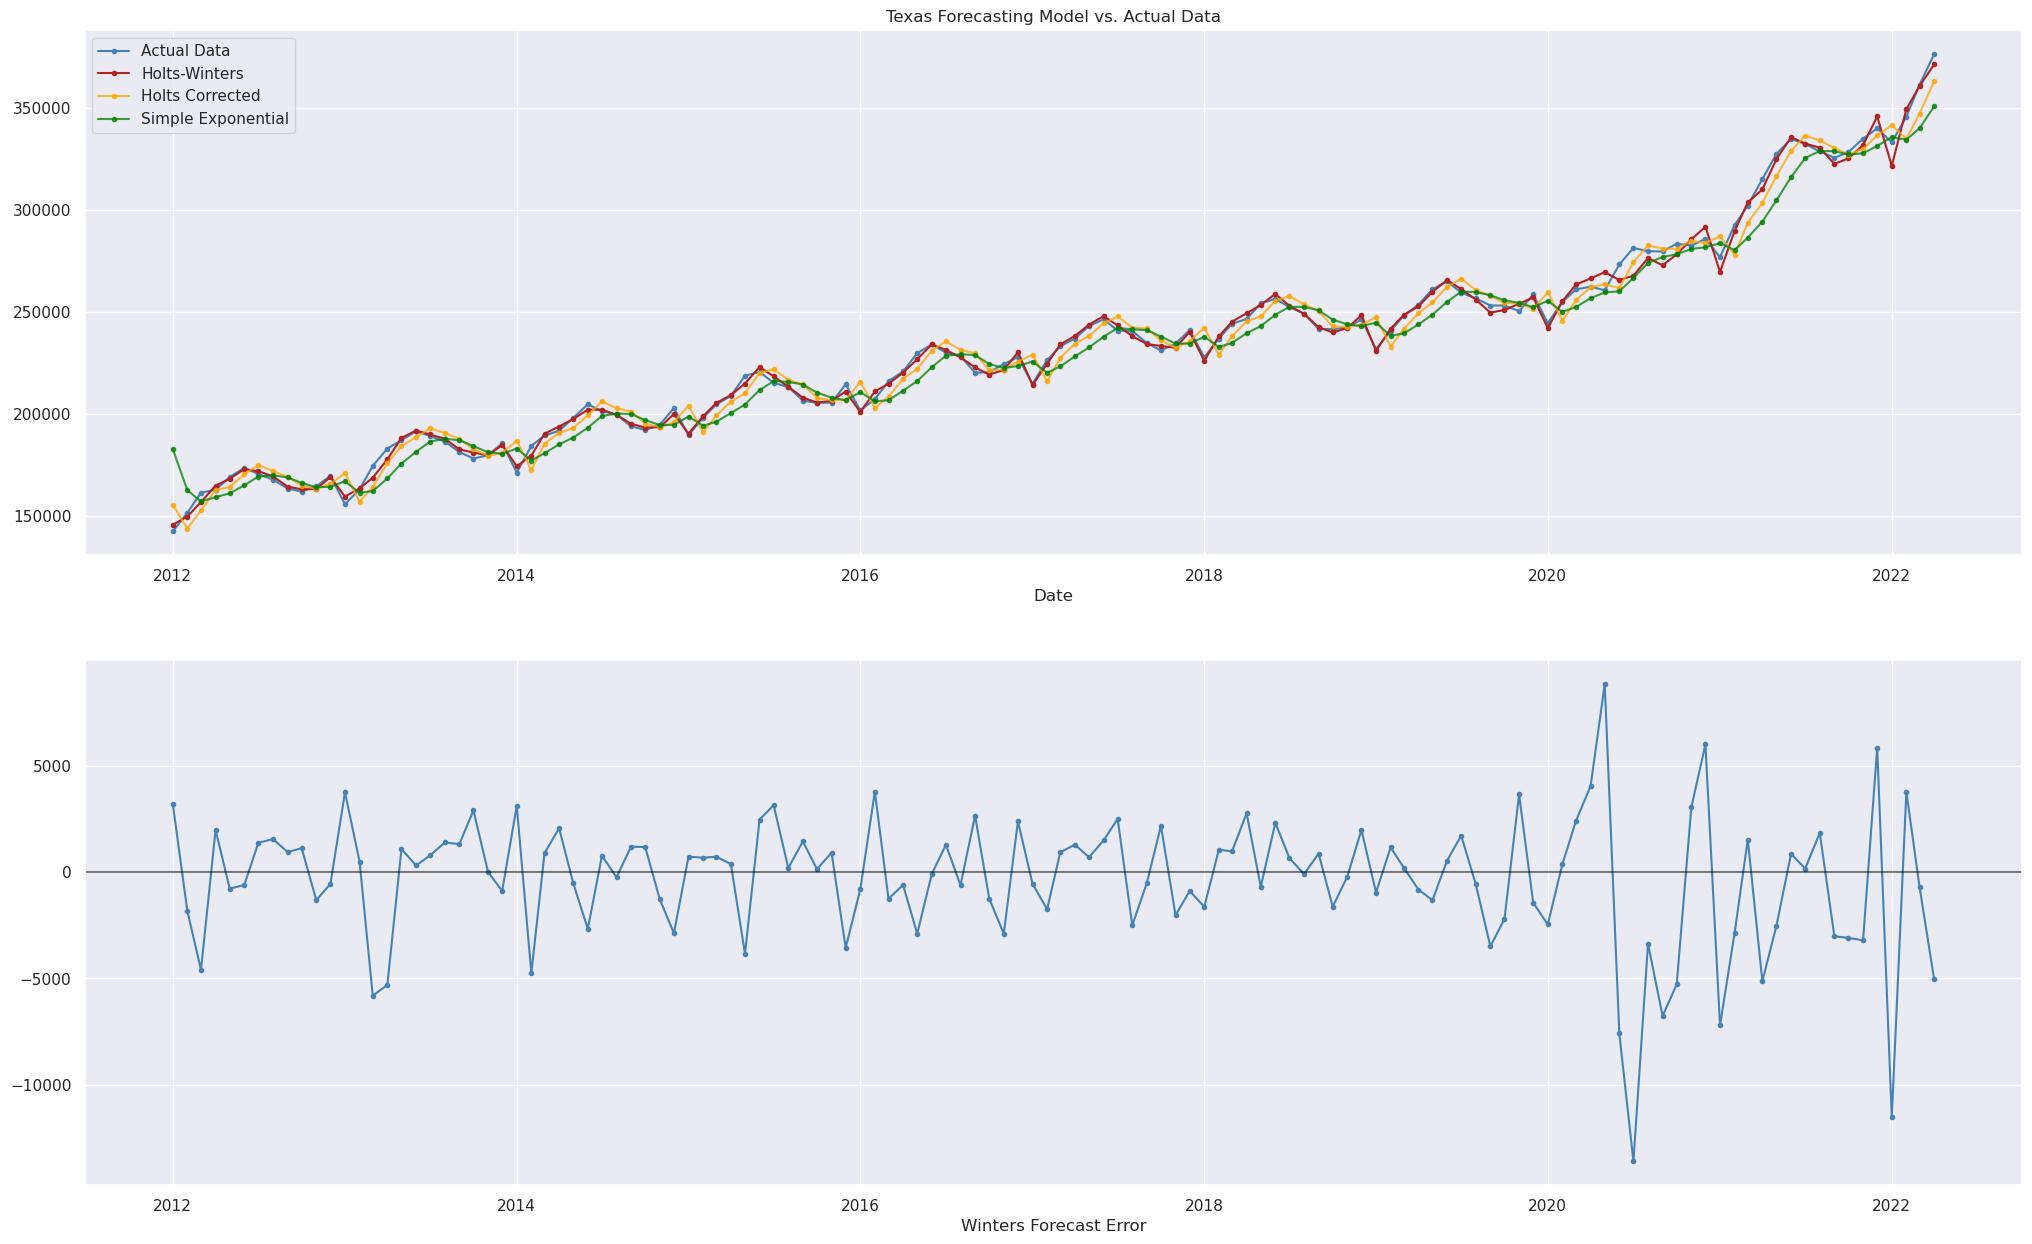

In [131]:
figure = plt.figure(figsize=(25, 15))

axes = figure.add_subplot(2, 1, 1)

axes.plot( TX_df.period_begin, TX_df.median_sale_price, color="steelblue", marker=".")
axes.plot( TX_df.period_begin, TX_winters, color="firebrick", marker=".")
axes.plot( TX_df.period_begin, TX_holts, color="orange", alpha=0.75, marker=".")
axes.plot( TX_df.period_begin, TX_ses[0][3], color="green", alpha=0.75, marker=".")
axes.set_xlabel( "Date")
axes.set_title("Texas Forecasting Model vs. Actual Data")
axes.legend(['Actual Data', 'Holts-Winters', 'Holts Corrected', 'Simple Exponential'])

axes = figure.add_subplot(2, 1, 2)

axes.plot( TX_df.period_begin, TX_winters - TX_df.median_sale_price, color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Winters Forecast Error")

plt.show()

Visually, Holts-Winter follows the actual data the closest compared to the previous two models. Interestingly, both California and Texas have greater error in the most recent time points. The behavior of the market in the last two years has been volatile due to the pandemic, so it's interesting to see how those data points contradict the expected median sale prices based on trend and seasonality. We can use Sum Squared Error as the error metric in order to compare the accuracy of each model as follows:

In [132]:
ses_sse = ((TX_ses[0][3] -TX[0][1].median_sale_price) ** 2).sum()
holts_sse = ((TX_holts - TX[0][1].median_sale_price) ** 2).sum()
winters_sse = ((TX_winters - TX[0][1].median_sale_price) ** 2).sum()

sse = pd.DataFrame([ses_sse, holts_sse, winters_sse], columns = ["Sum Squared Error"], index=["SES", "Holts", "Winters"])

sse

Sum Squared Error
SES         10691016581.09
Holts        6146967339.91
Winters      1207647488.76

The Holt's Winter model is the most accurate in regards to the actual data. Therefore, incorporating level, trend, and seasonality yields an ideal forecasting model for Texas's time series data. We can formulate predictions for comparison as follows:

In [133]:
time_index = [124, 125, 126, 127]

TX_winters_predict = pd.DataFrame([winters_predict(TX_levels, TX_trends, TX_factors, time_index)],
                                   columns = ["(winters) 2022-05-01", "(winters) 2022-06-01", "(winters) 2022-07-01", "(winters) 2022-08-01"])

TX_predict_compare = pd.concat([TX_predict_compare, TX_winters_predict], axis=1)

print(tabulate(TX_predict_compare.T[1:], headers = ['date','median sale price'],  tablefmt = 'fancy_grid'))

╒══════════════════════╤═════════════════════╕
│ date                 │   median sale price │
╞══════════════════════╪═════════════════════╡
│ 2022-04-01           │              376200 │
├──────────────────────┼─────────────────────┤
│ (SES) 2022-05-01     │              363369 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-05-01   │              378001 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-06-01   │              379935 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-07-01   │              381869 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-08-01   │              383803 │
├──────────────────────┼─────────────────────┤
│ (winters) 2022-05-01 │              388922 │
├──────────────────────┼─────────────────────┤
│ (winters) 2022-06-01 │              393910 │
├──────────────────────┼─────────────────────┤
│ (winters) 2022-07-01 │              398898 │
├──────────────────────┼─────────────────────┤
│ (winters) 2

The Holt's-Winters model predicts greater future median sale prices compared to both SES and Holt's Trend Corrected. This makes sense when we remember that these periods of the year had higher sale prices compared to the months with auto-correlations (around the end of the year). Therefore, the Holt's-Winters model is superior to both of the previous models and incorporating seasonality benefitted forecasting for Texas's time series data. 

In [134]:

FL_initial_seasonal_factors, FL_seasonal_factors, FL_deseasonalized_data = seasonal_adjustment(FL[0][1].median_sale_price)

FL_result = pd.concat([FL_seasonal_factors, FL_deseasonalized_data], axis=1)
FL_result.columns = ["seasonal factors", "deseasonalized"]
FL_df = pd.concat([FL[0][1], FL_result], axis=1)
FL_df

period_begin  median_sale_price    t  seasonal factors  deseasonalized
0     2012-01-01          119200.00    1              0.96       123744.54
1     2012-02-01          121000.00    2              0.97       124996.72
2     2012-03-01          127500.00    3              1.00       127738.89
3     2012-04-01          133400.00    4              1.00       132774.65
4     2012-05-01          137400.00    5              1.02       134129.28
5     2012-06-01          141200.00    6              1.04       136313.53
6     2012-07-01          138100.00    7              1.02       135392.09
7     2012-08-01          137400.00    8              1.01       136158.47
8     2012-09-01          138700.00    9              1.00       139205.04
9     2012-10-01          136100.00   10              0.98       138913.62
10    2012-11-01          141500.00   11              0.98       143747.86
11    2012-12-01          147600.00   12              1.00       147230.47
12    2013-01-01          138500.00   13              0.96       143780.36
13    2013-02-01          142100.00   14              0.97       146793.67
14    2013-03-01          150900.00   15              1.00       151182.74
15    2013-04-01          155200.00   16              1.00       154472.46
16    2013-05-01          161400.00   17              1.02       157557.98
17    2013-06-01          166600.00   18              1.04       160834.52
18    2013-07-01          167500.00   19              1.02       164215.60
19    2013-08-01          168400.00   20              1.01       166878.35
20    2013-09-01          165000.00   21              1.00       165600.80
21    2013-10-01          161100.00   22              0.98       164430.45
22    2013-11-01          162400.00   23              0.98       164979.88
23    2013-12-01          169000.00   24              1.00       168576.89
24    2014-01-01          159200.00   25              0.96       165269.56
25    2014-02-01          158800.00   26              0.97       164045.29
26    2014-03-01          168000.00   27              1.00       168314.78
27    2014-04-01          169300.00   28              1.00       168506.36
28    2014-05-01          180300.00   29              1.02       176008.07
29    2014-06-01          183300.00   30              1.04       176956.59
30    2014-07-01          182500.00   31              1.02       178921.48
31    2014-08-01          178000.00   32              1.01       176391.61
32    2014-09-01          179700.00   33              1.00       180354.33
33    2014-10-01          176800.00   34              0.98       180455.02
34    2014-11-01          177500.00   35              0.98       180319.75
35    2014-12-01          184900.00   36              1.00       184437.08
36    2015-01-01          175700.00   37              0.96       182398.63
37    2015-02-01          178700.00   38              0.97       184602.60
38    2015-03-01          189300.00   39              1.00       189654.69
39    2015-04-01          192700.00   40              1.00       191796.66
40    2015-05-01          201800.00   41              1.02       196996.28
41    2015-06-01          201400.00   42              1.04       194430.21
42    2015-07-01          198300.00   43              1.02       194411.67
43    2015-08-01          195900.00   44              1.01       194129.87
44    2015-09-01          195100.00   45              1.00       195810.41
45    2015-10-01          192500.00   46              0.98       196479.59
46    2015-11-01          193600.00   47              0.98       196675.52
47    2015-12-01          200000.00   48              1.00       199499.28
48    2016-01-01          195000.00   49              0.96       202434.45
49    2016-02-01          196500.00   50              0.97       202990.55
50    2016-03-01          203000.00   51              1.00       203380.36
51    2016-04-01          208400.00   52              1.00       207423.06
52    2016-05-01          215

We can plot the raw time series data with the de-seasonalized data for comparison:

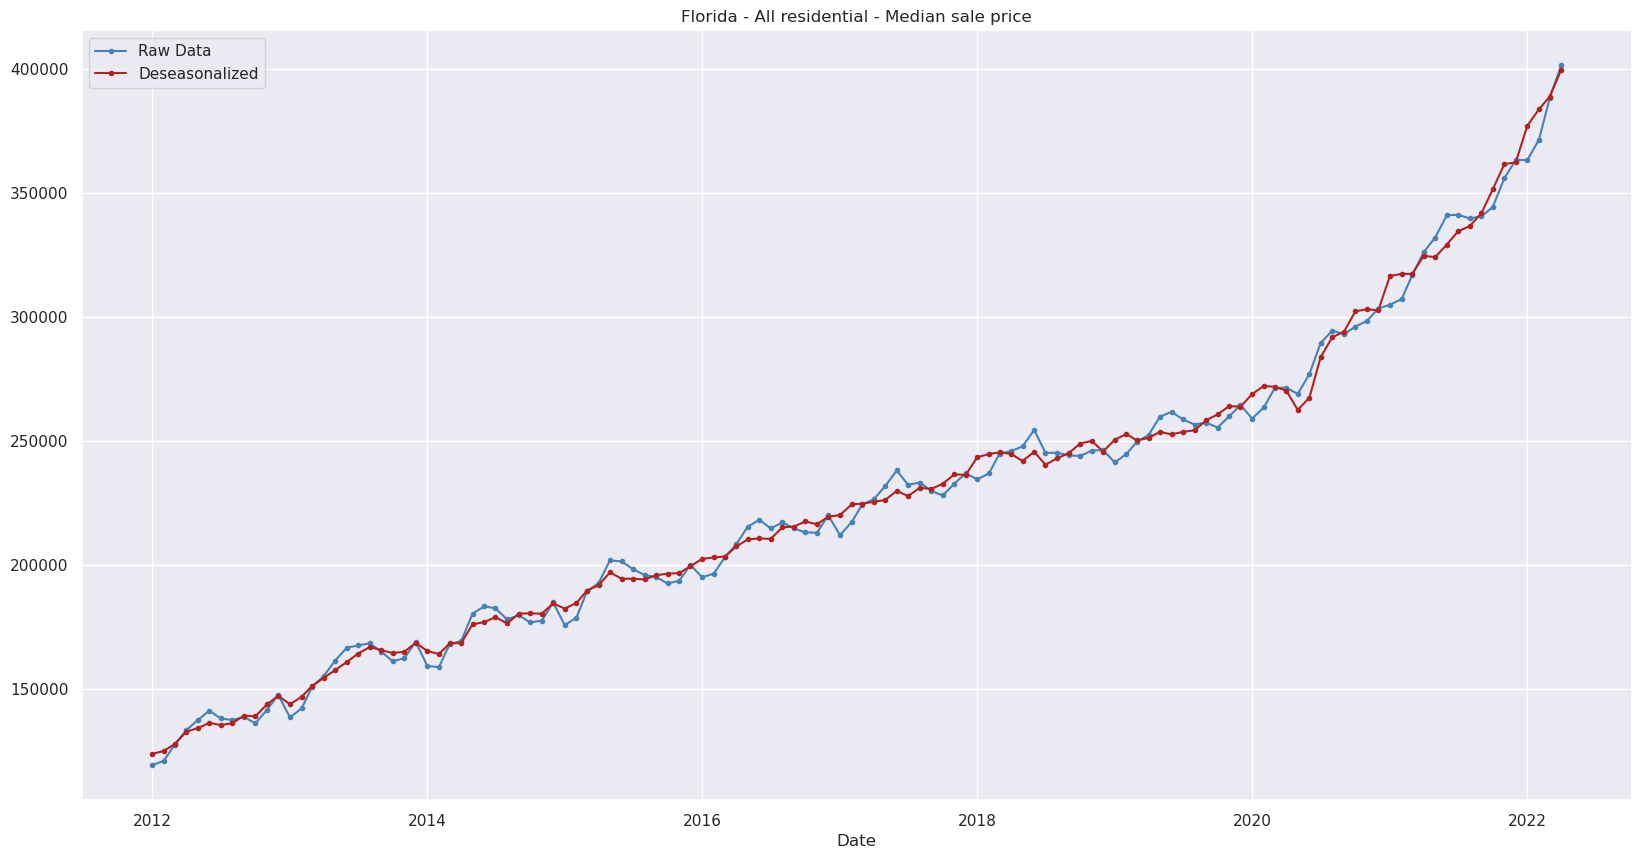

In [135]:
figure = plt.figure(figsize=(20, 10))
axes = figure.add_subplot(1, 1, 1)
axes.plot( FL_df.period_begin, FL_df.median_sale_price, color="steelblue", marker=".")
axes.plot( FL_df.period_begin, FL_df.deseasonalized, color="firebrick", marker=".")
axes.set_title( "Florida - All residential - Median sale price")
axes.set_xlabel("Date")
axes.legend(["Raw Data", "Deseasonalized"])

plt.show()

The seasonality in the actual data is even more apparent when we compare it to the de-seasonalized data. Now we determine the level and trend based on the deseasonalized data:

In [136]:
describe_fit( lm( "deseasonalized ~ t", data=FL_df), return_coefficient=False)

regression:  deseasonalized ~ t
n:  124
--------------------------------
intercept:  118854.3344762162
t:  1735.2409231655176
--------------------------------
sigma 15607.640306774574
R^2 0.941509681003564


Based on these results, we have the following for the Holt's-Winter model: 
- $level_{0} = \$118,854.33$
- $trend_{0} = \$1,735.24$

However, for consistency with the previous models, we will estimate the level and trend using the initial third of values. 

In [137]:
FL_beta = describe_fit( lm( "deseasonalized ~ t", data=FL_df.iloc[0:42]))

regression:  deseasonalized ~ t
n:  42
--------------------------------
intercept:  125408.65246318882
t:  1663.7258454835342
--------------------------------
sigma 3199.240826884198
R^2 0.9765910089050962


Based on these results, we have the following for the Holt's-Winter model: 
- $level_{0} = \$125,408.65$
- $trend_{0} = \$1,663.73$

We can perform the initial grid search as follows:

In [138]:
values = [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

FL_grid, FL_alpha, FL_gamma= grid_search_winters(FL_beta[0], FL_beta[1], FL_df.median_sale_price, FL_initial_seasonal_factors, values=values)
print(f"Alpha: {FL_alpha} \
        Gamma: {FL_gamma} ")

FL_grid

Alpha: 0.9         Gamma: 0.1 


0.10          0.20          0.30          0.40          0.50          0.60          0.70          0.80          0.90
0.10 9121736280.20 5104186476.95 3580385766.23 3172466150.90 3123630223.50 3212738652.41 3407444723.28 3667318892.55 3979546933.62
0.20 3644278736.32 2661004793.10 2581343352.30 2712273050.08 2882853597.67 3024808114.32 3130474644.09 3238747963.47 3381562397.22
0.30 2521279090.50 2193393449.80 2239949086.39 2339048775.36 2438296799.66 2539734767.18 2640336841.27 2723957893.68 2775333958.80
0.40 2058630866.32 1917684975.51 1969558450.92 2044944822.83 2118743477.02 2181621820.49 2228157021.06 2261276253.35 2289804382.17
0.50 1800519818.02 1734236023.21 1785063287.10 1848144926.72 1906652151.22 1957682863.27 2004283846.02 2051216718.67 2101546287.03
0.60 1643295567.88 1616925362.39 1669834877.20 1730937860.70 1790252277.72 1848016182.38 1906719781.70 1968209476.51 2033114102.89
0.70 1548452993.03 1549033618.70 1608068230.70 1674644577.36 1742493610.58 1812162521.75 1885030077.38 1961946028.95 2043289962.32
0.80 1497599932.60 1520185708.82 1589241309.05 1666710439.85 1748391613.11 1834945772.86 1927641158.19 2027701196.59 2136482808.08
0.90 1481262599.00 1524852252.79 1608302938.72 1702392133.11 1804548566.93 1916080501.45 2039067841.42 2175978012.06 2329761787.06

Now that we have narrowed down what $\alpha$ and $\gamma$ should be via the initial grid search, we can do a higher granularity grid search as follows:

In [139]:
values = [[0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99],
          [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]]

FL_grid, FL_alpha, FL_gamma= grid_search_winters(FL_beta[0], FL_beta[1], FL_df.median_sale_price, FL_initial_seasonal_factors, values=values)
print(f"Alpha: {FL_alpha} \
        Gamma: {FL_gamma} ")

FL_grid

Alpha: 0.89         Gamma: 0.11 


0.01          0.02          0.03          0.04          0.05          0.06          0.07          0.08          0.09          0.10          0.11          0.12          0.13  \
0.81 1740102514.58 1685702768.63 1637263211.17 1597243010.33 1565547438.70 1541177429.80 1522934491.46 1509693138.63 1500486968.98 1494519363.67 1491146783.07 1489854580.51 1490233129.30   
0.82 1729715957.60 1676673991.91 1629514833.27 1590621747.74 1559886856.12 1536323688.28 1518754781.53 1506076627.04 1497342840.27 1491773984.34 1488740835.95 1487740488.83 1488372860.88   
0.83 1719867420.37 1668145514.50 1622229968.46 1584431341.30 1554629550.99 1531850642.78 1514937691.07 1502808551.47 1494536254.17 1489358000.58 1486658414.37 1485945934.19 1486829693.84   
0.84 1710540604.71 1660102719.67 1615395726.52 1578660506.27 1549765659.20 1527749652.83 1511475617.60 1499882182.11 1492061210.99 1487266022.18 1484894636.85 1484466460.28 1485599528.29   
0.85 1701720142.56 1652531842.98 1608999984.90 1573298644.30 1545285929.91 1524012627.69 1508361454.41 1497291240.00 1489912124.99 1485493042.97 1483444981.95 1483297951.97 1484678591.06   
0.86 1693391540.75 1645419921.68 1603031343.39 1568335803.53 1541181690.47 1520631995.72 1505588563.84 1495029873.57 1488083803.64 1484034422.37 1482305271.79 1482436620.49 1484063422.06   
0.87 1685541130.00 1638754747.97 1597479082.34 1563762641.58 1537444814.13 1517600676.10 1503150752.59 1493092637.00 1486571428.59 1482885868.44 1481471656.91 1481878989.63 1483750861.73   
0.88 1678156017.67 1632524825.74 1592333123.98 1559570391.61 1534067690.22 1514912052.82 1501042248.92 1491474470.24 1485370538.03 1482043422.34 1480940602.31 1481621883.15 1483738039.49   
0.89 1671224043.91 1626719330.54 1587583996.72 1555750830.80 1531043196.66 1512559950.72 1499257681.78 1490170680.74 1484477010.63 1481503443.98 1480708874.63 1481662413.26 1484022363.24   
0.90 1664733741.19 1621328072.64 1583222802.25 1552296251.40 1528364674.65 1510538613.42 1497792061.57 1489176926.62 1483887050.74 1481262599.00 1480773530.58 1481997970.16 1484601509.87   
0.91 1658674296.77 1616341462.82 1579241185.07 1549199434.10 1526025905.45 1508842683.14 1496640762.59 1488489201.35 1483597175.00 1481317846.98 1481131906.40 1482626212.64 1485473416.78   
0.92 1653035518.00 1611750480.88 1575631304.56 1546453623.43 1524021089.01 1507467182.21 1495799507.01 1488103819.89 1483604200.21 1481666430.76 1481781608.55 1483545059.76 1486636274.36   
0.93 1647807800.23 1607546646.46 1572385809.12 1544052505.29 1522344824.50 1506407496.17 1495264350.29 1488017406.01 1483905232.42 1482305866.97 1482720505.31 1484752683.51 1488088519.57   
0.94 1642982097.21 1603721992.31 1569497812.58 1541990186.33 1520992092.46 1505659358.52 1495031668.08 1488226881.14 1484497657.24 1483233937.68 1483946719.67 1486247502.61 1489828830.49   
0.95 1638549893.77 1600269039.59 1566960872.44 1540261175.11 1519958238.67 1505218836.86 1495098144.43 1488729454.23 1485379131.31 1484448683.19 1485458623.09 1488028177.23 1491856121.89   
0.96 1634503180.67 1597180775.30 1564768970.10 1538860365.06 1519238959.54 1505082320.54 1495460761.34 1489522613.04 1486547574.97 1485948395.85 1487254830.52 1490093604.89 1494169541.86   
0.97 1630834431.51 1594450631.56 1562916492.76 1537783018.92 1518830288.96 1505246509.59 1496116789.56 1490604116.56 1488001166.05 1487731615.09 1489334196.33 1492442917.34 1496768469.51   
0.98 1627536581.57 1592072466.76 1561398217.09 1537024754.88 1518728586.65 1505708405.07 1497063780.67 1491971988.51 1489738334.74 1489797123.44 1491695811.41 1495075478.50 1499652513.75   
0.99 1624603008.52 1590040548.42 1560209294.49 1536581534.14 1518930527.85 1506465300.66 1498299560.36 1493624512.18 1491757759.68 1492143943.75 1494339001.39 1497990883.59 1502821513.16   

              0.14          0.15          0.16          0.17          0.18          0.19  
0.81 1491956936.28 1494767320.29 1498458431.97 1502866134.30 1507859228.59 1513332559.16  
0.82 1490320182.73 1493330010.3

We can generate the holt's-winters results and plot the results as follows:

In [140]:

FL_winters, FL_levels, FL_trends, FL_factors = holt_winters_forecast(FL_beta[0], FL_beta[1], FL_alpha, FL_gamma, 0.0, 
                                                                     FL_df.median_sale_price, FL_initial_seasonal_factors)

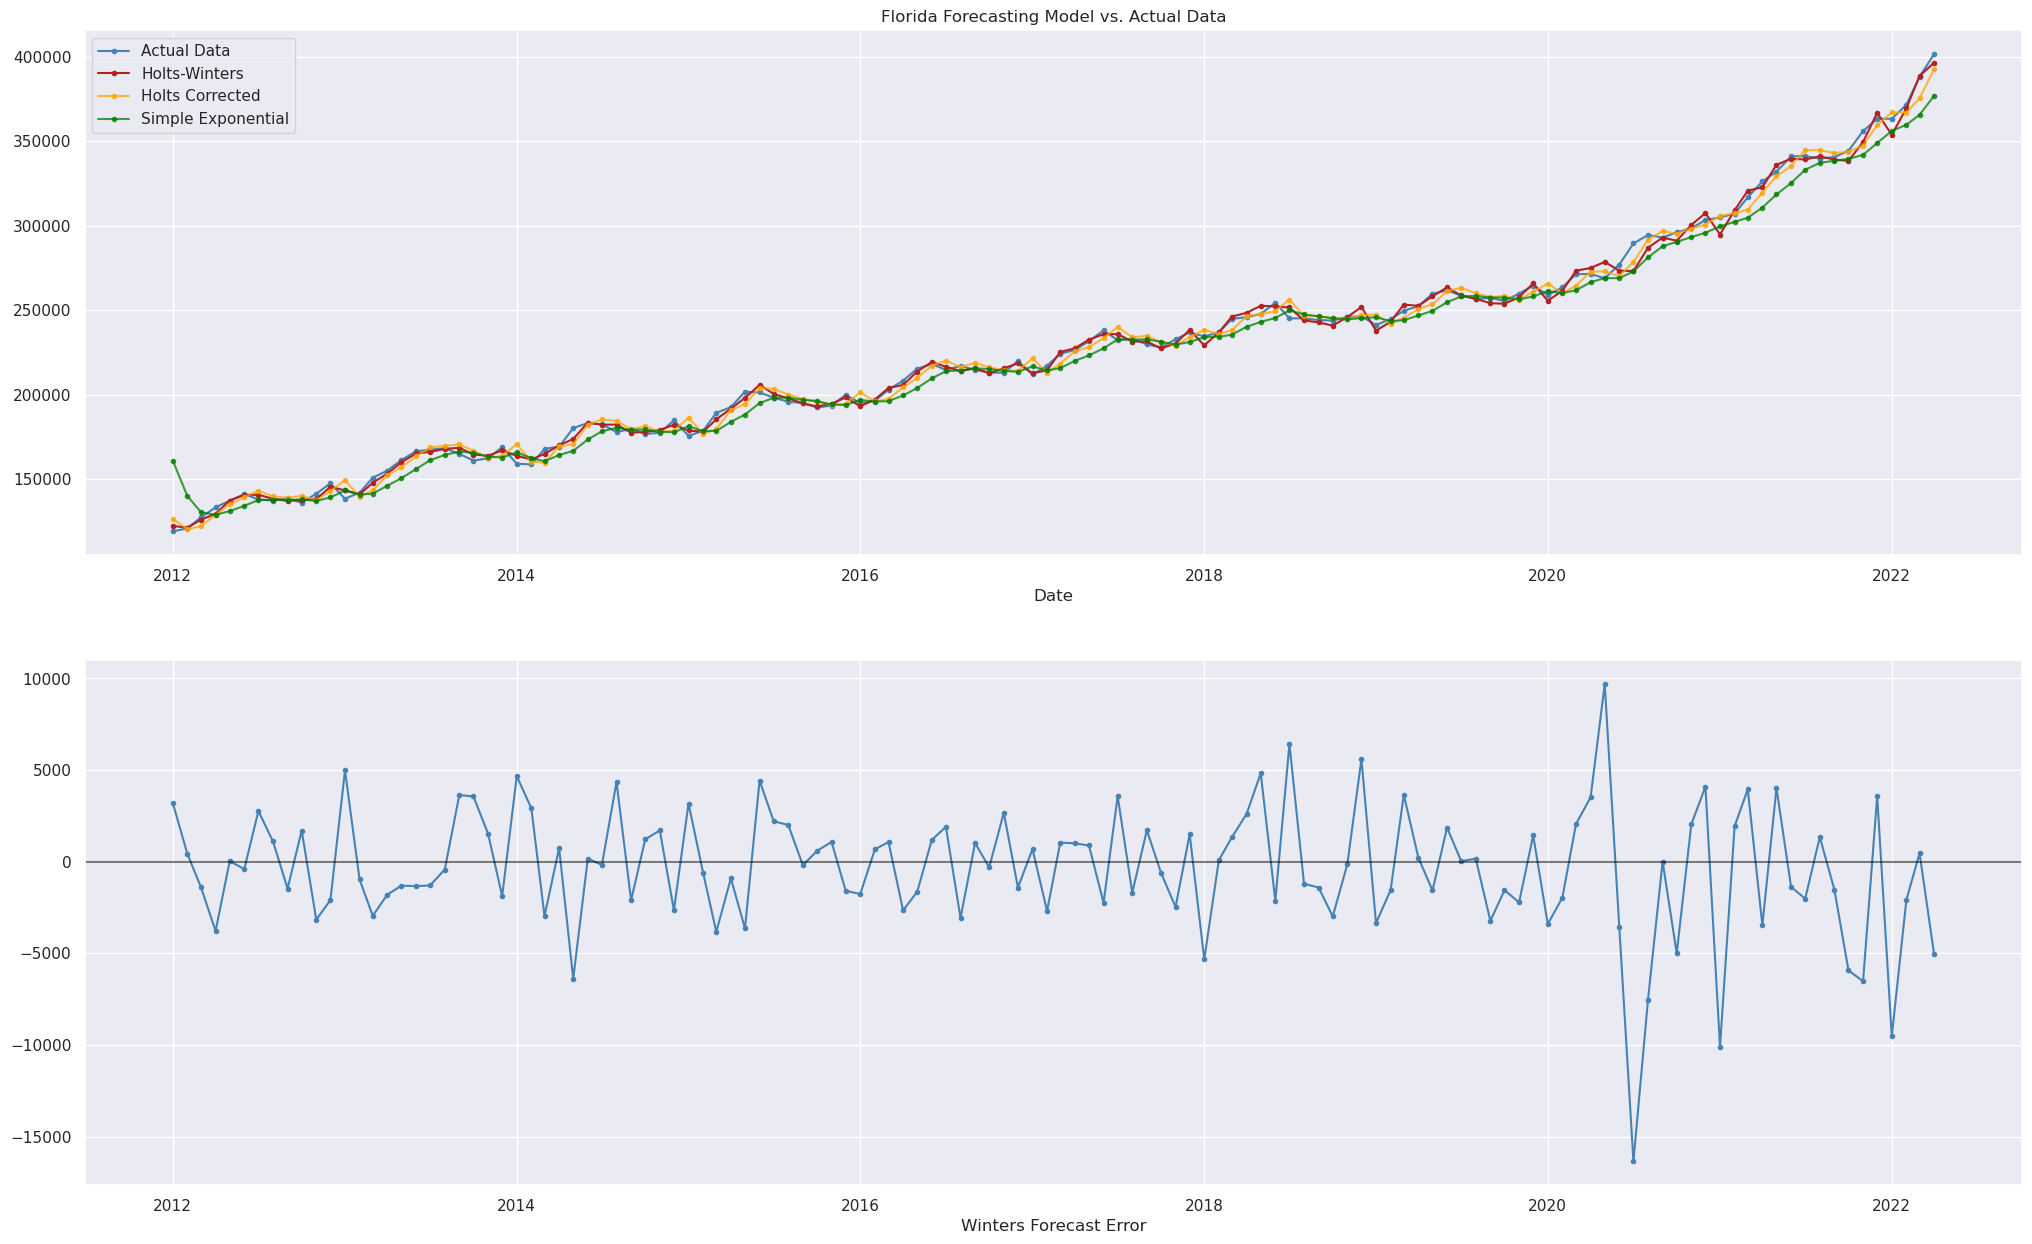

In [141]:
figure = plt.figure(figsize=(25, 15))

axes = figure.add_subplot(2, 1, 1)

axes.plot( FL_df.period_begin, FL_df.median_sale_price, color="steelblue", marker=".")
axes.plot( FL_df.period_begin, FL_winters, color="firebrick", marker=".")
axes.plot( FL_df.period_begin, FL_holts, color="orange", alpha=0.75, marker=".")
axes.plot( FL_df.period_begin, FL_ses[0][3], color="green", alpha=0.75, marker=".")
axes.set_xlabel( "Date")
axes.set_title("Florida Forecasting Model vs. Actual Data")
axes.legend(['Actual Data', 'Holts-Winters', 'Holts Corrected', 'Simple Exponential'])

axes = figure.add_subplot(2, 1, 2)

axes.plot( FL_df.period_begin, FL_winters - FL_df.median_sale_price, color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Winters Forecast Error")

plt.show()

Visually, Holts-Winter follows the actual data the closest compared to the previous two models. Again, we see the greatest error in the last two years where median sale prices were greatly affected by the pandemic. We can use Sum Squared Error as the error metric in order to compare the accuracy of each model as follows:

In [142]:
ses_sse = ((FL_ses[0][3] -FL[0][1].median_sale_price) ** 2).sum()
holts_sse = ((FL_holts - FL[0][1].median_sale_price) ** 2).sum()
winters_sse = ((FL_winters - FL[0][1].median_sale_price) ** 2).sum()

sse = pd.DataFrame([ses_sse, holts_sse, winters_sse], columns = ["Sum Squared Error"], index=["SES", "Holts", "Winters"])

sse

Sum Squared Error
SES          8657683106.25
Holts        3038186467.52
Winters      1480708874.63

The Holt's Winter model is the most accurate in regards to the actual data. Therefore, incorporating level, trend, and seasonality yields an ideal forecasting model for Florida's time series data. We can formulate predictions for comparison as follows:

In [143]:
time_index = [124, 125, 126, 127]

FL_winters_predict = pd.DataFrame([winters_predict(FL_levels, FL_trends, FL_factors, time_index)],
                                   columns = ["(winters) 2022-05-01", "(winters) 2022-06-01", "(winters) 2022-07-01", "(winters) 2022-08-01"])

FL_predict_compare = pd.concat([FL_predict_compare, FL_winters_predict], axis=1)

print(tabulate(FL_predict_compare.T[1:], headers = ['date','median sale price'],  tablefmt = 'fancy_grid'))

╒══════════════════════╤═════════════════════╕
│ date                 │   median sale price │
╞══════════════════════╪═════════════════════╡
│ 2022-04-01           │              401500 │
├──────────────────────┼─────────────────────┤
│ (SES) 2022-05-01     │              389174 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-05-01   │              406566 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-06-01   │              411721 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-07-01   │              416877 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-08-01   │              422032 │
├──────────────────────┼─────────────────────┤
│ (winters) 2022-05-01 │              415155 │
├──────────────────────┼─────────────────────┤
│ (winters) 2022-06-01 │              421513 │
├──────────────────────┼─────────────────────┤
│ (winters) 2022-07-01 │              427872 │
├──────────────────────┼─────────────────────┤
│ (winters) 2

The Holt's-Winters model predicts greater future median sale prices compared to both SES and Holt's Trend Corrected. This makes sense when we remember that these periods of the year had higher sale prices compared to the months with auto-correlations (around the end of the year). Therefore, the Holt's-Winters model is superior to both of the previous models and incorporating seasonality benefitted forecasting for Florida's time series data. 

In [144]:

DC_initial_seasonal_factors, DC_seasonal_factors, DC_deseasonalized_data = seasonal_adjustment(DC[0][1].median_sale_price)

DC_result = pd.concat([DC_seasonal_factors, DC_deseasonalized_data], axis=1)
DC_result.columns = ["seasonal factors", "deseasonalized"]
DC_df = pd.concat([DC[0][1], DC_result], axis=1)
DC_df

period_begin  median_sale_price    t  seasonal factors  deseasonalized
0     2012-01-01          353000.00    1              0.93       378639.06
1     2012-02-01          393500.00    2              0.97       405223.44
2     2012-03-01          396300.00    3              0.98       404343.03
3     2012-04-01          440000.00    4              1.00       438140.04
4     2012-05-01          434500.00    5              1.06       411787.94
5     2012-06-01          445000.00    6              1.06       420945.37
6     2012-07-01          444000.00    7              1.04       428087.18
7     2012-08-01          433300.00    8              0.99       436731.10
8     2012-09-01          420000.00    9              0.95       441009.39
9     2012-10-01          435000.00   10              1.00       436076.66
10    2012-11-01          442500.00   11              1.02       434497.60
11    2012-12-01          449000.00   12              1.00       447697.38
12    2013-01-01          420000.00   13              0.93       450505.40
13    2013-02-01          440000.00   14              0.97       453108.80
14    2013-03-01          456800.00   15              0.98       466070.89
15    2013-04-01          460000.00   16              1.00       458055.50
16    2013-05-01          480000.00   17              1.06       454909.57
17    2013-06-01          525000.00   18              1.06       496620.94
18    2013-07-01          515000.00   19              1.04       496542.56
19    2013-08-01          459000.00   20              0.99       462634.61
20    2013-09-01          447000.00   21              0.95       469360.00
21    2013-10-01          450000.00   22              1.00       451113.79
22    2013-11-01          491000.00   23              1.02       482120.50
23    2013-12-01          475000.00   24              1.00       473621.95
24    2014-01-01          440000.00   25              0.93       471958.04
25    2014-02-01          467500.00   26              0.97       481428.10
26    2014-03-01          473800.00   27              0.98       483415.91
27    2014-04-01          495000.00   28              1.00       492907.55
28    2014-05-01          525000.00   29              1.06       497557.35
29    2014-06-01          524500.00   30              1.06       496147.97
30    2014-07-01          525000.00   31              1.04       506184.17
31    2014-08-01          469000.00   32              0.99       472713.79
32    2014-09-01          465000.00   33              0.95       488260.40
33    2014-10-01          495000.00   34              1.00       496225.17
34    2014-11-01          500000.00   35              1.02       490957.74
35    2014-12-01          502000.00   36              1.00       500543.62
36    2015-01-01          484400.00   37              0.93       519582.90
37    2015-02-01          485400.00   38              0.97       499861.39
38    2015-03-01          500000.00   39              0.98       510147.65
39    2015-04-01          515000.00   40              1.00       512823.01
40    2015-05-01          550000.00   41              1.06       521250.55
41    2015-06-01          548000.00   42              1.06       518377.67
42    2015-07-01          542000.00   43              1.04       522574.89
43    2015-08-01          515000.00   44              0.99       519078.04
44    2015-09-01          515000.00   45              0.95       540761.52
45    2015-10-01          502800.00   46              1.00       504044.47
46    2015-11-01          539000.00   47              1.02       529252.44
47    2015-12-01          510000.00   48              1.00       508520.41
48    2016-01-01          490000.00   49              0.93       525589.64
49    2016-02-01          535000.00   50              0.97       550939.11
50    2016-03-01          491500.00   51              0.98       501475.14
51    2016-04-01          525000.00   52              1.00       522780.73
52    2016-05-01          572

We can plot the raw time series data with the de-seasonalized data for comparison:

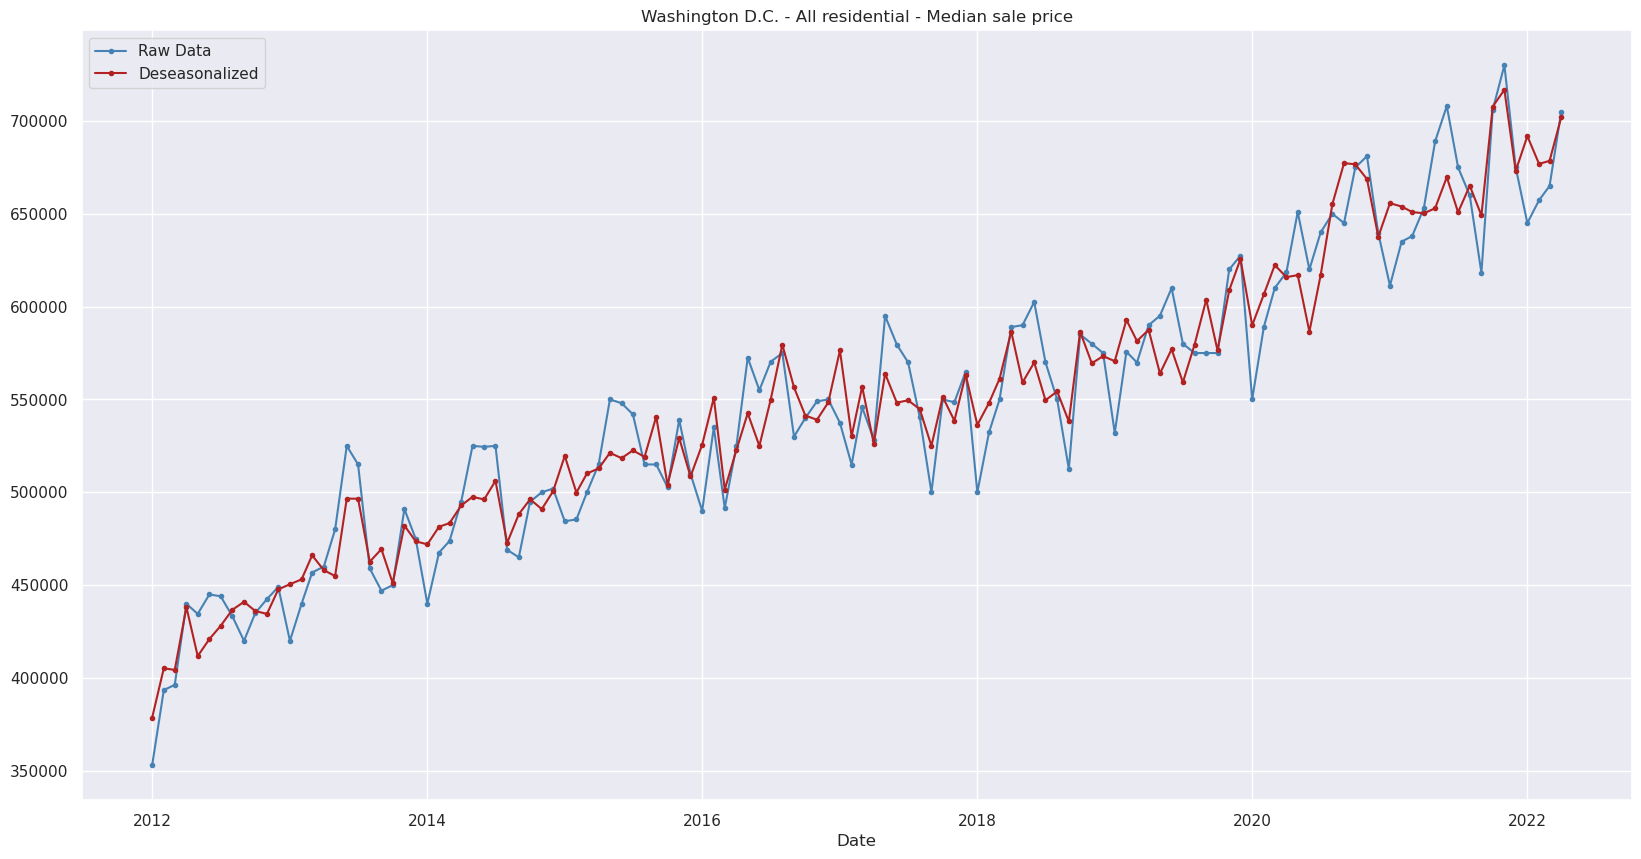

In [145]:
figure = plt.figure(figsize=(20, 10))
axes = figure.add_subplot(1, 1, 1)
axes.plot( DC_df.period_begin, DC_df.median_sale_price, color="steelblue", marker=".")
axes.plot( DC_df.period_begin, DC_df.deseasonalized, color="firebrick", marker=".")
axes.set_title( "Washington D.C. - All residential - Median sale price")
axes.set_xlabel("Date")
axes.legend(["Raw Data", "Deseasonalized"])

plt.show()

The seasonality in the actual data is somewhat apparent when we compare it to the de-seasonalized data, but the time series data associated with Washington D.C. has a higher degree of variation overall. Now we determine the level and trend based on the deseasonalized data:

In [146]:
describe_fit( lm( "deseasonalized ~ t", data=DC_df), return_coefficient=False)

regression:  deseasonalized ~ t
n:  124
--------------------------------
intercept:  420920.6690035113
t:  2028.580462555856
--------------------------------
sigma 20367.05080959155
R^2 0.928154993344689


Based on these results, we have the following for the Holt's-Winter model: 
- $level_{0} = \$420,920.67$
- $trend_{0} = \$2,028.58$

However, for consistency with the previous models, we will estimate the level and trend using the initial third of values. 

In [147]:
DC_beta = describe_fit( lm( "deseasonalized ~ t", data=DC_df.iloc[0:42]))

regression:  deseasonalized ~ t
n:  42
--------------------------------
intercept:  410779.48576629633
t:  2663.8397259009507
--------------------------------
sigma 13343.22544700644
R^2 0.8601065571383062


Based on these results, we have the following for the Holt's-Winter model: 
- $level_{0} = \$410,779.49$
- $trend_{0} = \$2,663.84$

We can perform the initial grid search as follows:

In [148]:
values = [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

DC_grid, DC_alpha, DC_gamma= grid_search_winters(DC_beta[0], DC_beta[1], DC_df.median_sale_price, DC_initial_seasonal_factors, values=values)
print(f"Alpha: {DC_alpha} \
        Gamma: {DC_gamma} ")

DC_grid

Alpha: 0.2         Gamma: 0.1 


0.10           0.20           0.30           0.40           0.50           0.60           0.70           0.80            0.90
0.10 39321299157.07 39474789324.18 40441950921.27 42185486788.67 44654758808.05 47782315802.87 50668606273.11 52067124407.27  52197721377.72
0.20 37608401479.85 39596311678.05 42054814650.54 44476440959.84 46831675330.65 49492801680.59 52557731609.07 55895622906.21  59432794960.67
0.30 38601042552.62 41153452184.11 43929091029.79 46870160356.31 50001912534.66 53227070242.83 56408465262.19 59403058688.97  62062509957.94
0.40 40072312936.61 42924738213.83 45940673226.93 49025433363.89 52066323706.65 54945115130.95 57588687327.53 60004585521.97  62300591208.25
0.50 41854954557.00 44935841856.55 48105788044.34 51261887542.96 54336765958.70 57326095118.28 60300093607.29 63373508028.83  66648437271.14
0.60 44014421173.94 47363168499.61 50785343908.71 54223307426.10 57679195929.92 61206856725.43 64877944026.45 68739854621.93  72797423951.49
0.70 46656438768.25 50376564537.12 54208801161.72 58136583192.56 62190173594.10 66417676878.64 70854933070.42 75513942812.43  80392835539.92
0.80 49921600817.81 54164254356.23 58600153732.22 63241702279.61 68132593168.72 73322882734.15 78858007361.51 84785082120.98  91167315724.69
0.90 54015656240.77 59007112723.60 64335179197.04 70050915451.72 76236779530.98 82994672554.68 90449752763.99 98764943049.24 108158397439.93

Now that we have narrowed down what $\alpha$ and $\gamma$ should be via the initial grid search, we can do a higher granularity grid search as follows:

In [149]:
values = [[0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29],
          [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]]

DC_grid, DC_alpha, DC_gamma= grid_search_winters(DC_beta[0], DC_beta[1], DC_df.median_sale_price, DC_initial_seasonal_factors, values=values)
print(f"Alpha: {DC_alpha} \
        Gamma: {DC_gamma} ")

DC_grid

Alpha: 0.24         Gamma: 0.01 


0.01           0.02           0.03           0.04           0.05           0.06           0.07           0.08           0.09           0.10           0.11           0.12  \
0.11 40363607895.20 40514461122.31 40504477738.89 40292577234.64 39965720652.32 39613710169.11 39295389391.59 39039178927.28 38852712301.61 38732039314.87 38667954340.53 38649676067.75   
0.12 39538098063.80 39655805473.29 39625536882.75 39434207560.26 39164592252.30 38891600627.93 38659533081.73 38486536808.64 38374462333.22 38316954359.36 38304551585.29 38327449095.76   
0.13 38883449644.86 38979877392.90 38944430813.01 38781260295.47 38566146212.34 38360878140.71 38198587858.32 38090362865.45 38034644416.68 38024164511.01 38050017618.46 38103720075.39   
0.14 38363323439.54 38447421349.02 38416065838.56 38283637582.92 38118038749.84 37970015731.88 37864279989.54 37807149139.81 37795179035.24 37821033989.80 37876720247.76 37955103630.29   
0.15 37950140697.07 38028417976.33 38006615776.93 37904844815.95 37783239030.28 37683471682.92 37623964582.65 37607858193.68 37630774122.79 37685748726.45 37765790962.80 37864983023.39   
0.16 37622766796.69 37699842589.64 37690622494.83 37618091259.78 37535191289.69 37476233493.24 37454958494.04 37472419568.03 37523878491.99 37602938711.41 37703562928.56 37820855756.93   
0.17 37364860022.51 37443945963.28 37448804347.68 37403507081.54 37354560818.84 37330334648.66 37341084577.01 37386513612.22 37461856150.98 37561337815.70 37679764090.29 37813063952.47   
0.18 37163677190.98 37246959195.48 37266441747.43 37246187791.69 37227053140.20 37232616253.03 37270531989.59 37339646569.42 37435348011.89 37552465148.09 37686517887.37 37834083964.89   
0.19 37009200591.85 37098126632.50 37132200614.90 37134824360.63 37141944091.88 37173268446.50 37234501604.68 37323960832.51 37437276673.15 37569827732.12 37717725432.44 37878051810.71   
0.20 36893494147.94 36988985769.29 37037276913.44 37060739861.17 37091078139.55 37144862507.92 37226325636.75 37333472095.25 37462209717.69 37608401479.85 37768642664.80 37940405936.89   
0.21 36810224729.38 36912830440.36 36974772973.21 37017206648.76 37068176270.19 37141695461.50 37240879427.87 37363561711.49 37505931773.53 37664271488.59 37835570304.65 38017604496.17   
0.22 36754303443.17 36864309179.32 36939240252.64 36998957520.75 37068350540.02 37159337078.95 37274177746.13 37410627158.11 37565144731.78 37734371347.70 37915618096.68 38106899405.69   
0.23 36721614738.80 36839123133.85 36926341684.67 37001831882.74 37087758356.76 37194310542.64 37323090849.09 37471834273.07 37637251040.24 37816288855.53 38006522879.08 38206156985.13   
0.24 36708810264.51 36833797449.94 36932600303.63 37022516738.23 37123352630.58 37243863205.81 37385140472.18 37544937489.70 37720193538.05 37908118954.57 38106507742.29 38313717200.08   
0.25 36713150814.84 36845507090.92 36955210513.35 37058354975.83 37172698697.37 37305799324.00 37458350570.02 37628147022.96 37812335292.82 38008351532.67 38214173231.11 38428284511.29   
0.26 36732384253.56 36871943199.24 36991895169.49 37107201941.58 37233838441.12 37378356227.03 37541136452.91 37720029370.27 37912368541.27 38115785521.80 38328413643.53 38548844147.09   
0.27 36764650539.76 36911209833.53 37040796434.15 37167317032.57 37305188249.59 37460111468.54 37632221389.00 37819431955.57 38019245201.10 38229463029.60 38448352909.07 38674598465.10   
0.28 36808407315.36 36961743607.52 37100391726.92 37237280958.30 37385461537.55 37549912401.12 37730573178.74 37925425547.33 38132123554.73 38348618776.91 38573295625.78 38804918922.95   
0.29 36862371197.85 37022250708.28 37169428474.06 37315932002.47 37473609320.47 37646822199.93 37835355446.71 38037259910.39 38250327135.78 38472641218.23 38702689726.99 38939309985.70   

               0.13           0.14           0.15           0.16           0.17           0.18           0.19  
0.11 38666750248.43 38709939374.24 38771587706.01 38845720419.09 38927995690.01 39015561299.79 39106843775.94  
0.12 38376822865.86 3844537434

We can generate the holt's-winters results and plot the results as follows:

In [150]:

DC_winters, DC_levels, DC_trends, DC_factors = holt_winters_forecast(DC_beta[0], DC_beta[1], DC_alpha, DC_gamma, 0.0, 
                                                                     DC_df.median_sale_price, DC_initial_seasonal_factors)

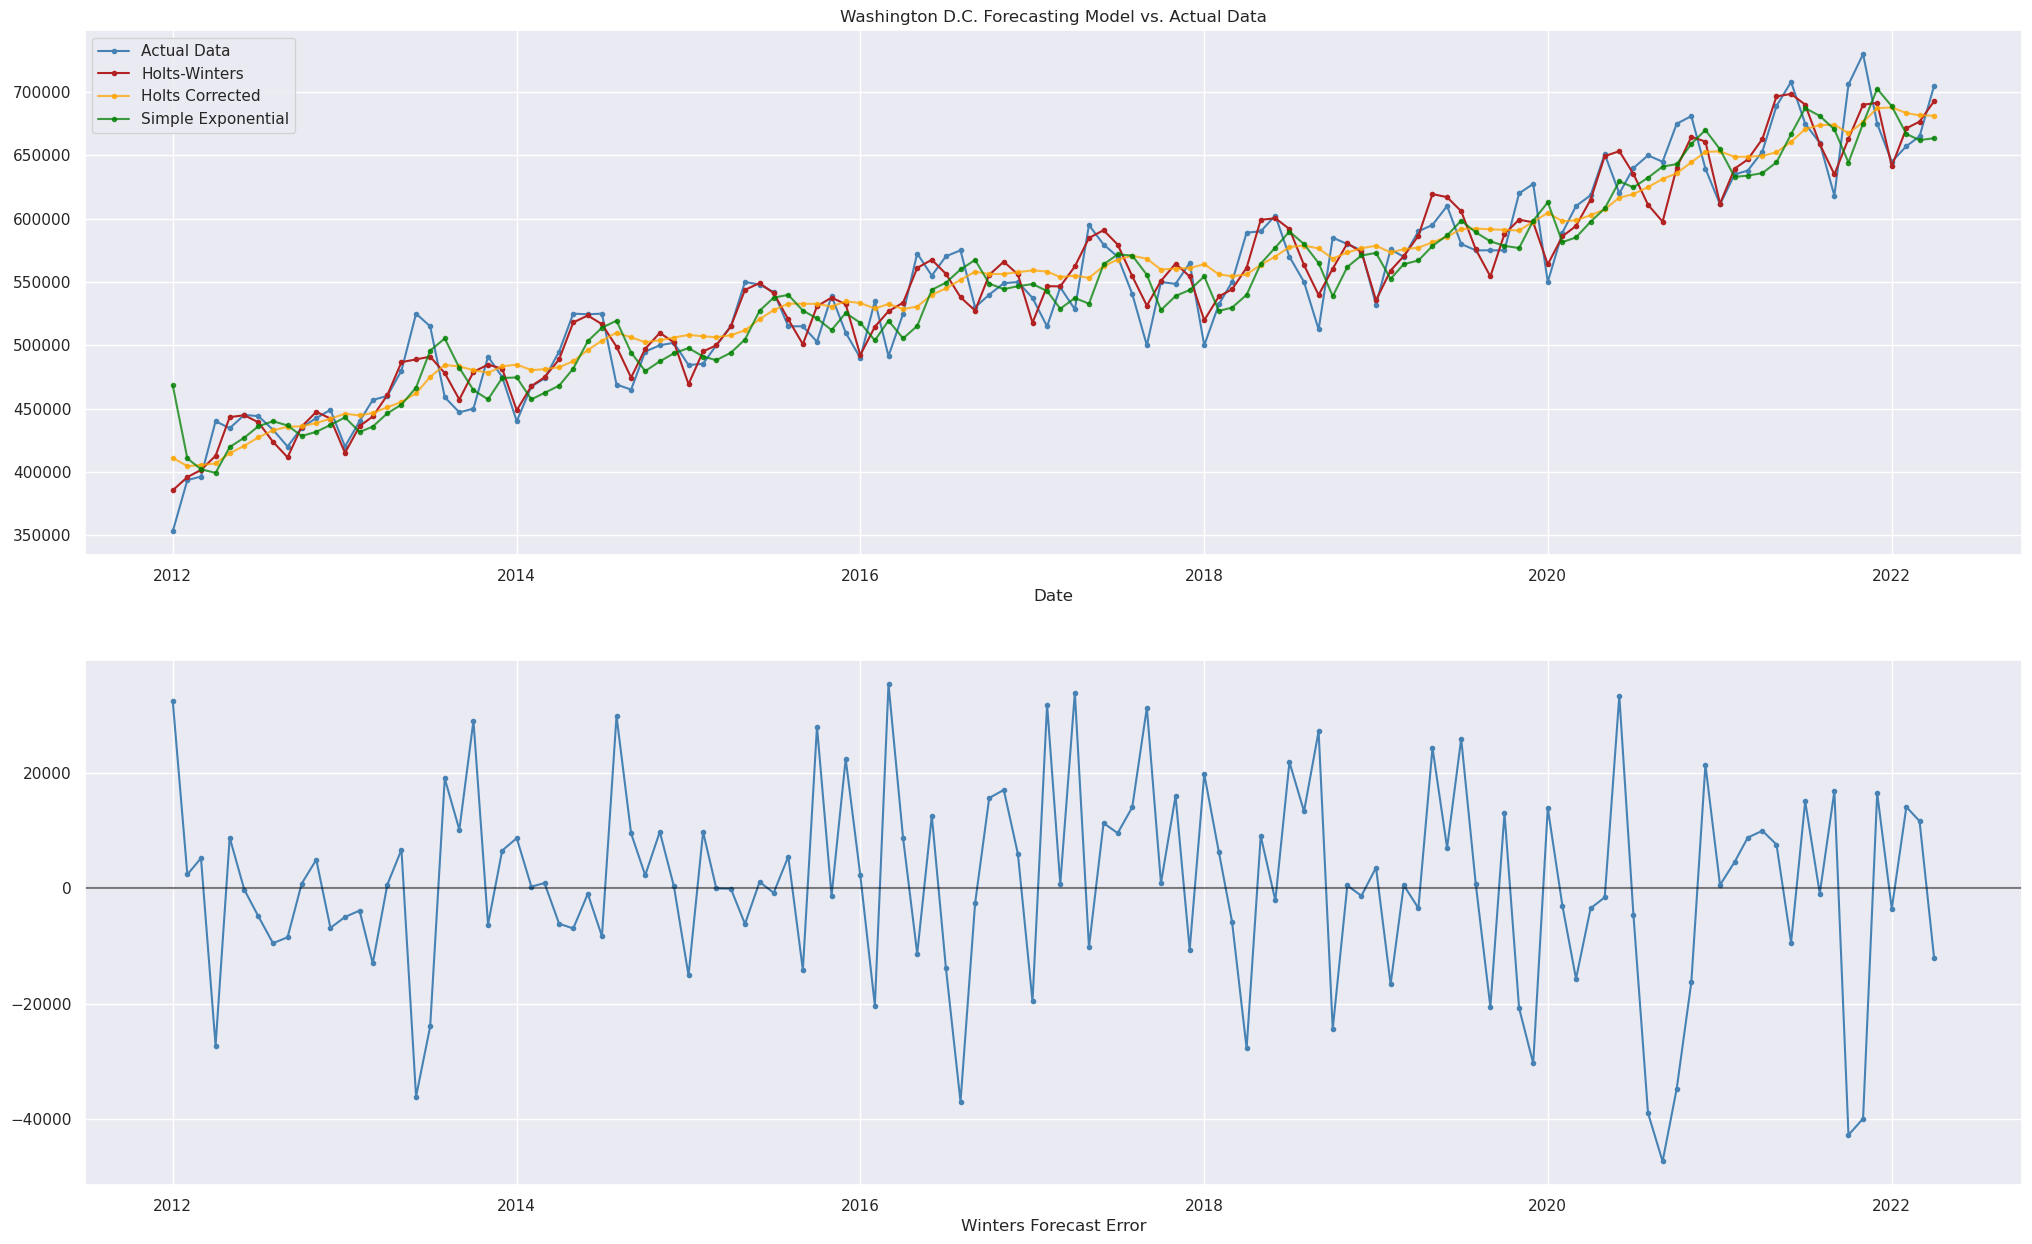

In [151]:
figure = plt.figure(figsize=(25, 15))

axes = figure.add_subplot(2, 1, 1)

axes.plot( DC_df.period_begin, DC_df.median_sale_price, color="steelblue", marker=".")
axes.plot( DC_df.period_begin, DC_winters, color="firebrick", marker=".")
axes.plot( DC_df.period_begin, DC_holts, color="orange", alpha=0.75, marker=".")
axes.plot( DC_df.period_begin, DC_ses[0][3], color="green", alpha=0.75, marker=".")
axes.set_xlabel( "Date")
axes.set_title("Washington D.C. Forecasting Model vs. Actual Data")
axes.legend(['Actual Data', 'Holts-Winters', 'Holts Corrected', 'Simple Exponential'])

axes = figure.add_subplot(2, 1, 2)

axes.plot( DC_df.period_begin, DC_winters - DC_df.median_sale_price, color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Winters Forecast Error")

plt.show()

Visually, Holts-Winter follows the actual data the closest compared to the previous two models, but the error is still a bit high. As stated previously, the time series associated with Washington D.C. has the most variation, making it difficult to model compared to the more predictable states we have dealt with thus far. We can use Sum Squared Error as the error metric in order to compare the accuracy of each model as follows:

In [152]:
ses_sse = ((DC_ses[0][3] -DC[0][1].median_sale_price) ** 2).sum()
holts_sse = ((DC_holts - DC[0][1].median_sale_price) ** 2).sum()
winters_sse = ((DC_winters - DC[0][1].median_sale_price) ** 2).sum()

sse = pd.DataFrame([ses_sse, holts_sse, winters_sse], columns = ["Sum Squared Error"], index=["SES", "Holts", "Winters"])

sse

Sum Squared Error
SES        110836968717.14
Holts       94903491352.54
Winters     36708810264.51

The Holt's Winter model is the most accurate in regards to the actual data. Therefore, incorporating level, trend, and seasonality yields an ideal forecasting model for Washington D.C.'s time series data. This highlights how seasonality is not always obvious visually, so it's important to look for autocorrelations between the errors and themselves in order to find signs of seasonality. We can formulate predictions for comparison as follows:

In [153]:
time_index = [124, 125, 126, 127]

DC_winters_predict = pd.DataFrame([winters_predict(DC_levels, DC_trends, DC_factors, time_index)],
                                   columns = ["(winters) 2022-05-01", "(winters) 2022-06-01", "(winters) 2022-07-01", "(winters) 2022-08-01"])

DC_predict_compare = pd.concat([DC_predict_compare, DC_winters_predict], axis=1)

print(tabulate(DC_predict_compare.T[1:], headers = ['date','median sale price'], tablefmt = 'fancy_grid'))

╒══════════════════════╤═════════════════════╕
│ date                 │   median sale price │
╞══════════════════════╪═════════════════════╡
│ 2022-04-01           │              705000 │
├──────────────────────┼─────────────────────┤
│ (SES) 2022-05-01     │              684275 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-05-01   │              690292 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-06-01   │              695447 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-07-01   │              700603 │
├──────────────────────┼─────────────────────┤
│ (holts) 2022-08-01   │              705758 │
├──────────────────────┼─────────────────────┤
│ (winters) 2022-05-01 │              733622 │
├──────────────────────┼─────────────────────┤
│ (winters) 2022-06-01 │              736201 │
├──────────────────────┼─────────────────────┤
│ (winters) 2022-07-01 │              738779 │
├──────────────────────┼─────────────────────┤
│ (winters) 2

The Holt's-Winters model predicts greater future median sale prices compared to both SES and Holt's Trend Corrected. This makes sense when we remember that these periods of the year had higher sale prices compared to the months with auto-correlations (around the end of the year). Therefore, the Holt's-Winters model is superior to both of the previous models and incorporating seasonality benefitted forecasting for Washington D.C's time series data. 